## Setup libs

In [1]:
import importlib
import brikasutils as bu
importlib.reload(bu)
import shared_utils as utils
from shared_utils import systemMsg, userMsg, assistantMsg
importlib.reload(utils)
import survey
importlib.reload(survey)
import persona
importlib.reload(persona)

import ollama
import numpy as np
from numpy.linalg import norm
import pandas as pd
import os
import re
import time
import json
from typing import List
from openai import OpenAI

# **Analysis**

### Batch analysis

In [1]:
import json
import os
import survey
import pandas as pd
import re
import importlib
import shared_utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
importlib.reload(utils)
import brikasutils as bu
importlib.reload(bu)

def see_if_column_valid(column_name, df, msg="Verification failed for"):
    dff = df[df[column_name].isna()]
    dfff = dff.groupby("sim_signature").apply(lambda x: x[x['run_number'] == 1], include_groups=False)
    print(f"{msg}: {len(dff)} ({len(dfff)} unique)")
    return dfff

MOST_IMPORTANT_COLUMNS = ['sim_signature', 'run_number', "model", "survey_type", "base_sim_signature", "SUBJECT", 'CTX_limit', "retrieval method"]

In [2]:
# Index all simulation files
SIMULATIONS_DIR = "analysis/sims-final-2"

sim_runs = []
for root, dirs, files in os.walk(SIMULATIONS_DIR):
    for file in files:
        if file.split(".")[1] != "json":
            print(f"Invalid file (all must be json) {sim_run['path']}")

        sim_run = {}
        sim_run["SIMULATION_ID"] = file.split(".")[0]
        sim_run["path"] = os.path.join(root, file)
        with open(sim_run["path"], 'r') as f:
            sim = json.load(f)
        sim_run.update(sim["info"]["info"])
        sim_run.update(sim["info"]["settings"])
        sim_runs.append(sim_run)

df = pd.DataFrame(sim_runs)
df = df.dropna(axis=1, how='all')
print(f"Loaded {len(df)} simulation files")

Loaded 234 simulation files


### Infer/Get Needed Data

In [3]:
def infer_survey_type(row):
    if "survey_type" in row and not pd.isna(row["survey_type"]):
        if row["survey_type"] == "KanoSurvey":
            return "KanoSurvey"
        elif row["survey_type"] == "PersonalitySurvey":
            return "PersonalitySurvey"
        else:
            print("Unknown survey type" + row["survey_type"])

    if "prompt_count" in row and not pd.isna(row["prompt_count"]):
        if row["prompt_count"] == 50:
            return "PersonalitySurvey"
        elif row["prompt_count"] == 40:
            return "KanoSurvey"
        else:
            print("Unknown prompt count" + row["prompt_count"])

    return None

df["survey_type"] = df.apply(infer_survey_type, axis=1) 
df["survey_type"].value_counts()

# extract_run_number
def extract_run_number(sim_id):
    try:
        parts = sim_id.rsplit('_', 1)  # Attempt to split by the last underscore
        if len(parts) == 2:  # Check if the split was successful
            return pd.Series([parts[0], int(parts[-1])])
        else:
            print(f"Error while processing {sim_id}")
            return pd.Series([pd.NA, pd.NA])  # Return None for last_number if split fails
         
    except Exception as e:  # Generic exception handling
        print(f"Error while processing {sim_id}")
        return pd.Series([pd.NA, pd.NA])

df[['sim_signature', 'run_number']] = df['SIMULATION_ID'].apply(extract_run_number)

In [4]:
# infer_if_simulation_is_base
def infer_if_simulation_is_base(row):
    if row["sim_signature"][:4] == "base":
        return True
    return False
    
df["is_base"] = df.apply(infer_if_simulation_is_base, axis=1)

# Below: Vanity Print
dff = df[df["is_base"] == True]
dff = dff.sort_values(by=['sim_signature', 'run_number'])
dff = dff.dropna(axis=1, how='all')
dfff = dff.groupby("sim_signature").apply(lambda x: x[x['run_number'] == 1], include_groups=False)
print(f"Found {len(dff)} ({len(dfff)} unique) base simulations")

Found 18 (6 unique) base simulations


In [5]:
# Map simulations to their base
def map_simulation_to_base(row):
    if row["is_base"] == True:
        return "(base)"
    if row["survey_type"] == "KanoSurvey" and row["model"] == "gpt-3.5-turbo":
        return "base_kano_v2_gpt35"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "gpt-3.5-turbo":
        return "base_personality_v2_gpt35"

    if row["survey_type"] == "KanoSurvey" and row["model"] == "llama3-70b":
        return "base-kano-29_llama3-70b_V7"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "llama3-70b":
        return "base-pers-29_llama3-70b_V7"
    
    if row["survey_type"] == "KanoSurvey" and row["model"] == "llama3-8b":
        return "base-kano-29_llama3-8b_V7"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "llama3-8b":
        return "base-pers-29_llama3-8b_V7"
    
    if row["survey_type"] == "KanoSurvey" and row["model"] == "mixtral-8x22b":
        return "base-kano-29_mixtral-8x22b_V7"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "mixtral-8x22b":
        return "base-pers-29_mixtral-8x22b_V7"
    
    return pd.NA
    
df["base_sim_signature"] = df.apply(map_simulation_to_base, axis=1)
dff = see_if_column_valid("base_sim_signature", df, "Missing mappings")
if len(dff) == 0:
    print("All mappings are valid")
else:
    print("Not all mappings are valid. See the missing mappings below")
    display(dff)

def infer_subject(row):
    if row["is_base"]:
        return "(base)"
    if "SUBJECT" in row and pd.notna(row["SUBJECT"]):
        if row["SUBJECT"] == "airidas" or row["SUBJECT"] == "Airidas" or row["SUBJECT"] == "airi":
            return "airidas"
        if row["SUBJECT"] == "elias" or row["SUBJECT"] == "eli":
            return "elias"
        print(f"Unknown subject: {row['SUBJECT']}")
        return pd.NA
    if "subject" in row and pd.notna(row["subject"]):
        if row["subject"] == "airidas" or row["subject"] == "Airidas" or row["subject"] == "airi":
            return "airidas"
        if row["subject"] == "elias" or row["subject"] == "eli":
            return "elias"
        print(f"Unknown subject: {row['subject']}")
        return pd.NA
    if row["sim_signature"][:4] == "airi":
        return "airidas"
    if row["sim_signature"][:3] == "eli":
        return "elias"
    return pd.NA

df["SUBJECT"] = df.apply(infer_subject, axis=1)
dff = see_if_column_valid("SUBJECT", df, "Missing subjects")
if len(dff) == 0:
    print("All subjects are valid")
else:
    display(dff)

df = utils.bring_to_front_important_columns(df, MOST_IMPORTANT_COLUMNS)


Missing mappings: 0 (0 unique)
All mappings are valid
Missing subjects: 0 (0 unique)
All subjects are valid


### Compute Scores

#### Setup

In [6]:
def get_surv_from_info(row):
    if row["survey_type"] == "KanoSurvey":
        return survey.KanoSurvey()
    elif row["survey_type"] == "PersonalitySurvey":
        return survey.PersonalitySurvey()
    else:
        raise Exception("Unknown survey type: " + row["survey_type"])

all_possible_asnwers = ["I LIKE IT", "I EXPECT IT", "I AM NEUTRAL", "I CAN TOLERATE IT", "I DISLIKE IT", "SOMEWHAT DISAGREE", "DISAGREE", "NEUTRAL", "SOMEWHAT AGREE", "AGREE"]
def extract_possible_answer(value):
    for phrase in all_possible_asnwers:
        pattern = r'(?i)' + re.escape(phrase)
        match = re.search(pattern, value)
        if match:
            # if value != phrase:
            #     er.append([value, phrase])  
            return match.group()
    return value  # Return the original value if no possible answer is found

############ Invalid Answers ##################
def get_invalid_answers(value):
    if pd.isna(value):
        return ""
    elif value == "NaN":
        return ""
    elif value in all_possible_asnwers:
        return ""
    else:
        return value

def clean_simulation_QA(df) -> pd.DataFrame:
    df['answer'] = df['answer'].apply(lambda x: x.strip())
    for substr in utils.BLACKLIST_ANSWER_SUBSTRINGS:
        df['answer'] = df['answer'].apply(lambda x: re.sub(substr, "", x))
    df['answer'] = df['answer'].str.upper()
    df['answer'] = df['answer'].apply(extract_possible_answer)

    REMAP_MISSING_E = {"AGRE": "AGREE", "SOMEWHAT AGRE": "SOMEWHAT AGREE", "SOMEWHAT DISAGRE": "SOMEWHAT DISAGREE", "DISAGRE": "DISAGREE", "I DON'T LIKE IT": "I DISLIKE IT"}
    df.iloc[:, 1:] = df.iloc[:, 1:].map(lambda x: REMAP_MISSING_E.get(x, x))

    PARTIAL_MATCH_REMAP = {"SOMEWHAT AG":"SOMEWHAT AGREE" }
    df["answer"] = df["answer"].apply(
        lambda answer: next((value for key, value in PARTIAL_MATCH_REMAP.items() if key in answer), answer)
    )

    # Update isValid
    df['isValid'] = df['answer'].apply(lambda x: x in all_possible_asnwers)

    # if all values in isValid is true, drop the column, else print a message
    if not df['isValid'].all():
        print("Warning, some answers were not valid. See df['isValid']")      

    return df

# Proces simulation output
def add_airidas_and_elias_answers(df, surv) -> pd.DataFrame:
    # Add airidas and elias answers
    air = surv.test_answers["airidas"]
    eli = surv.test_answers["elias"]

    # Sanity Check
    if len(air) != len(df):
        raise Exception(f"Survey and DF length mismatch {len(air)} != {len(df)}. Suvey type: {str(type(surv))}")

    df.insert(2, "airidas", air[:len(df)])
    df.insert(3, "elias", eli[:len(df)])

    # Convert to uppercase
    if isinstance(surv, survey.KanoSurvey):
        df['answer'] = df['answer'].str.upper()
        df['airidas'] = df['airidas'].str.upper()
        df['elias'] = df['elias'].str.upper()
        
    return df

def remap_answers_to_integers(df, surv, remap_answer = True):
    if isinstance(surv, survey.KanoSurvey):
        remap_dict = {"I EXPECT IT": 5, "I LIKE IT": 4, "I AM NEUTRAL": 3, "I CAN TOLERATE IT": 2, "I DISLIKE IT": 1}
        if remap_answer:
            df['answer'] = df['answer'].str.upper()
            df['answer'] = df['answer'].map(remap_dict)
        df['airidas'] = df['airidas'].str.upper()
        df['elias'] = df['elias'].str.upper()
        
        df['airidas'] = df['airidas'].map(remap_dict)
        df['elias'] = df['elias'].map(remap_dict)
    elif isinstance(surv, survey.PersonalitySurvey):
        remap_dict = {"AGREE": 5, "SOMEWHAT AGREE": 4, "NEUTRAL": 3, "SOMEWHAT DISAGREE": 2, "DISAGREE": 1}
        if remap_answer:
            df['answer'] = df['answer'].map(remap_dict)

    return df

def evaluate_single_simulation_run(df, sim_row) -> dict:
    # compute the percentage of correct answers and average loss (MAE)
    p_corr_airidas = df['answer'].corr(df['airidas'])
    p_corr_elias = df['answer'].corr(df['elias'])
    mae_airi = (df['answer'] - df['airidas']).abs().sum() / len(df)
    mae_eli = (df['answer'] - df['elias']).abs().sum() / len(df)

    if sim_row["is_base"]: mae, p_corr = pd.NA, pd.NA
    elif sim_row["SUBJECT"] == "airidas": mae, p_corr = mae_airi, p_corr_airidas
    elif sim_row["SUBJECT"] == "elias": mae, p_corr = mae_eli, p_corr_elias
    else: raise Exception("Unknown subject")

    result_data = {
        "MAE": mae,
        "MAE_airi": mae_airi,
        "MAE_eli": mae_eli,
        "p-corr": p_corr,
        "p-corr_Airidas": p_corr_airidas,
        "p-corr_Elias": p_corr_elias,
        "question_count": len(df),
    }
    return result_data



ADD_TO_MOST_IMPORTANT_COLUMNS = ["MAE_airi", "MAE_eli"]
for col in ADD_TO_MOST_IMPORTANT_COLUMNS:
    if col not in MOST_IMPORTANT_COLUMNS:
        MOST_IMPORTANT_COLUMNS.append(col)  

#### Multi-Sim

In [7]:
EVALUATE_INVALID_SIMULATIONS = True
invalid_vals = []
tmp = []

for index, sim_row in df.iterrows():
    sim = utils.load_sim(sim_row["path"])
    dfQA = utils.dataframe_from_QA(sim["QA"])
    with bu.MutePrint():
        surv = get_surv_from_info(sim_row)
        dfQA = clean_simulation_QA(dfQA)
    dfQA = add_airidas_and_elias_answers(dfQA, surv)

    ## Check for invalid values
    if not dfQA['isValid'].all():
        invalid_vals.extend(dfQA.loc[~dfQA['isValid'], 'answer'].tolist())
        
        if EVALUATE_INVALID_SIMULATIONS:
            print(f"{sim_row['SIMULATION_ID']} has invalid value(s). Sim will be included with dropped rows.")
            dfQA = dfQA[dfQA['isValid'] == True]
        else:
            print(f"Skipping {sim_row['SIMULATION_ID']} due to invalid answers")
            continue

    dfQA = remap_answers_to_integers(dfQA, surv)
    for key, value in evaluate_single_simulation_run(dfQA, sim_row = sim_row).items():
        df.at[index, key] = round(value, 3) if not pd.isna(value) else value

# Rename values
df['CTX_limit'] = df['CTX_limit'].astype(str)
df.loc[df['CTX_limit'] == "0", 'CTX_limit'] = '1-chunk'

df = utils.bring_to_front_important_columns(df, MOST_IMPORTANT_COLUMNS)

if len(invalid_vals) > 0:
    print(f"{len(invalid_vals)} Invalid values:")
    display(pd.DataFrame(invalid_vals, columns=["Invalid Values"]))
    if EVALUATE_INVALID_SIMULATIONS:
        print("EVALUATE_INVALID_SIMULATIONS == True. All invalid values were dropped")
else:
    print("All values are valid")

airidas-pers-4000_mixtral-8x22b_V7_2 has invalid value(s). Sim will be included with dropped rows.
airidas-pers-7500_mixtral-8x22b_V7_0 has invalid value(s). Sim will be included with dropped rows.
eli-pers-dynamic-7500_mixtral-8x22b_V8_0 has invalid value(s). Sim will be included with dropped rows.
eli-pers-dynamic-7500_mixtral-8x22b_V8_1 has invalid value(s). Sim will be included with dropped rows.
eli-pers-dynamic-7500_mixtral-8x22b_V8_2 has invalid value(s). Sim will be included with dropped rows.
5 Invalid values:


Invalid Values
0  IT SEEMS THAT YOU HAVE A TEXT-BASED CONVERSATI...
1  IT SEEMS LIKE YOU ARE PROVIDING A SERIES OF ME...
2  THE CONVERSATION IS BETWEEN TWO FRIENDS DISCUS...
3  IT SEEMS LIKE YOU ARE LOOKING FOR A WAY TO CON...
4  IT SEEMS LIKE YOU AND YOUR FRIEND ARE DISCUSSI...

EVALUATE_INVALID_SIMULATIONS == True. All invalid values were dropped


### Viz distrib

Using default Kano Survey CSV file: surveys/survey_kano-model.csv
Using default Personality Survey CSV file: surveys/survey_personality-test.csv


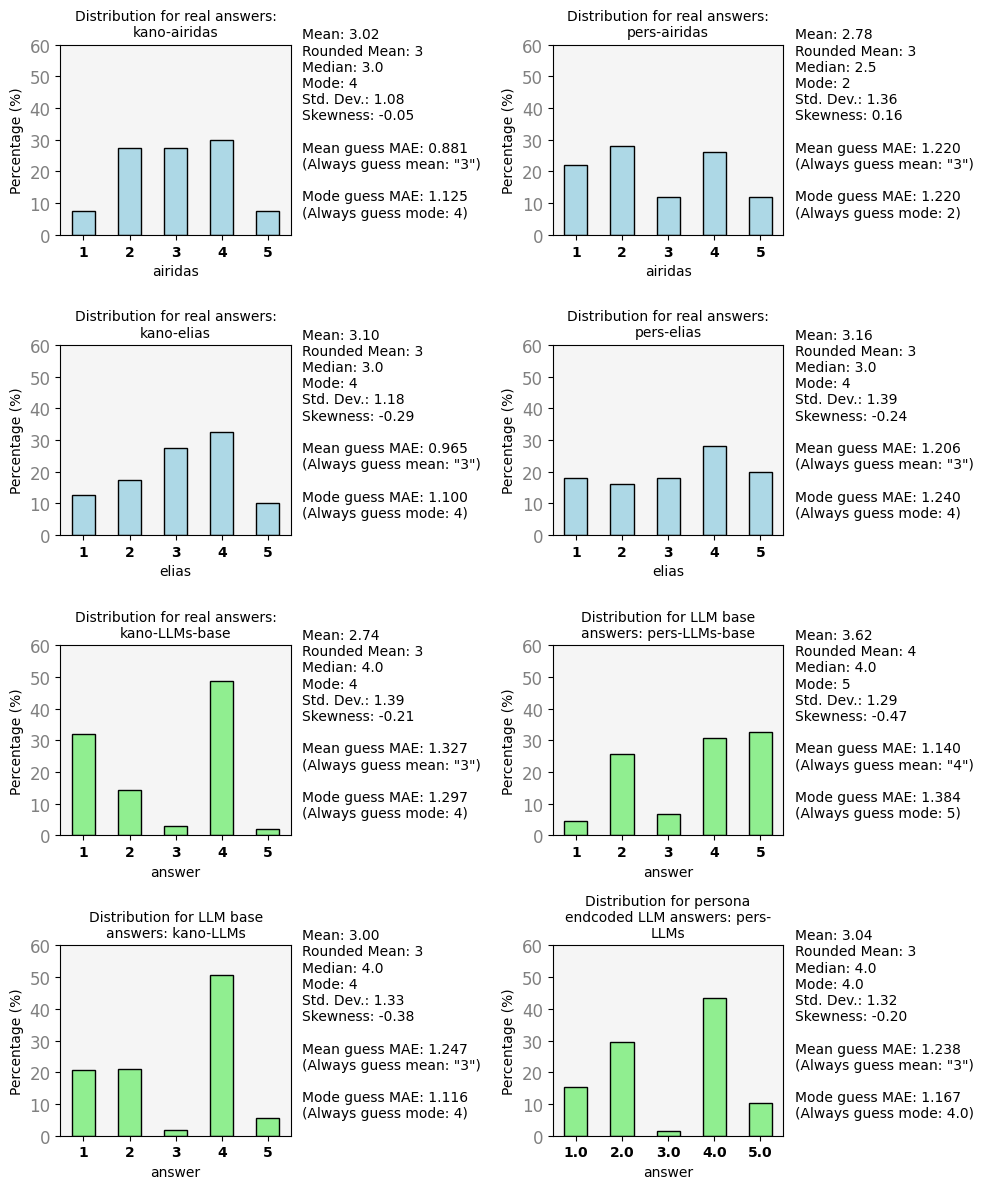

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap

import matplotlib.pyplot as plt
dfQAs_kano = []
dfQAs_pers = []
dfQAs_pers_base = []
dfQAs_kano_base = []
for index, sim_row in df.iterrows():
    sim = utils.load_sim(sim_row["path"])
    dfQA = utils.dataframe_from_QA(sim["QA"])
    with bu.MutePrint():
        surv = get_surv_from_info(sim_row)
        dfQA = clean_simulation_QA(dfQA)
    dfQA = add_airidas_and_elias_answers(dfQA, surv)
    dfQA = remap_answers_to_integers(dfQA, surv)

    if sim_row["is_base"]:
        if sim_row["survey_type"] == "KanoSurvey":
            dfQAs_kano_base.append(dfQA)
        elif sim_row["survey_type"] == "PersonalitySurvey":
            dfQAs_pers_base.append(dfQA)
    else:
        if sim_row["survey_type"] == "KanoSurvey":
            dfQAs_kano.append(dfQA)
        elif sim_row["survey_type"] == "PersonalitySurvey":
            dfQAs_pers.append(dfQA)


surv_kano = survey.KanoSurvey()
surv_pers = survey.PersonalitySurvey()
surv_kano.df = remap_answers_to_integers(surv_kano.df, surv_kano, remap_answer=False)
surv_pers.df = remap_answers_to_integers(surv_pers.df, surv_pers, remap_answer=False)

#########################################################
#########################################################

# Assuming the dataframes and lists of dataframes are defined and imported already
val_counts_raw = {
    "kano-airidas": {
        "data": surv_kano.df['airidas'].value_counts().sort_index(),
        "text": "real answers",
        "color": "lightblue",
        },
    "pers-airidas": {
        "data": surv_pers.df['airidas'].value_counts().sort_index(),
        "text": "real answers",
        "color": "lightblue",
        },
    "kano-elias": {
        "data": surv_kano.df['elias'].value_counts().sort_index(),
        "text": "real answers",
        "color": "lightblue",
        },
    "pers-elias": {
        "data": surv_pers.df['elias'].value_counts().sort_index(),
        "text": "real answers",
        "color": "lightblue",
        },
    'kano-LLMs-base': {
        "data": pd.concat([df['answer'] for df in dfQAs_kano_base]).value_counts().sort_index(),
        "text": "LLM base answers",
        "color": "lightgreen",
        },
    "pers-LLMs-base": {
        "data": pd.concat([df['answer'] for df in dfQAs_pers_base]).value_counts().sort_index(),
        "text": "LLM base answers",
        "color": "lightgreen",
        },
    'kano-LLMs': {
        "data": pd.concat([df['answer'] for df in dfQAs_kano]).value_counts().sort_index(),
        "text": "persona endcoded LLM answers",
        "color": "lightgreen",
        },
    "pers-LLMs": {
        "data": pd.concat([df['answer'] for df in dfQAs_pers]).value_counts().sort_index(),
        "text": "persona endcoded LLM answers",
        "color": "lightgreen",
        },
    
}

plt.figure(figsize=(10, 12))
for i, (key, value) in enumerate(val_counts_raw.items(), start=1):
    ax = plt.subplot(4, 2, i)
    title_text = f"Distribution for {info['text']}: {key}"
    wrapped_title = textwrap.fill(title_text, width=30)  # You can adjust width as needed
    plt.title(wrapped_title, fontsize=10)
    plt.xlabel('Answer Values')
    plt.ylabel('Percentage (%)')

    info = value.copy()
    value = value["data"]
    # Calculating statistics on the original unnormalized counts
    val_array = np.repeat(value.index, value.values)
    mean = np.mean(val_array)
    median = np.median(val_array)
    mode = value.idxmax()
    std_dev = np.std(val_array)
    skewness = np.sum((val_array - mean)**3) / (len(val_array) * std_dev**3)
    mae = np.mean(np.abs(val_array - mean))
    mae_mode = np.mean(np.abs(val_array - mode))

    stats_text = (
        f'Mean: {mean:.2f}\n'
        f"Rounded Mean: {round(mean)}\n"
        f'Median: {median}\n'
        f'Mode: {mode}\n'
        f'Std. Dev.: {std_dev:.2f}\n'
        f'Skewness: {skewness:.2f}\n\n'
        f'Mean guess MAE: {mae:.3f}\n'
        f'(Always guess mean: "{round(mean)}")\n\n'
        f'Mode guess MAE: {mae_mode:.3f}\n'
        f'(Always guess mode: {mode})\n\n'
    )
    
    plt.annotate(stats_text, xy=(1.05, 0.5), xycoords='axes fraction',
                    fontsize=10, ha='left', va='center')

    # Normalizing data just before plotting
    value_normalized = (value / value.sum()) * 100
    value_normalized.plot(kind='bar', ax=ax, color=info["color"], linewidth=1, edgecolor='black')
    ax.set_ylim(0, 60)
    super_format_ax(ax, custom_x_label_size=10)

plt.tight_layout()
plt.show()

## Aggregate

In [29]:
# Define how columns should be groped
aggregation_dict = {
    'MAE_airi': ['mean', 'std'],
    'MAE_eli': ['mean', 'std'],
    'MAE': ['mean', 'std'],
    'run_number': ['count'],
    'question_count': ['min'],
    'p-corr_Airidas': ['mean', 'std'],
    'p-corr_Elias': ['mean', 'std'],
    'p-corr': ['mean', 'std'],
}


# Preserve the first entry of other columns
for col in df.columns:
    if col not in ['sim_signature', *list(aggregation_dict.keys())]:
        aggregation_dict[col] = 'first'
        
# dfg stands for DataFrame Grouped.
dfg = df.groupby('sim_signature').agg(aggregation_dict)

# Renaming MultiIndex columns
dfg.columns = ['_'.join(col).strip() if col[1] != 'first' else col[0] for col in dfg.columns.values]
dfg.rename(columns={'run_number_count': 'n-runs'}, inplace=True)
for key in aggregation_dict.keys():
    if 'mean' in aggregation_dict[key]:
        dfg.rename(columns={f"{key}_mean": key}, inplace=True)
dfg = dfg.reset_index()

## Base stuff

In [30]:
base_dfg = dfg[dfg['is_base'] == True]
global_base_scores = {
    "master": base_dfg[['MAE_airi', 'MAE_eli']].mean().mean(),
    "mean_guess": {
        "kano": 0.9125,
        "pers": 1.210
    },
    "by_subject": {
        "airidas": base_dfg[['MAE_airi']].mean().mean(),
        "elias": base_dfg[['MAE_eli']].mean().mean(),
    },
    "by_survey":{
        "KanoSurvey": base_dfg[base_dfg['survey_type'] == "KanoSurvey"][['MAE_airi', 'MAE_eli']].mean().mean(),
        "PersonalitySurvey": base_dfg[base_dfg['survey_type'] == "PersonalitySurvey"][['MAE_airi', 'MAE_eli']].mean().mean(),
    },
    "by_model":{
        "llama3-70b": base_dfg[base_dfg['model'] == "llama3-70b"][['MAE_airi', 'MAE_eli']].mean().mean(),
        "llama3-8b": base_dfg[base_dfg['model'] == "llama3-8b"][['MAE_airi', 'MAE_eli']].mean().mean(),
        "mixtral-8x22b": base_dfg[base_dfg['model'] == "mixtral-8x22b"][['MAE_airi', 'MAE_eli']].mean().mean(),
    },
    "by_survey_subject":{
        "PersAiri": base_dfg[base_dfg['survey_type'] == "PersonalitySurvey"][['MAE_airi']].mean().mean(),
        "PersEli": base_dfg[base_dfg['survey_type'] == "PersonalitySurvey"][['MAE_eli']].mean().mean(),
        "KanoAiri": base_dfg[base_dfg['survey_type'] == "KanoSurvey"][['MAE_airi']].mean().mean(),
        "KanoEli": base_dfg[base_dfg['survey_type'] == "KanoSurvey"][['MAE_eli']].mean().mean(),
    },
    "by_simulation": {
        "kano_llama3-70b": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-70b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
        "pers_llama3-70b": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-70b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
        "kano_llama3-8b": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-8b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
        "pers_llama3-8b": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-8b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
        "kano_mixtral-8x22b": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_mixtral-8x22b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
        "pers_mixtral-8x22b": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_mixtral-8x22b_V7')][['MAE_airi', 'MAE_eli']].mean().mean(),
    },
    "atomic": {
        "base-kano_llama3-70b_airi": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-70b_V7')]['MAE_airi'].mean(),
        "base-kano_llama3-70b_eli": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-70b_V7')]['MAE_eli'].mean(),
        "base-pers_llama3-70b_airi": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-70b_V7')]['MAE_airi'].mean(),
        "base-pers_llama3-70b_eli": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-70b_V7')]['MAE_eli'].mean(),
        "base-kano_llama3-8b_airi": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-8b_V7')]['MAE_airi'].mean(),
        "base-kano_llama3-8b_eli": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_llama3-8b_V7')]['MAE_eli'].mean(),
        "base-pers_llama3-8b_airi": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-8b_V7')]['MAE_airi'].mean(),
        "base-pers_llama3-8b_eli": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_llama3-8b_V7')]['MAE_eli'].mean(),
        "base-kano_mixtral-8x22b_airi": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_mixtral-8x22b_V7')]['MAE_airi'].mean(),
        "base-kano_mixtral-8x22b_eli": base_dfg[(base_dfg['sim_signature'] == 'base-kano-29_mixtral-8x22b_V7')]['MAE_eli'].mean(),
        "base-pers_mixtral-8x22b_airi": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_mixtral-8x22b_V7')]['MAE_airi'].mean(),
        "base-pers_mixtral-8x22b_eli": base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_mixtral-8x22b_V7')]['MAE_eli'].mean(),
    }
}


In [26]:
bu.quickJSON(global_base_scores, "global_base_scores.json")

In [31]:
def compare_to_paired_base(row: pd.Series, df: pd.DataFrame):
    if row["is_base"]:
        return {
            "dMAE_airi": pd.NA,
            "dMAE_eli": pd.NA,
            "dMAE": pd.NA,
        }
    
    # Individual base
    base = df[(df["sim_signature"] == row["base_sim_signature"])]
    if len(base) == 0:
        raise Exception(f"Base not found for {row['base_sim_signature']}")
    if len(base) > 1:
        raise Exception(f"Multiple bases found for {row['base_sim_signature']}. (Make sure you are using grouped df)")

    base = base.iloc[0]
    airi = row["MAE_airi"] - base["MAE_airi"]
    eli = row["MAE_eli"] - base["MAE_eli"]
    subj = airi if row["SUBJECT"] == "airidas" else eli

    return {
        "dMAE_airi": airi,
        "dMAE_eli": eli,
        "dMAE": subj,
    }

def compare_to_custom_base(row: pd.Series, df: pd.DataFrame, base_val: float, base_name: str):    
    if row["is_base"]:
        return {
            f"dMAE_{base_name}_airi": pd.NA,
            f"dMAE_{base_name}_eli": pd.NA,
            f"dMAE_{base_name}": pd.NA,
        }

    airi = row["MAE_airi"] - base_val
    eli =  row["MAE_eli"] - base_val
    subj = airi if row["SUBJECT"] == "airidas" else eli

    return {
        f"dMAE_{base_name}_airi": airi,
        f"dMAE_{base_name}_eli": eli,
        f"dMAE_{base_name}": subj,
    }

ADD_TO_MOST_IMPORTANT_COLUMNS = ["sim_signature","dMAE", "dMAE_airi", "dMAE_eli"]
for col in ADD_TO_MOST_IMPORTANT_COLUMNS:
    if col in MOST_IMPORTANT_COLUMNS:
        MOST_IMPORTANT_COLUMNS.remove(col)
MOST_IMPORTANT_COLUMNS = ADD_TO_MOST_IMPORTANT_COLUMNS + MOST_IMPORTANT_COLUMNS

In [32]:
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["master"], base_name="master").items():
        dfg.at[index, key] = value

In [33]:
# Compare to base
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_paired_base(sim_row, dfg).items():
        dfg.at[index, key] = value

ADD_TO_MOST_IMPORTANT_COLUMNS = ["sim_signature","MAE"]
for col in ADD_TO_MOST_IMPORTANT_COLUMNS:
    if col in MOST_IMPORTANT_COLUMNS:
        MOST_IMPORTANT_COLUMNS.remove(col)
MOST_IMPORTANT_COLUMNS = ADD_TO_MOST_IMPORTANT_COLUMNS + MOST_IMPORTANT_COLUMNS
dfg = utils.bring_to_front_important_columns(dfg, MOST_IMPORTANT_COLUMNS)
print(f"Total unique simulations: {len(dfg)}")

Total unique simulations: 78


### Viz Global Bases

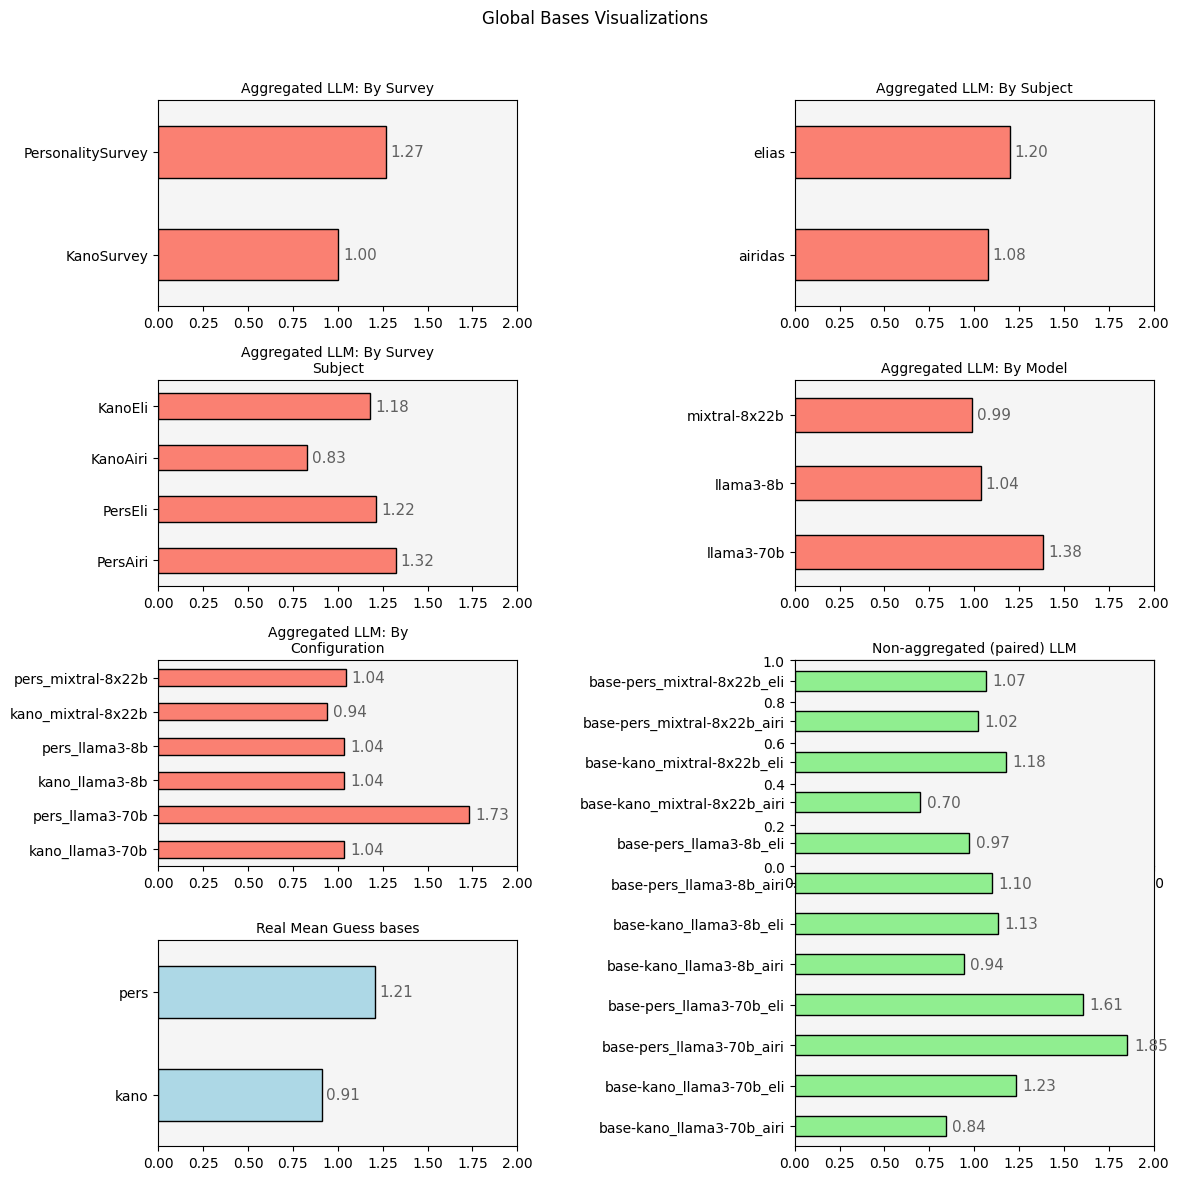

In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import textwrap
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 12))
fig.suptitle('Global Bases Visualizations')
gs = gridspec.GridSpec(4, 2)

# Define axes using the GridSpec
axs = {
    (0, 0): fig.add_subplot(gs[0, 0]),
    (0, 1): fig.add_subplot(gs[0, 1]),
    (1, 0): fig.add_subplot(gs[1, 0]),
    (1, 1): fig.add_subplot(gs[1, 1]),
    (2, 0): fig.add_subplot(gs[2, 0]),
    (2, 1): fig.add_subplot(gs[2, 1]),
    (3, 0): fig.add_subplot(gs[3, 0]),
    (3, 1): fig.add_subplot(gs[2:4, 1])  # Span 'Non-aggregated LLM' across two vertical spaces
}

# Data dictionary to align with subplot axes
plot_data = {
    (0, 0): ('by_survey', 'Aggregated LLM: By Survey', "salmon"),
    (0, 1): ('by_subject', 'Aggregated LLM: By Subject', "salmon"),
    (1, 0): ('by_survey_subject', 'Aggregated LLM: By Survey Subject', "salmon"),
    (1, 1): ('by_model', 'Aggregated LLM: By Model', "salmon"),
    (2, 0): ('by_simulation', 'Aggregated LLM: By Configuration', "salmon"),
    (3, 0): ('mean_guess', 'Real Mean Guess bases', "lightblue"),
    (3, 1): ('atomic', 'Non-aggregated (paired) LLM', "lightgreen")
}

# Loop through to plot each graph
for pos, (key, title, color) in plot_data.items():
    ax = axs[pos]
    title_text = textwrap.fill(title, width=30)  
    ax.set_title(title_text, fontsize=10)

    if key == 'master':
        ax.barh('Master', global_base_scores[key], color=color, edgecolor='black', linewidth=1)
    else: 
        df = pd.DataFrame.from_dict(global_base_scores[key], orient='index', columns=['Value'])
        bars = df.plot.barh(ax=ax, legend=False, color=color, edgecolor='black', linewidth=1)
        
        # Add value annotations to each bar
        for bar in bars.patches:
            bar_value = bar.get_width()
            ax.text(bar.get_width() + df['Value'].max()*0.02, bar.get_y() + bar.get_height()/2, 
                    f'{bar_value:.2f}', va='center', ha='left', color='#606060', fontsize=11)
            
    # Style adjustments
    ax.set_facecolor('#f5f5f5')
    ax.set_xlim(0, 2.0)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Vizualisation

#### See info for giving to chatbot for code gen

In [ ]:
IGNORE_COLS = ["date", "EMBED_MODEL", "avg_tokens_in_prompt", "chunk_count", "OVERLAP_SIZE", "RETRIEVAL_PROMPT", "SIMULATION_ID", "path", "survey", ]

for col in dfg.columns:
    if col in IGNORE_COLS:
        continue  # Skip the columns from the IGNORE_COLS list
    dtype = dfg[col].dtype
    uniq_vals = dfg[col].unique()
    uniq_count = len(uniq_vals)
    na_count = dfg[col].isna().sum()
    print(f"{col}, dtype: {dtype}, unique count: {uniq_count}, NA values: {na_count}", end="")
    
    # Condition to check length of unique values and print them if < 5 and each < 25 chars
    if uniq_count < 8 and all(len(str(val)) <= 150 for val in uniq_vals):
        print(f", Unique values: {uniq_vals}", end="")
    print()

### Viz v2

In [27]:
import textwrap
def getGlobalColorByParam(param):
    if param == 'SUBJECT':
        color = 'lightblue'
    elif param == 'survey_type':
        color = 'lightblue'
    elif param == 'model':
        color = 'lightgreen'
    else:
        color = 'salmon'
    return color

def super_format_ax(ax, custom_x_label_size=13):
    tick_locations = ax.get_xticks()
    # Retrieve and wrap the existing labels
    tick_labels = [textwrap.fill(label.get_text(), width=8, break_long_words=True, break_on_hyphens=True) 
                for label in ax.get_xticklabels()]
    ax.set_xticks(tick_locations) 
    ax.set_xticklabels(tick_labels, fontsize=custom_x_label_size, fontweight="semibold", rotation=0)

    tick_locations_y = ax.get_yticks()
    # Retrieve and wrap the existing labels
    tick_labels_y = [textwrap.fill(label.get_text(), width=8, break_long_words=True, break_on_hyphens=True) 
                for label in ax.get_yticklabels()]
    ax.set_yticks(tick_locations_y) 
    ax.set_yticklabels(tick_labels_y, fontsize=12,rotation=0, color='#808080')
    ax.set_facecolor('#f5f5f5')

def add_value_texts(grouped_data, ax):
    mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
    pos = range(len(mins))  # Positions of the boxplots
    vertical_offset = 0.017  # offset each text to avoid clutter
    COLOR = '#606060'
    for tick in pos:
        ax.text(tick, mins[tick] - vertical_offset - 0.022, f'{mins[tick]:.2f}', horizontalalignment='center', size='10', color=COLOR) #TODO
        ax.text(tick, medians[tick] + vertical_offset - 0.003, f'{medians[tick]:.2f}', horizontalalignment='center', size='11.5', color=COLOR) #TODO
        ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='10', color=COLOR) #TODO


#### MAE

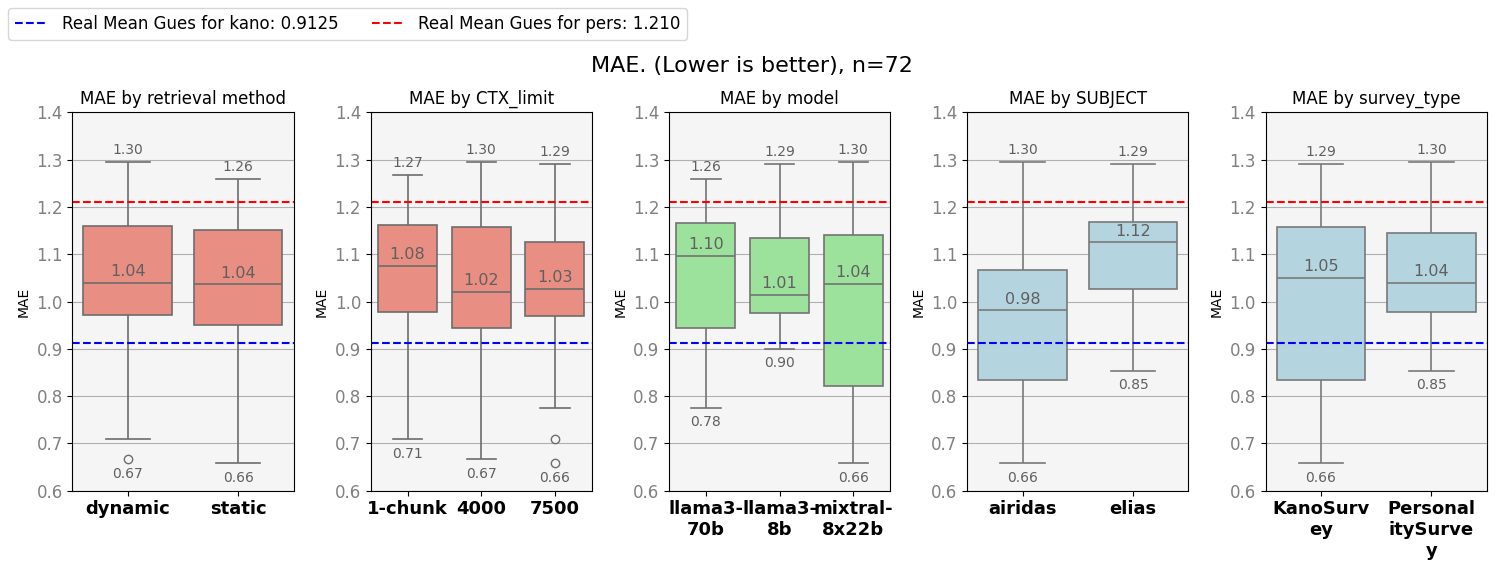

In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming your dataframe is named `dfg`
plt.figure(figsize=(15, 5))

filtered_df = dfg[dfg['is_base'] == False]
parameters = ['retrieval method', 'CTX_limit', 'model', 'SUBJECT', 'survey_type']

lines, labels = [], [] # To keep track of legend handles
for i, param in enumerate(parameters, 1):
    ax = plt.subplot(1, 5, i)
    ax.grid(True)
    color = getGlobalColorByParam(param)
    sns.boxplot(x=param, y='MAE', color=color, data=filtered_df, ax=ax, linewidth=1.2)
    #### Extract median values and their positions ######
    grouped_data = filtered_df.groupby(param)['MAE']
    add_value_texts(grouped_data, ax)
    #####################################################
    
    plt.title(f'MAE by {param}')
    plt.ylabel('MAE')
    plt.xticks(rotation=0) 
    plt.ylim(bottom=0.6, top=1.35)
    super_format_ax(ax)

    # Adding horizontal lines for guidelines
    line1, line2 = plt.axhline(y=0.9125, color='blue', linestyle='--'), plt.axhline(y=1.210, color='red', linestyle='--')
    if i == 1:  # Only need these once for creating the legend
        lines.extend([line1, line2])
        labels.extend(['Real Mean Gues for kano: 0.9125', 'Real Mean Gues for pers: 1.210'])

for ax in plt.gcf().axes:  # Go over all subplots in the figure
    ax.set_xlabel('') 
plt.tight_layout()
plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=12)
plt.suptitle(f'\n\nMAE. (Lower is better), n={len(filtered_df)}', y=1.13, fontsize=16) 
plt.show()

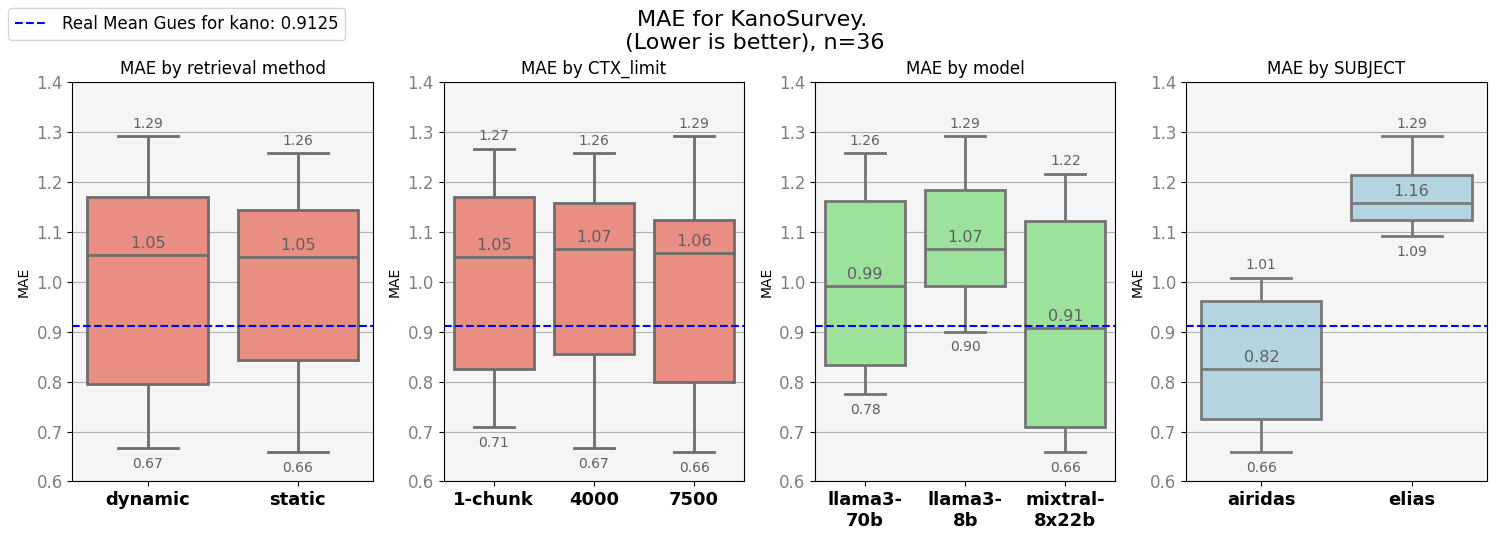

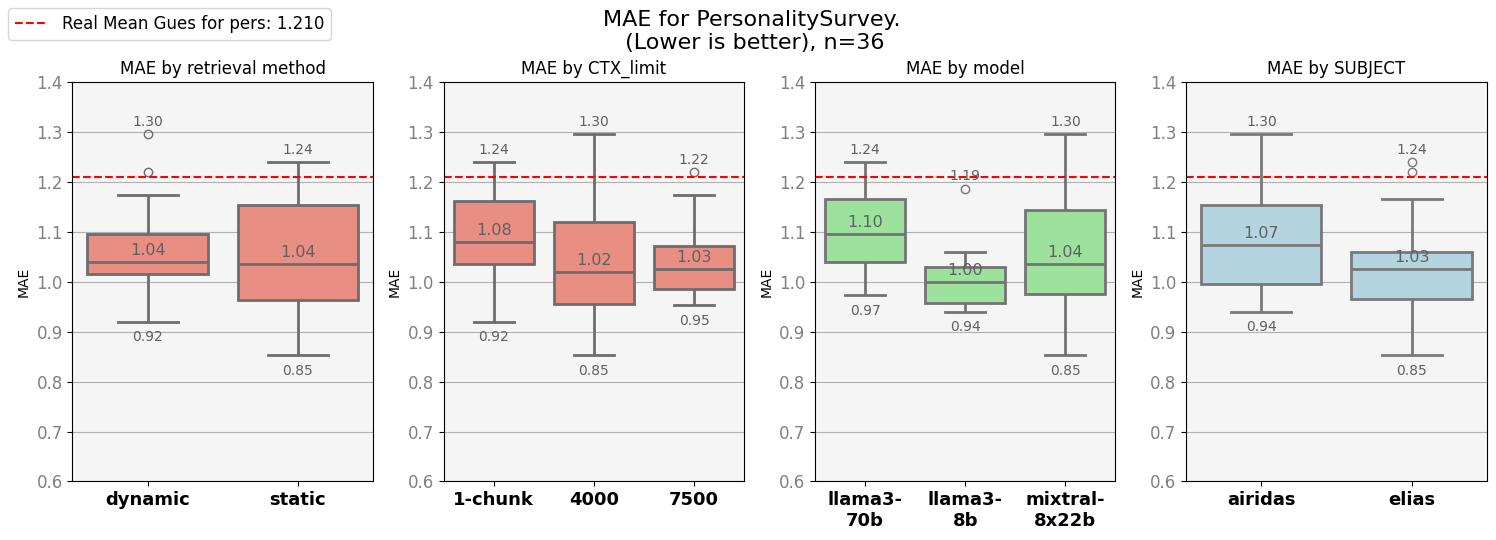

In [216]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap


# Assuming your dataframe is named `df`
for srv in ['KanoSurvey', "PersonalitySurvey"]:
    plt.figure(figsize=(15, 5))
    filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == srv)]
    parameters = ['retrieval method', 'CTX_limit', 'model', 'SUBJECT']
    
    lines, labels = [], [] # To keep track of legend handles
    for i, param in enumerate(parameters, 1):
        ax = plt.subplot(1, 4, i)
        ax.grid(True)
        
        color = getGlobalColorByParam(param)
        sns.boxplot(x=param, y='MAE', color=color, data=filtered_df, ax=ax, linewidth=2)
        #### Extract median values and their positions ######
        grouped_data = filtered_df.groupby(param)['MAE']
        add_value_texts(grouped_data, ax)
        #####################################################
        
        plt.title(f'MAE by {param}')
        plt.ylabel('MAE')
        plt.xticks(rotation=0) 
        plt.ylim(bottom=0.6, top=1.35)
        super_format_ax(ax)

        # Adding horizontal lines for guidelines
        if srv == 'KanoSurvey':
            lines_new = [plt.axhline(y=0.9125, color='blue', linestyle='--')]
            labels_new = ['Real Mean Gues for kano: 0.9125']
        elif srv == 'PersonalitySurvey':
            lines_new = [plt.axhline(y=1.210, color='red', linestyle='--')]
            labels_new = ['Real Mean Gues for pers: 1.210']
        else:
            lines_new = [plt.axhline(y=0.9125, color='blue', linestyle='--'), plt.axhline(y=1.210, color='red', linestyle='--')]
            labels_new = ['Real Mean Guess for Kano: 0.9125', 'Real Mean Guess for pers: 1.210']
        
        if i == 1:  # Only need these once for creating the legend
            lines.extend(lines_new)
            labels.extend(labels_new)

    for ax in plt.gcf().axes:  # Go over all subplots in the figure
        ax.set_xlabel('') 
    plt.tight_layout()
    plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=12)
    plt.suptitle(f'MAE for {srv}.\n (Lower is better), n={len(filtered_df)}', y=1.07, fontsize=16) 
    plt.show()


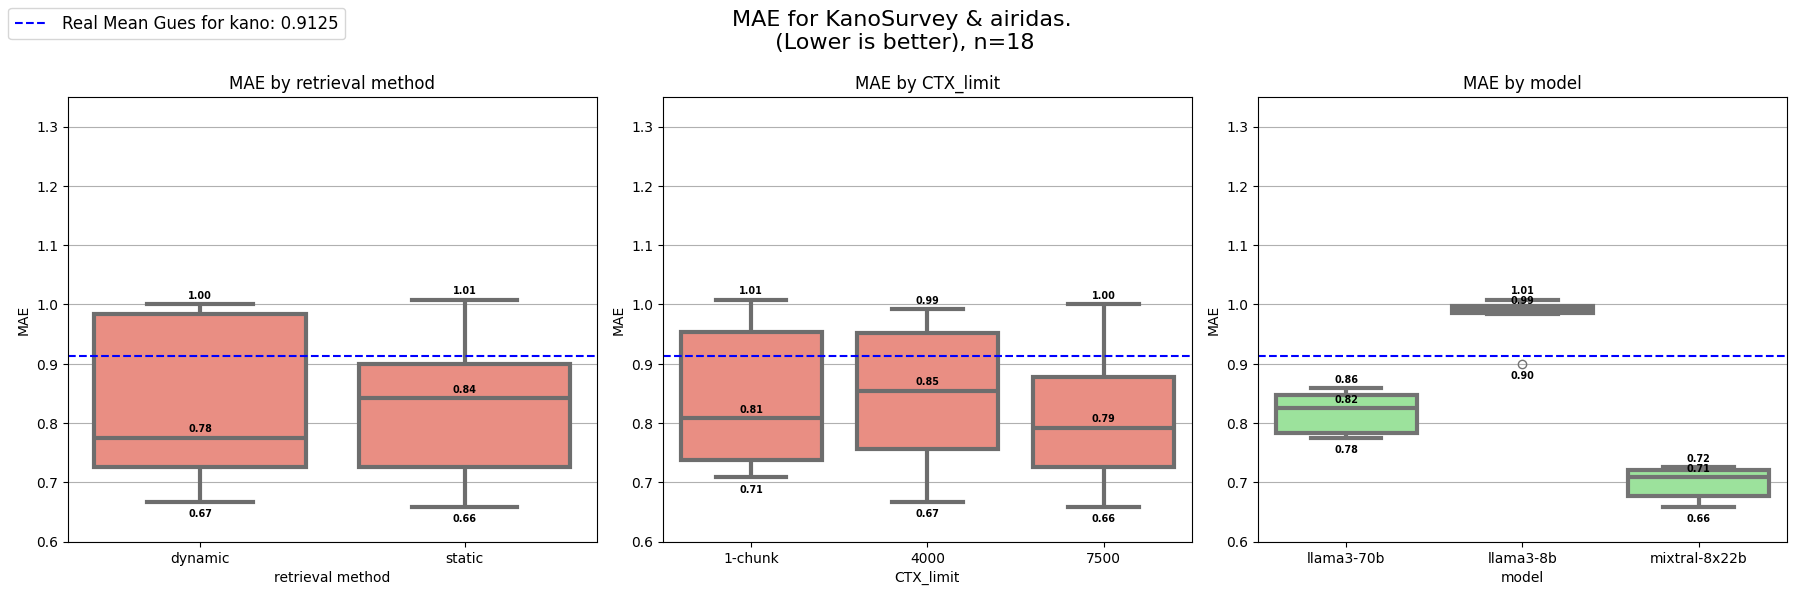

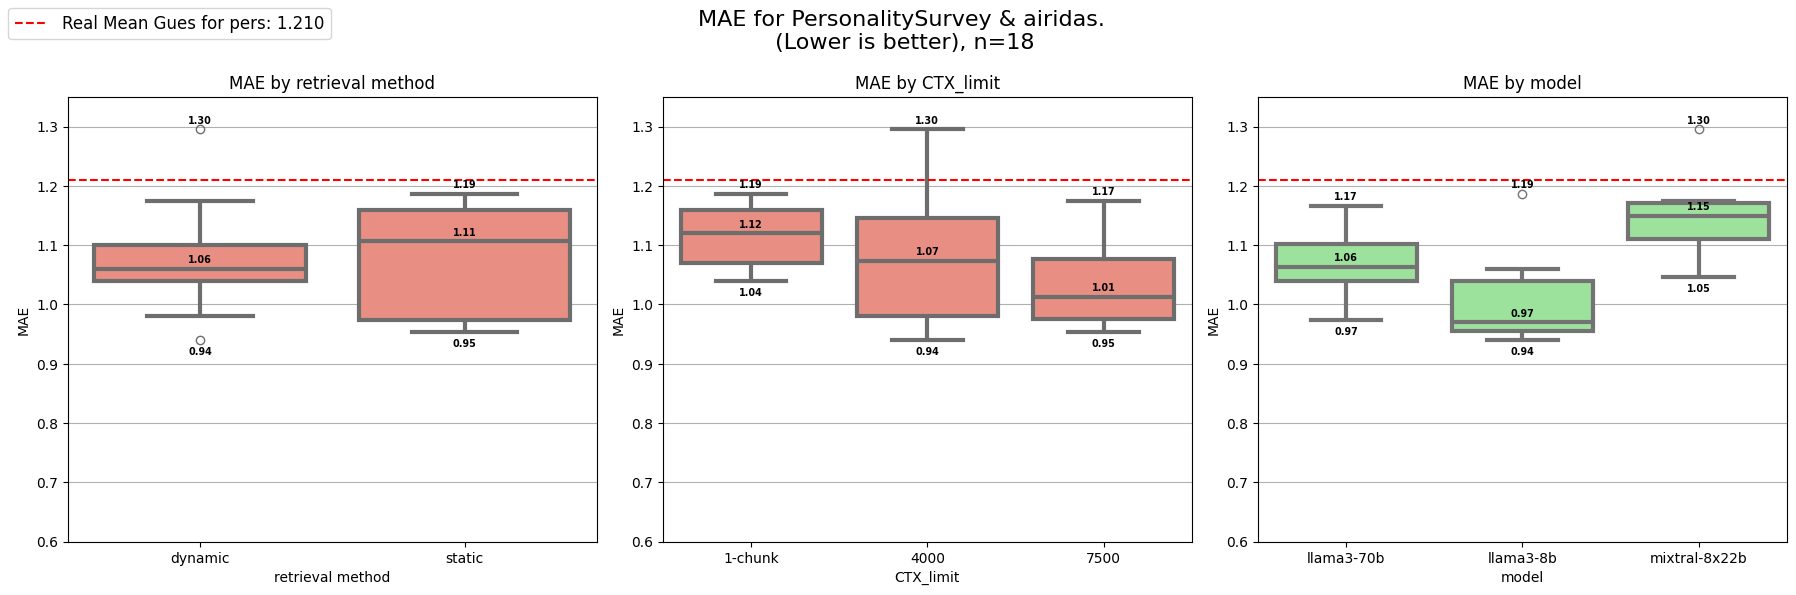

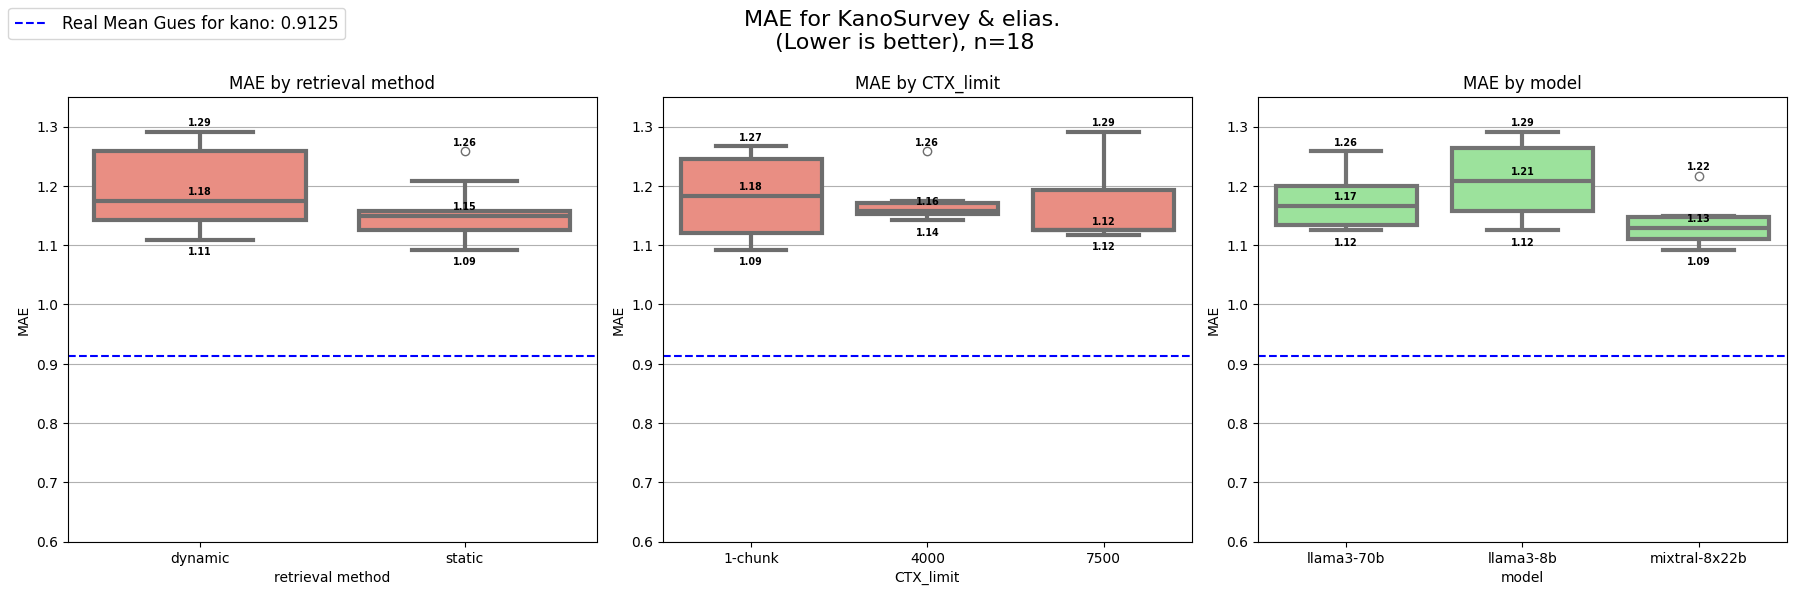

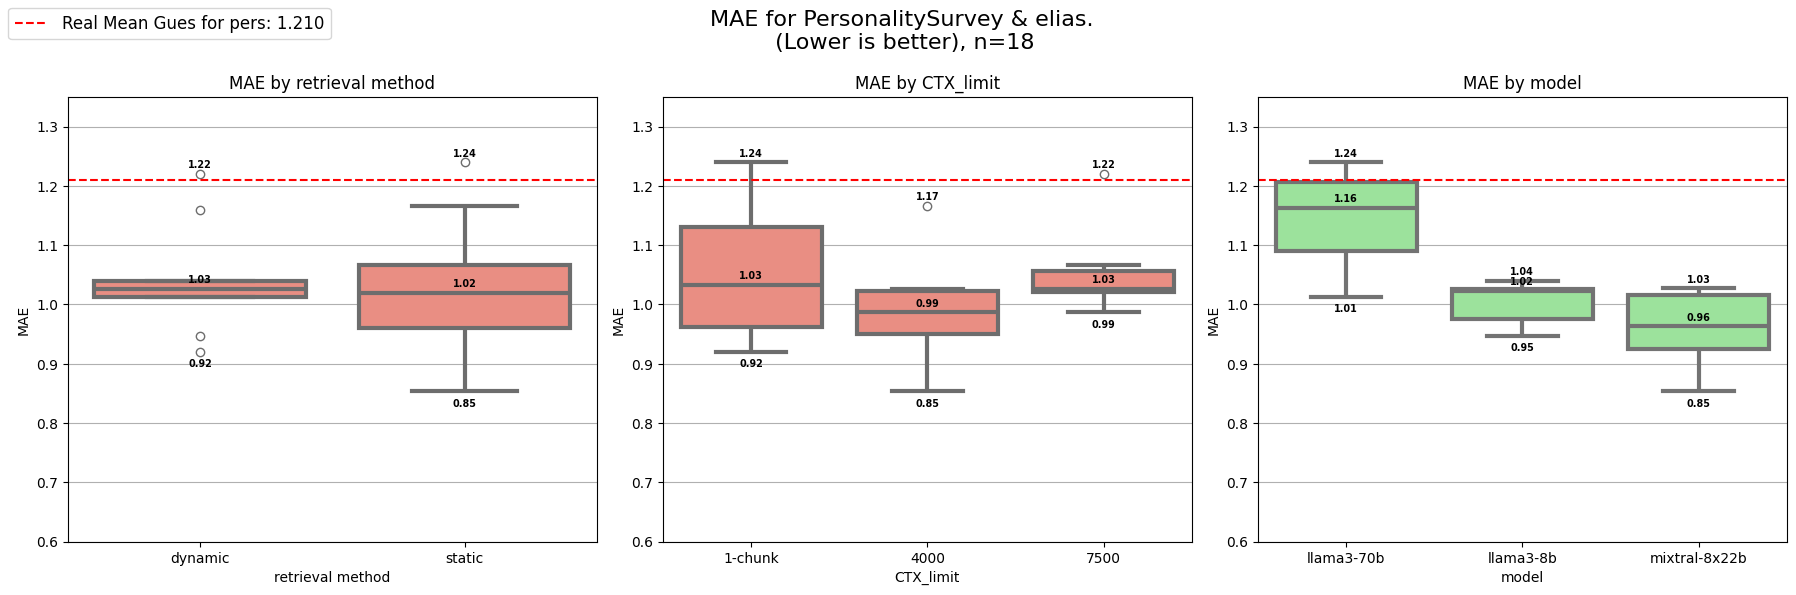

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named `df`
for subj in ['airidas', 'elias']:
    for srv in ['KanoSurvey', "PersonalitySurvey"]:
        plt.figure(figsize=(18, 10))
        filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == srv) & (dfg['SUBJECT'] == subj)]
        parameters = ['retrieval method', 'CTX_limit', 'model']
        
        lines, labels = [], [] # To keep track of legend handles
        for i, param in enumerate(parameters, 1):
            ax = plt.subplot(2, 3, i)
            ax.grid(True)
            
            color = getGlobalColorByParam(param)
            sns.boxplot(x=param, y='MAE', color=color, data=filtered_df, ax=ax, linewidth=3)
            #### Extract median values and their positions ######
            grouped_data = filtered_df.groupby(param)['MAE']
            mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
            pos = range(len(mins))  # Positions of the boxplots
            vertical_offset = 0.01  # offset each text to avoid clutter
            for tick in pos:
                ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
            #####################################################
            
            plt.title(f'MAE by {param}')
            plt.ylabel('MAE')
            plt.xticks(rotation=0) 
            plt.ylim(bottom=0.6, top=1.35) 

            # Adding horizontal lines for guidelines
            if srv == 'KanoSurvey':
                lines_new = [plt.axhline(y=0.9125, color='blue', linestyle='--')]
                labels_new = ['Real Mean Gues for kano: 0.9125']
            elif srv == 'PersonalitySurvey':
                lines_new = [plt.axhline(y=1.210, color='red', linestyle='--')]
                labels_new = ['Real Mean Gues for pers: 1.210']
            else:
                lines_new = [plt.axhline(y=0.9125, color='blue', linestyle='--'), plt.axhline(y=1.210, color='red', linestyle='--')]
                labels_new = ['Real Mean Guess for Kano: 0.9125', 'Real Mean Guess for pers: 1.210']
            
            if i == 1:  # Only need these once for creating the legend
                lines.extend(lines_new)
                labels.extend(labels_new)
        plt.tight_layout()
        plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=12)
        plt.suptitle(f'MAE for {srv} & {subj}.\n (Lower is better), n={len(filtered_df)}', y=1.05, fontsize=16)
        plt.show()

For KanoSurvey and airidas and mixtral-8x22b


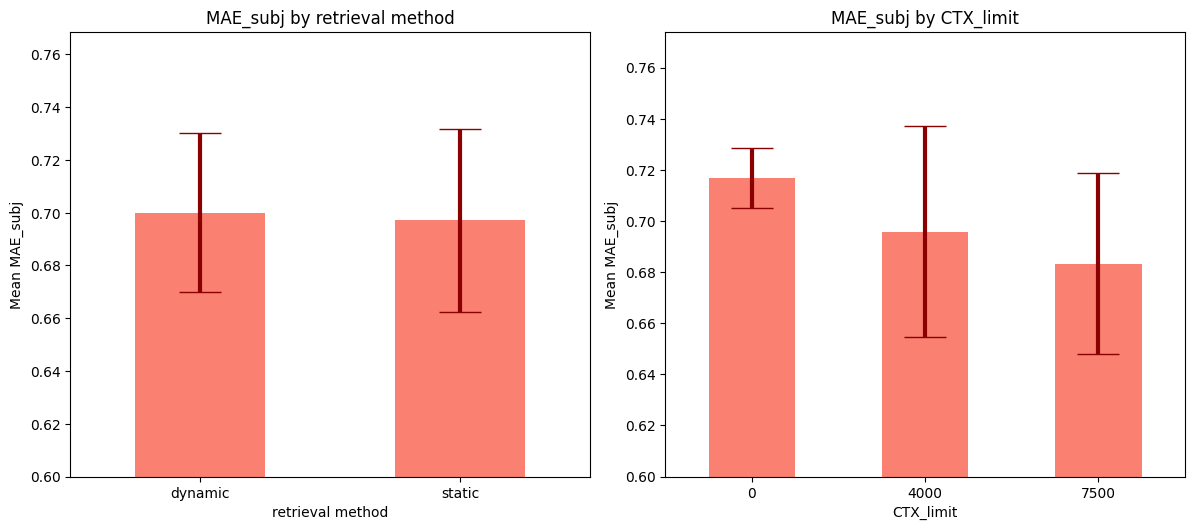

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named `df`
filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == "KanoSurvey") & (dfg['SUBJECT'] == "airidas") & (dfg['model'] == "mixtral-8x22b")]
parameters = ['retrieval method', 'CTX_limit']
plt.figure(figsize=(18, 10))

print(f'For KanoSurvey and airidas and mixtral-8x22b')
for i, param in enumerate(parameters, 1):
    plt.subplot(2, 3, i)

    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters


    # Group by the parameter and calculate mean MAE_subj
    stds = filtered_df.groupby(param)['MAE_subj'].std()
    means = filtered_df.groupby(param)['MAE_subj'].mean()
    means.plot(kind='bar', color=colors, yerr=stds, error_kw={'capsize': 15, 'ecolor': 'darkred', 'elinewidth': 3, 'alpha': 1})
    plt.title(f'MAE_subj by {param}')
    plt.ylabel('Mean MAE_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=0.6)  # Set the minimum y-axis limit

plt.tight_layout()
plt.show()

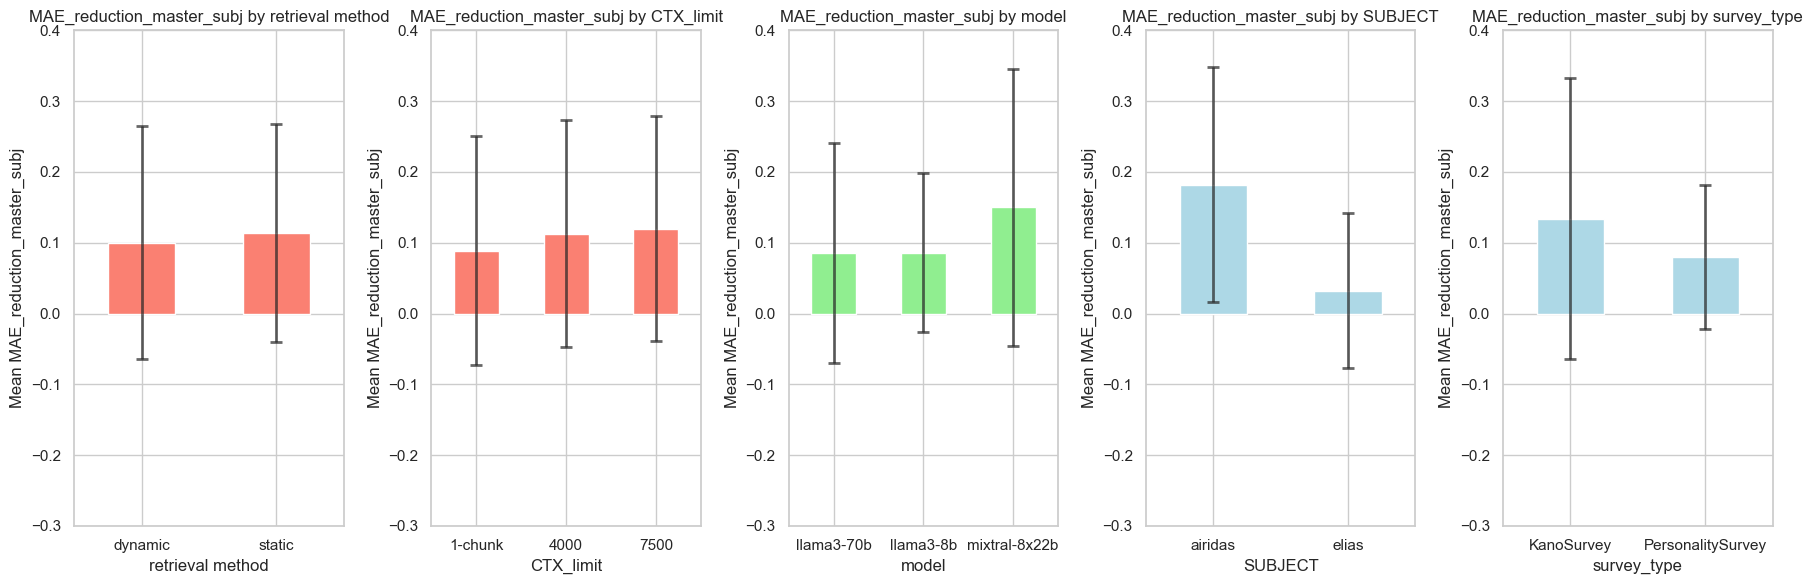

In [235]:
filtered_df = dfg[dfg['is_base'] == False]

# Define parameters of interest
parameters = ['retrieval method', 'CTX_limit', 'model',  'SUBJECT', 'survey_type',]

# Create a figure to hold the plots
plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

# Loop through each parameter and create a bar chart
for i, param in enumerate(parameters, 1):
    plt.subplot(1, 5, i)  # Horizontal layout of plots
    # Group by the parameter
    group = filtered_df.groupby(param)['MAE_reduction_master_subj']
    means = group.mean()
    errors = group.std()  # Calculate standard deviation for error bars

    # Assign specific colors for "SUBJECT" and "survey_type"
    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters

    means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})
    plt.title(f'MAE_reduction_master_subj by {param}')
    plt.ylabel('Mean MAE_reduction_master_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=-0.3, top=0.4) # Expecting negative values so setting lower y limit to -1

plt.tight_layout()
plt.show()

### new dMAE

#### boi

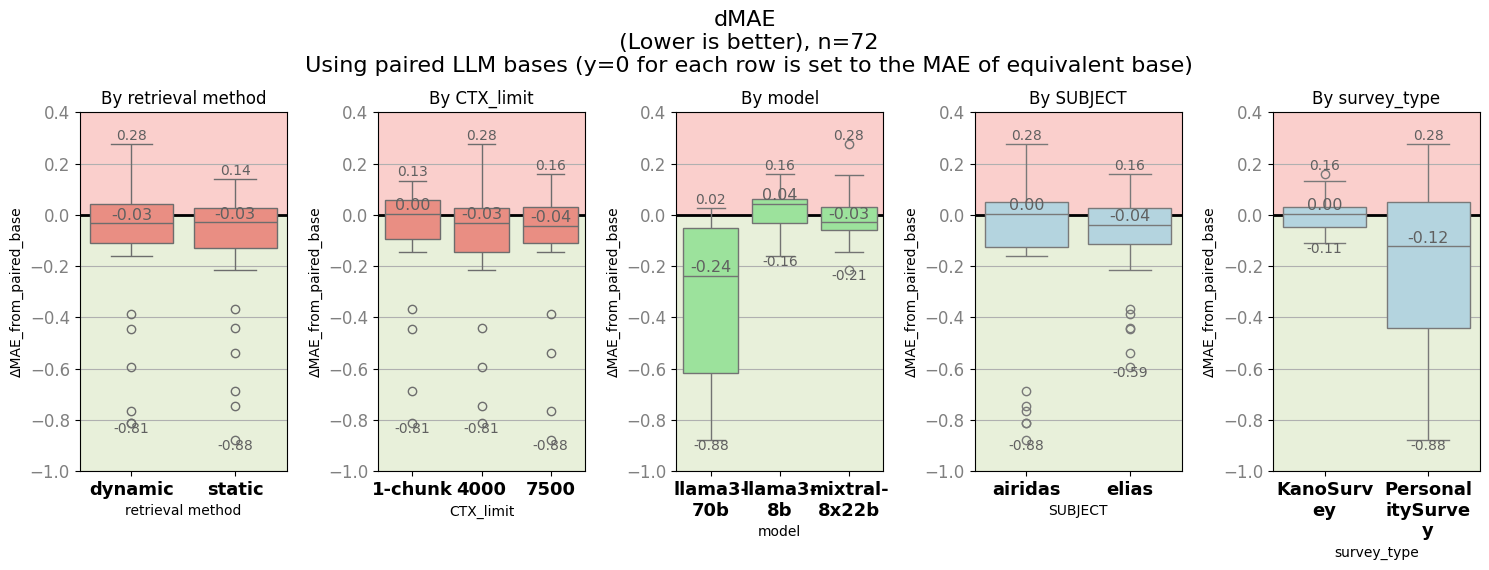

In [114]:
plt.figure(figsize=(15, 5))
filtered_df = dfg[dfg['is_base'] == False]
parameters = ['retrieval method', 'CTX_limit', 'model',  'SUBJECT', 'survey_type',]
base_val = global_base_scores["master"]
base_name = "master"
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=base_val, base_name=base_name).items():
        dfg.at[index, key] = value

lines, labels = [], [] # To keep track of legend handles
for i, param in enumerate(parameters):
    ax = plt.subplot(1, 5, i + 1)  # Horizontal layout of plots
    ax.grid(True)
    ax.axhline(0, color='black', linewidth=2) 
    ax.axhspan(-1, 0, color='#dcedc1', alpha=0.5)  # Stylish green background below zero
    ax.axhspan(0, 0.5, color='#ffaaa5', alpha=0.5)   # Stylish red background above zero    # Background color above zero
    color = getGlobalColorByParam(param)
    #### Extract median values and their positions ######
    grouped_data = filtered_df.groupby(param)['dMAE']
    mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
    pos = range(len(mins))  # Positions of the boxplots
    vertical_offset = 0.01  # offset each text to avoid clutter
    
    # for tick in pos:
    #     ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
    #     ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
    #     ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
    #####################################################
    sns.boxplot(x=param, y=f'dMAE', color=color, data=filtered_df)
    plt.title(f'By {param}')
    plt.ylabel(f'ΔMAE_from_paired_base')
    plt.xticks(rotation=0) 
    plt.ylim(bottom=-0.95, top=0.32)  # Adjust y-limits


    super_format_ax(ax)
    add_value_texts(grouped_data, ax)
plt.tight_layout()
plt.suptitle(f'dMAE\n (Lower is better), n={len(filtered_df)}\n Using paired LLM bases (y=0 for each row is set to the MAE of equivalent base)', y=1.13, fontsize=16) 
plt.show()

#### four

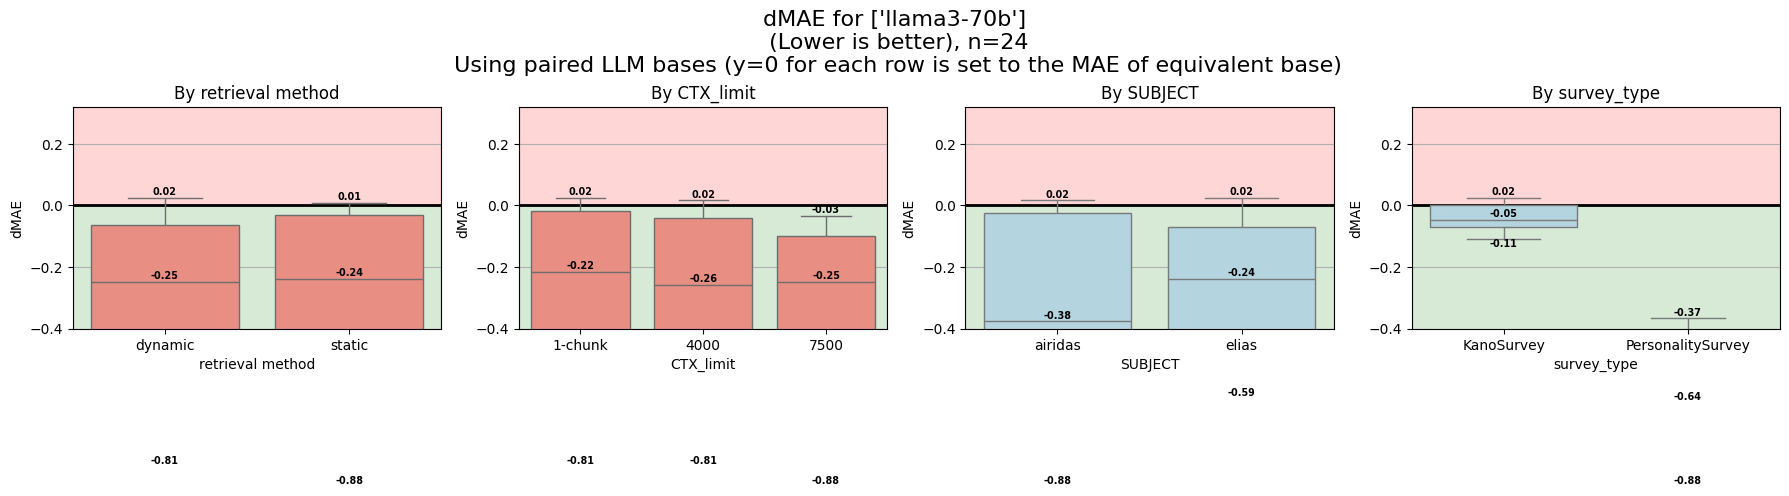

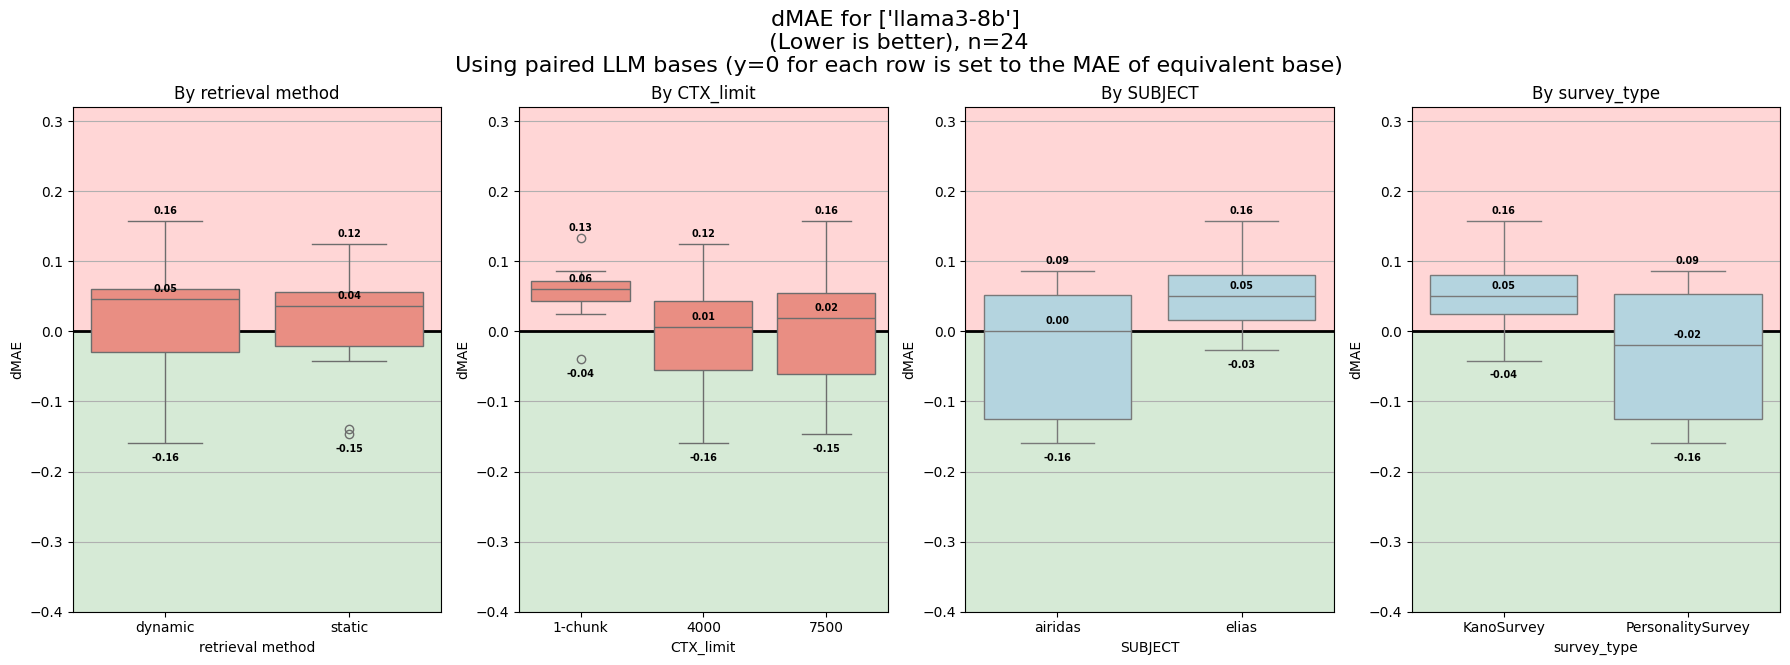

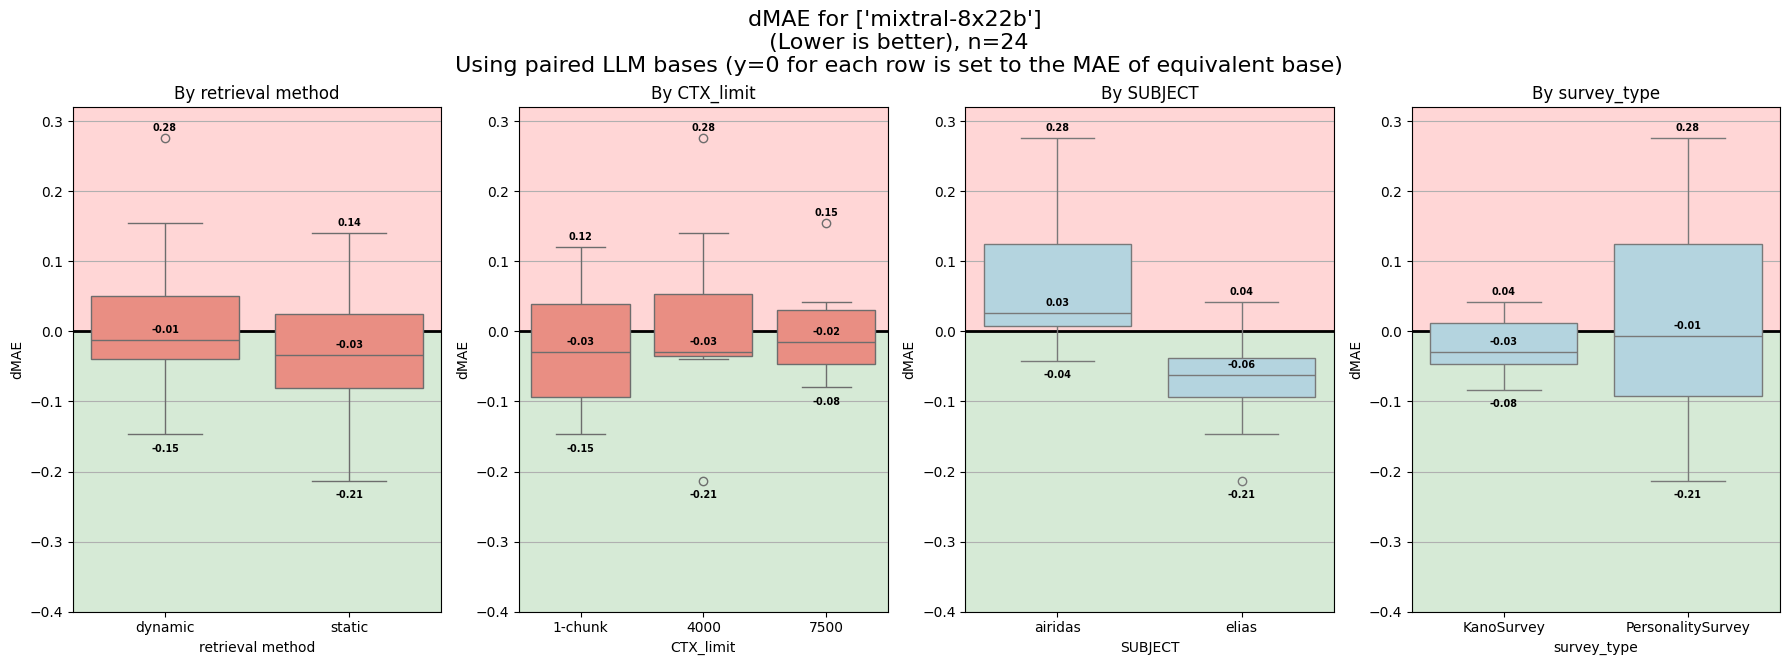

In [115]:
parameters = ['retrieval method', 'CTX_limit', 'SUBJECT', 'survey_type',]
for models in [['llama3-70b'], ['llama3-8b'], ['mixtral-8x22b']]:
    plt.figure(figsize=(18, 6))
    filtered_df = dfg[(dfg['is_base'] == False) & (dfg['model'].isin(models))]
    for i, param in enumerate(parameters):
        ax = plt.subplot(1, 4, i + 1)  # Horizontal layout of plots
        ax.grid(True)
        ax.axhline(0, color='black', linewidth=2) 
        ax.axhspan(-1, 0, color='green', alpha=0.16)  # Stylish green background below zero
        ax.axhspan(0, 0.32, color='red', alpha=0.16)   # Stylish red background above zero    # Background color above zero
        color = getGlobalColorByParam(param)
        #### Extract median values and their positions ######
        grouped_data = filtered_df.groupby(param)['dMAE']
        mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
        pos = range(len(mins))  # Positions of the boxplots
        vertical_offset = 0.01  # offset each text to avoid clutter
        for tick in pos:
            ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
            ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
            ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
        #####################################################
        sns.boxplot(x=param, y=f'dMAE', color=color, data=filtered_df)
        plt.title(f'By {param}')
        plt.ylabel(f'dMAE')
        plt.xticks(rotation=0) 
        plt.ylim(bottom=-0.3, top=0.32)  # Adjust y-limits
    plt.tight_layout()
    plt.suptitle(f'dMAE for {models}\n (Lower is better), n={len(filtered_df)}\n Using paired LLM bases (y=0 for each row is set to the MAE of equivalent base)', y=1.10, fontsize=16) 
    plt.show()

#### tthree musketers (by subj)

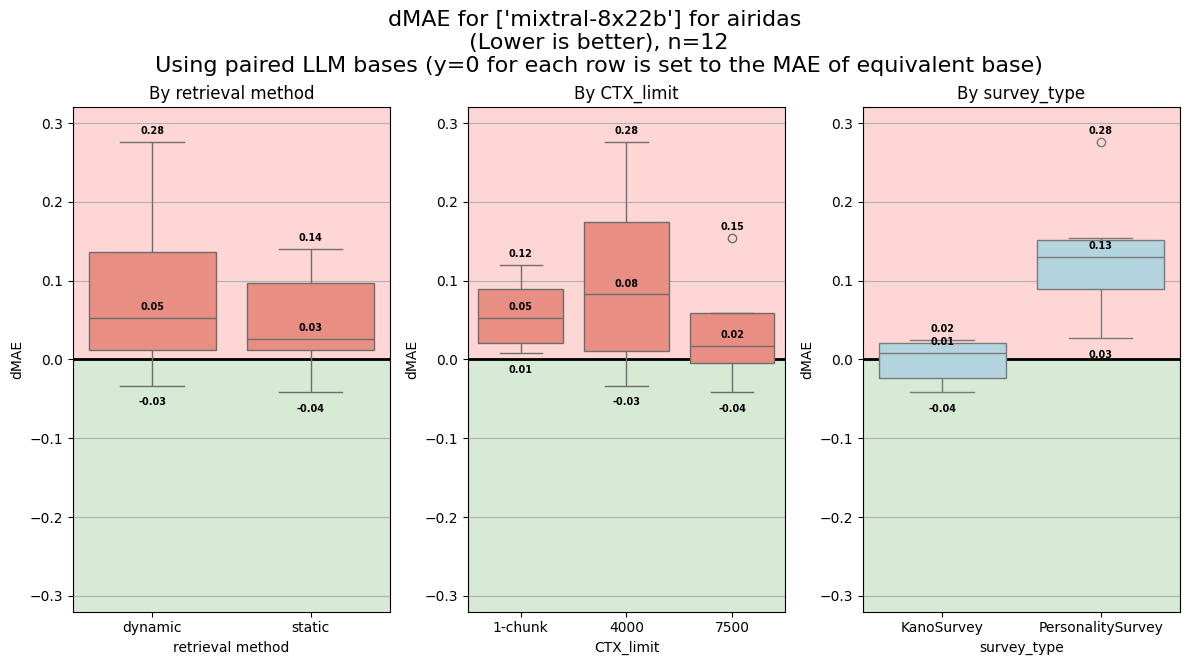

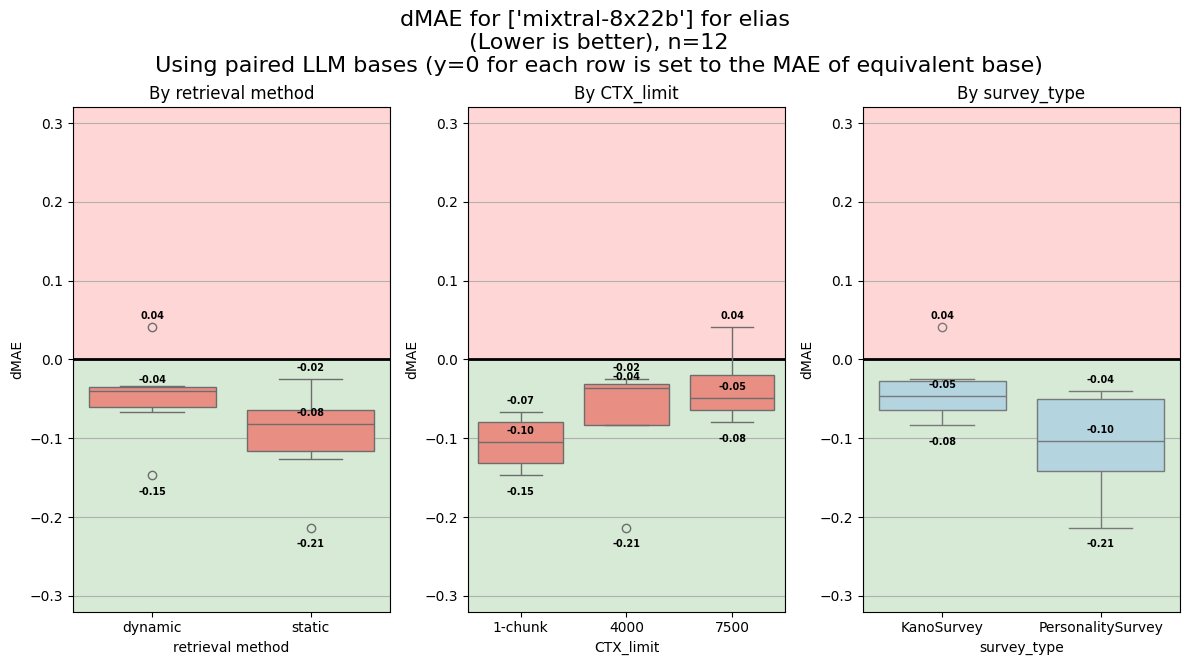

In [57]:
parameters = ['retrieval method', 'CTX_limit', 'survey_type']
for subj in ['airidas', 'elias']:
    for models in [['mixtral-8x22b']]:
        plt.figure(figsize=(12, 6))
        filtered_df = dfg[(dfg['is_base'] == False) & (dfg['model'].isin(models)) & (dfg['SUBJECT'] == (subj))]
        for i, param in enumerate(parameters):
            ax = plt.subplot(1, 3, i + 1)  # Horizontal layout of plots
            ax.grid(True)
            ax.axhline(0, color='black', linewidth=2) 
            ax.axhspan(-1, 0, color='green', alpha=0.16)  # Stylish green background below zero
            ax.axhspan(0, 0.32, color='red', alpha=0.16)   # Stylish red background above zero    # Background color above zero
            color = getGlobalColorByParam(param)
            #### Extract median values and their positions ######
            grouped_data = filtered_df.groupby(param)['dMAE']
            mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
            pos = range(len(mins))  # Positions of the boxplots
            vertical_offset = 0.01  # offset each text to avoid clutter
            for tick in pos:
                ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
            #####################################################
            sns.boxplot(x=param, y=f'dMAE', color=color, data=filtered_df)
            plt.title(f'By {param}')
            plt.ylabel(f'dMAE')
            plt.xticks(rotation=0) 
            plt.ylim(bottom=-0.32, top=0.32)  # Adjust y-limits
        plt.tight_layout()
        plt.suptitle(f'dMAE for {models} for {subj}\n (Lower is better), n={len(filtered_df)}\n Using paired LLM bases (y=0 for each row is set to the MAE of equivalent base)', y=1.10, fontsize=16) 
        plt.show()

#### tthree musketers

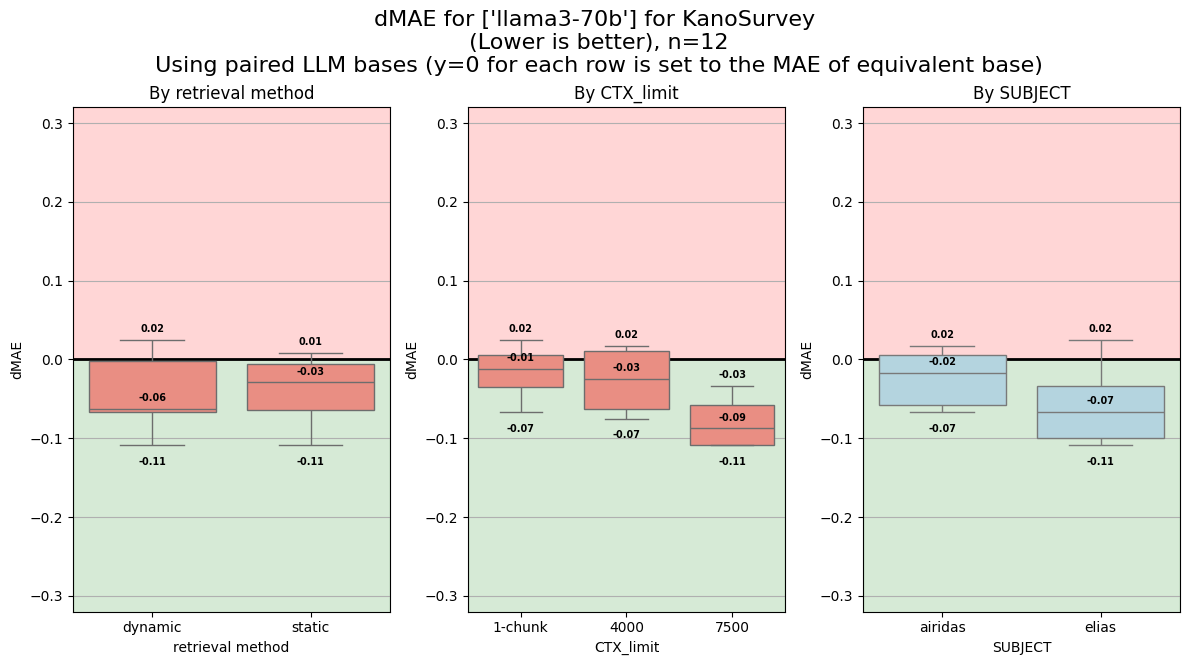

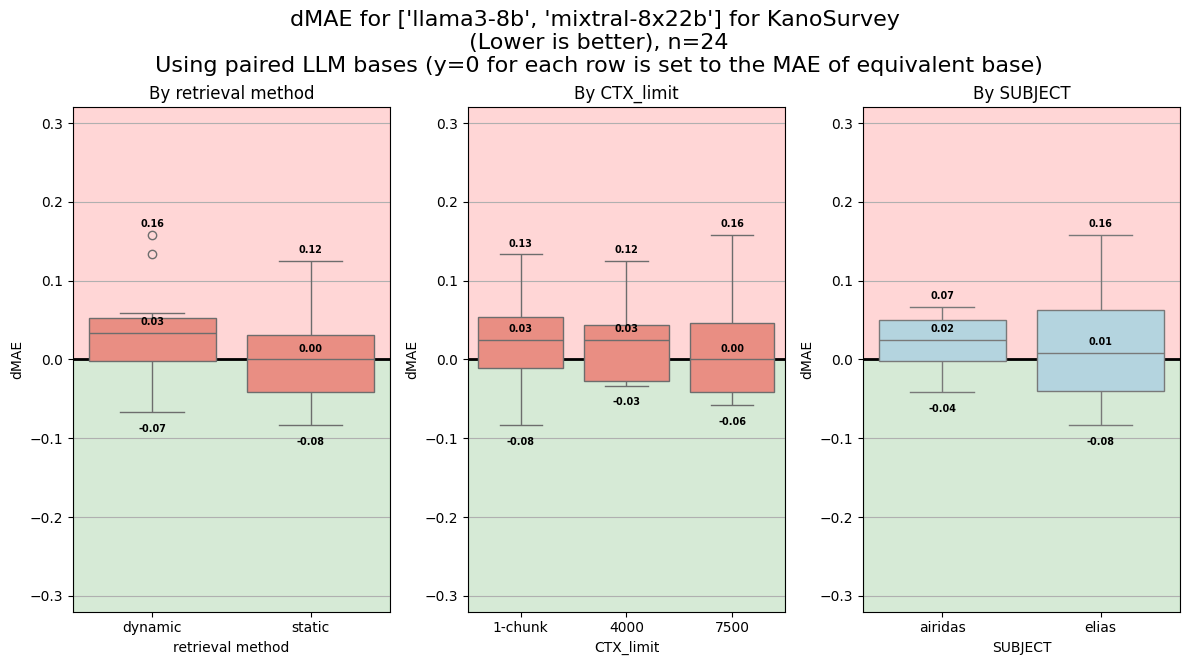

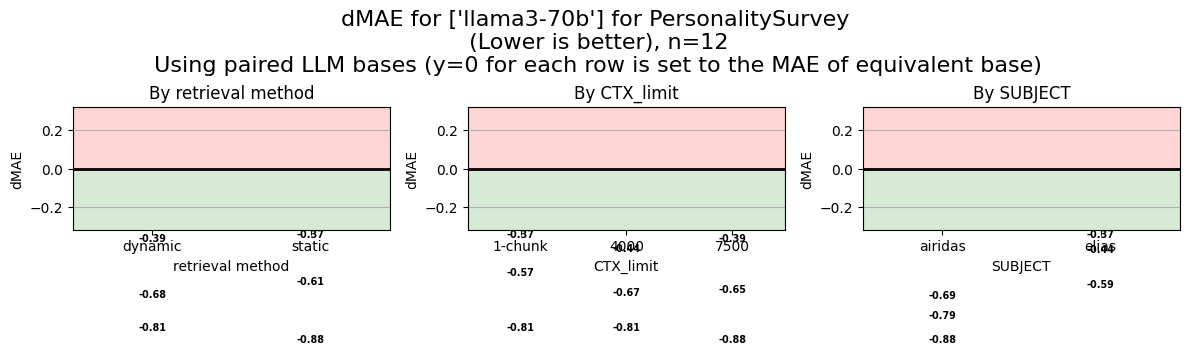

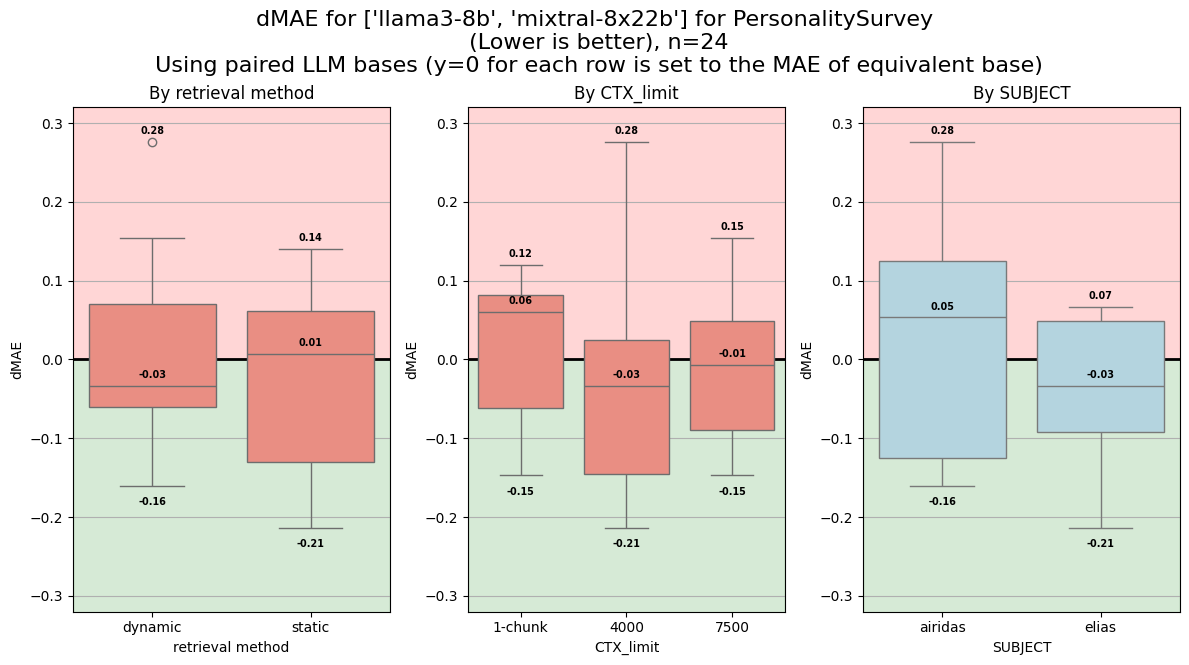

In [48]:
parameters = ['retrieval method', 'CTX_limit', 'SUBJECT']
for srv in ['KanoSurvey', "PersonalitySurvey"]:
    for models in [['mixtral-8x22b']]:
        plt.figure(figsize=(12, 6))
        filtered_df = dfg[(dfg['is_base'] == False) & (dfg['model'].isin(models)) & (dfg['survey_type'] == (srv))]
        for i, param in enumerate(parameters):
            ax = plt.subplot(1, 3, i + 1)  # Horizontal layout of plots
            ax.grid(True)
            ax.axhline(0, color='black', linewidth=2) 
            ax.axhspan(-1, 0, color='green', alpha=0.16)  # Stylish green background below zero
            ax.axhspan(0, 0.32, color='red', alpha=0.16)   # Stylish red background above zero    # Background color above zero
            color = getGlobalColorByParam(param)
            #### Extract median values and their positions ######
            grouped_data = filtered_df.groupby(param)['dMAE']
            mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
            pos = range(len(mins))  # Positions of the boxplots
            vertical_offset = 0.01  # offset each text to avoid clutter
            for tick in pos:
                ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
            #####################################################
            sns.boxplot(x=param, y=f'dMAE', color=color, data=filtered_df)
            plt.title(f'By {param}')
            plt.ylabel(f'dMAE')
            plt.xticks(rotation=0) 
            plt.ylim(bottom=-0.32, top=0.32)  # Adjust y-limits
        plt.tight_layout()
        plt.suptitle(f'dMAE for {models} for {srv}\n (Lower is better), n={len(filtered_df)}\n Using paired LLM bases (y=0 for each row is set to the MAE of equivalent base)', y=1.10, fontsize=16) 
        plt.show()

#### Two Gangsters

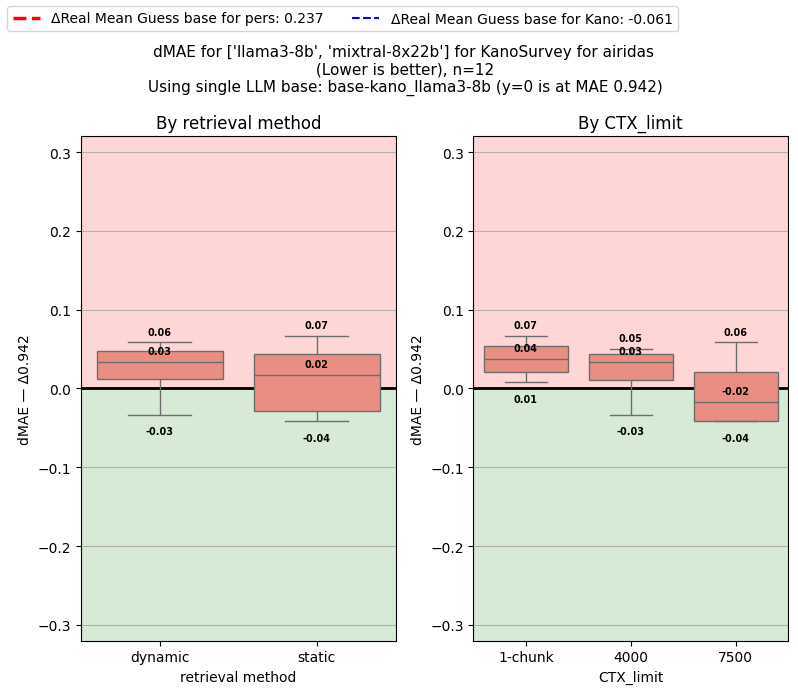

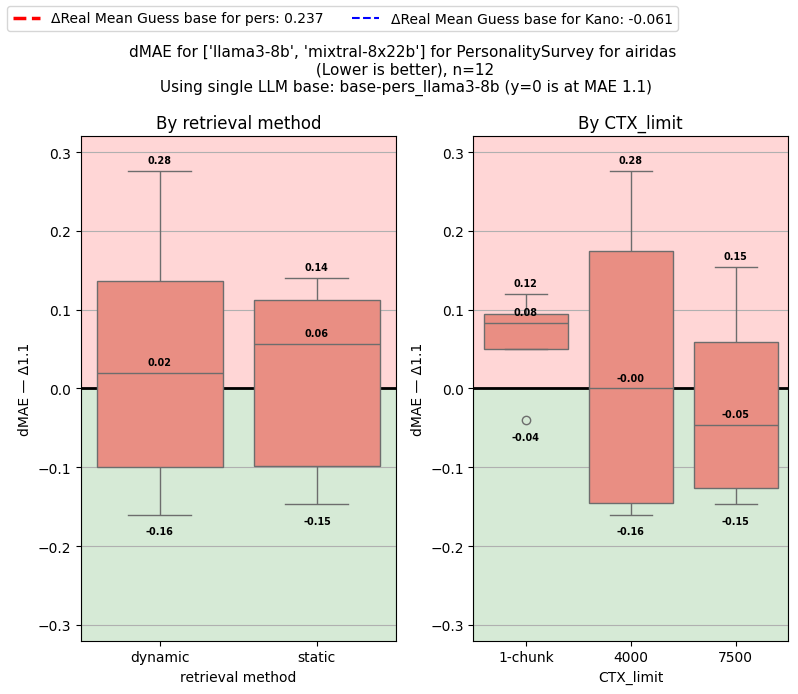

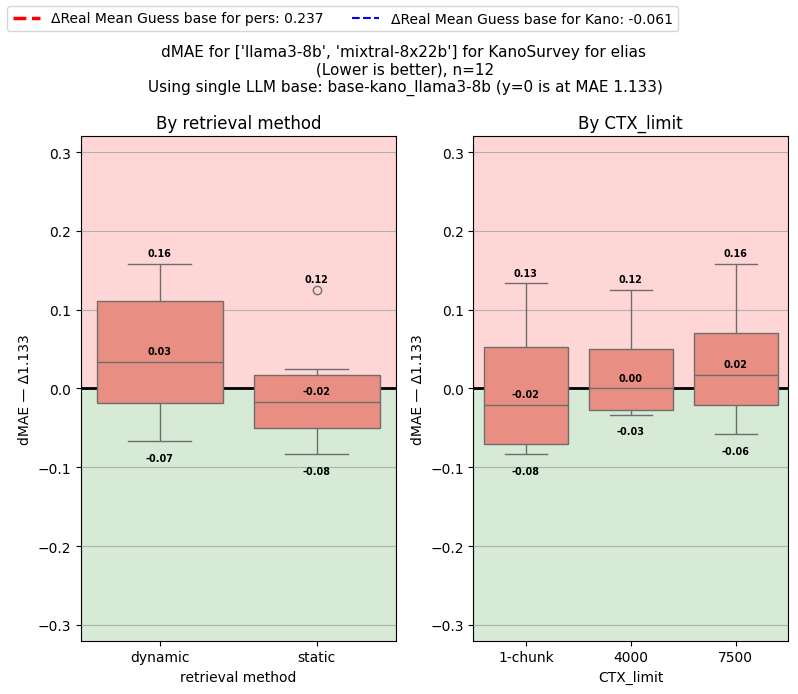

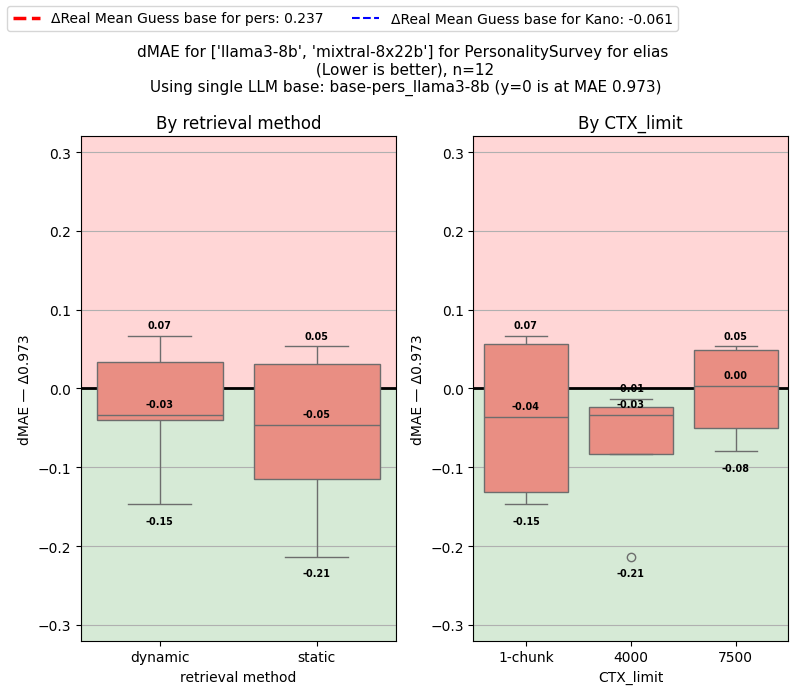

In [108]:
parameters = ['retrieval method', 'CTX_limit']
for subj in ['airidas', 'elias']:
    for srv in ['KanoSurvey', "PersonalitySurvey"]:
        for models in [["llama3-8b",'mixtral-8x22b']]:
            plt.figure(figsize=(8, 6))
            filtered_df = dfg[(dfg['is_base'] == False) & (dfg['model'].isin(models)) & (dfg['survey_type'] == (srv)) & (dfg['SUBJECT'] == (subj))]
            base_sign = filtered_df.iloc[0]["base_sim_signature"]
            base_name = utils.unclutterSignature(base_sign)
            if subj == 'airidas': base_val = dfg[(dfg['sim_signature'] == base_sign)]['MAE_airi'].mean()
            else: base_val = dfg[(dfg['sim_signature'] == base_sign)]['MAE_eli'].mean()

            lines, labels = [], [] # To keep track of legend handles
            for i, param in enumerate(parameters):
                ax = plt.subplot(1, 2, i + 1)  # Horizontal layout of plots
                ax.grid(True)
                ax.axhline(0, color='black', linewidth=2) 
                ax.axhspan(-1, 0, color='green', alpha=0.16)  # Stylish green background below zero
                ax.axhspan(0, 0.32, color='red', alpha=0.16)   # Stylish red background above zero    # Background color above zero
                color = getGlobalColorByParam(param)
                #### Extract median values and their positions ######
                grouped_data = filtered_df.groupby(param)['dMAE']
                mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
                pos = range(len(mins))  # Positions of the boxplots
                vertical_offset = 0.01  # offset each text to avoid clutter
                for tick in pos:
                    ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                    ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                    ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                #####################################################
                sns.boxplot(x=param, y=f'dMAE', color=color, data=filtered_df)
                plt.title(f'By {param}')
                plt.ylabel(f'dMAE — Δ{round(base_val,3)}')
                plt.xticks(rotation=0) 
                plt.ylim(bottom=-0.32, top=0.32)  # Adjust y-limits
                
                if len(models[0]) < 2:
                    if srv == 'KanoSurvey':
                        lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--', linewidth=2.5), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
                        labels_new = [f'ΔReal Mean Guess base for kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']

                    elif srv == 'PersonalitySurvey':
                        lines_new = [plt.axhline(y=1.210 - base_val, color='red', linestyle='--', linewidth=2.5), plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--')]
                        labels_new = [f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}',f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}']
                    else:
                        lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--'), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
                        labels_new = [f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']

                if i == 1:  # Only need these once for creating the legend
                    lines.extend(lines_new)
                    labels.extend(labels_new)

            plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=10)
            plt.tight_layout()
            plt.suptitle(f'\n\ndMAE for {models} for {srv} for {subj}\n (Lower is better), n={len(filtered_df)}\n Using single LLM base: {base_name} (y=0 is at MAE {round(base_val,3)})', y=1.15, fontsize=11) 
            plt.show()

### Olv dMAE

#### boi

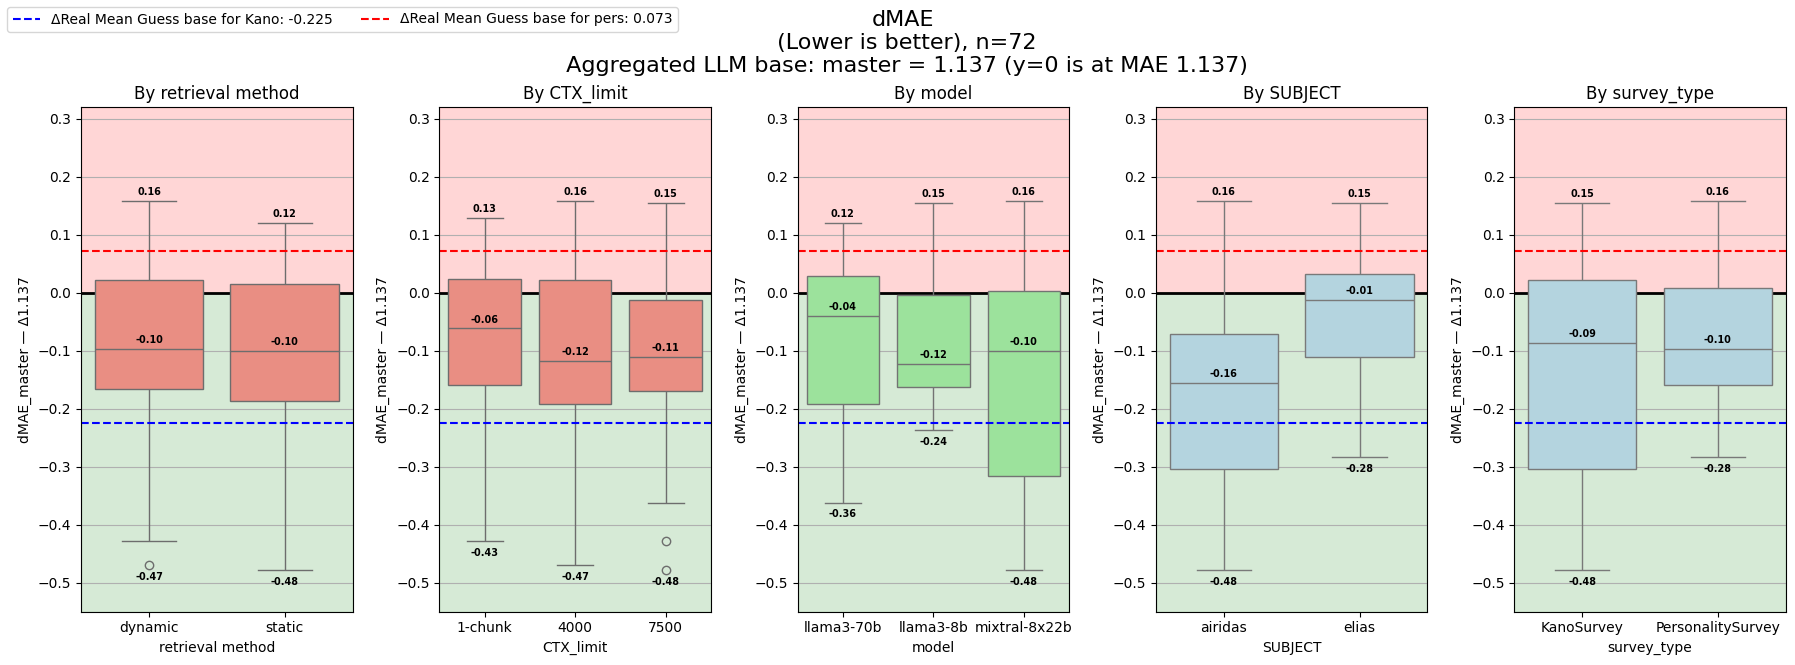

In [192]:
plt.figure(figsize=(18, 6))
filtered_df = dfg[dfg['is_base'] == False]
parameters = ['retrieval method', 'CTX_limit', 'model',  'SUBJECT', 'survey_type',]
base_val = global_base_scores["master"]
base_name = "master"
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=base_val, base_name=base_name).items():
        dfg.at[index, key] = value

lines, labels = [], [] # To keep track of legend handles
for i, param in enumerate(parameters):
    ax = plt.subplot(1, 5, i + 1)  # Horizontal layout of plots
    ax.grid(True)
    ax.axhline(0, color='black', linewidth=2) 
    ax.axhspan(-0.55, 0, color='green', alpha=0.16)  # Stylish green background below zero
    ax.axhspan(0, 0.32, color='red', alpha=0.16)   # Stylish red background above zero    # Background color above zero
    color = getGlobalColorByParam(param)
    #### Extract median values and their positions ######
    grouped_data = filtered_df.groupby(param)['dMAE_master']
    mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
    pos = range(len(mins))  # Positions of the boxplots
    vertical_offset = 0.01  # offset each text to avoid clutter
    for tick in pos:
        ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
        ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
        ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
    #####################################################
    sns.boxplot(x=param, y=f'dMAE_{base_name}', color=color, data=filtered_df)
    plt.title(f'By {param}')
    plt.ylabel(f'dMAE_{base_name} — Δ{round(base_val,3)}')
    plt.xticks(rotation=0) 
    plt.ylim(bottom=-0.55, top=0.32)  # Adjust y-limits

    lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--'), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
    labels_new = [f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']

    if i == 1:  # Only need these once for creating the legend
        lines.extend(lines_new)
        labels.extend(labels_new)

plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=10)
plt.tight_layout()
plt.suptitle(f'dMAE\n (Lower is better), n={len(filtered_df)}\n Aggregated LLM base: {base_name} = {round(base_val,3)} (y=0 is at MAE {round(base_val,3)})', y=1.10, fontsize=16) 
plt.show()

#### granular

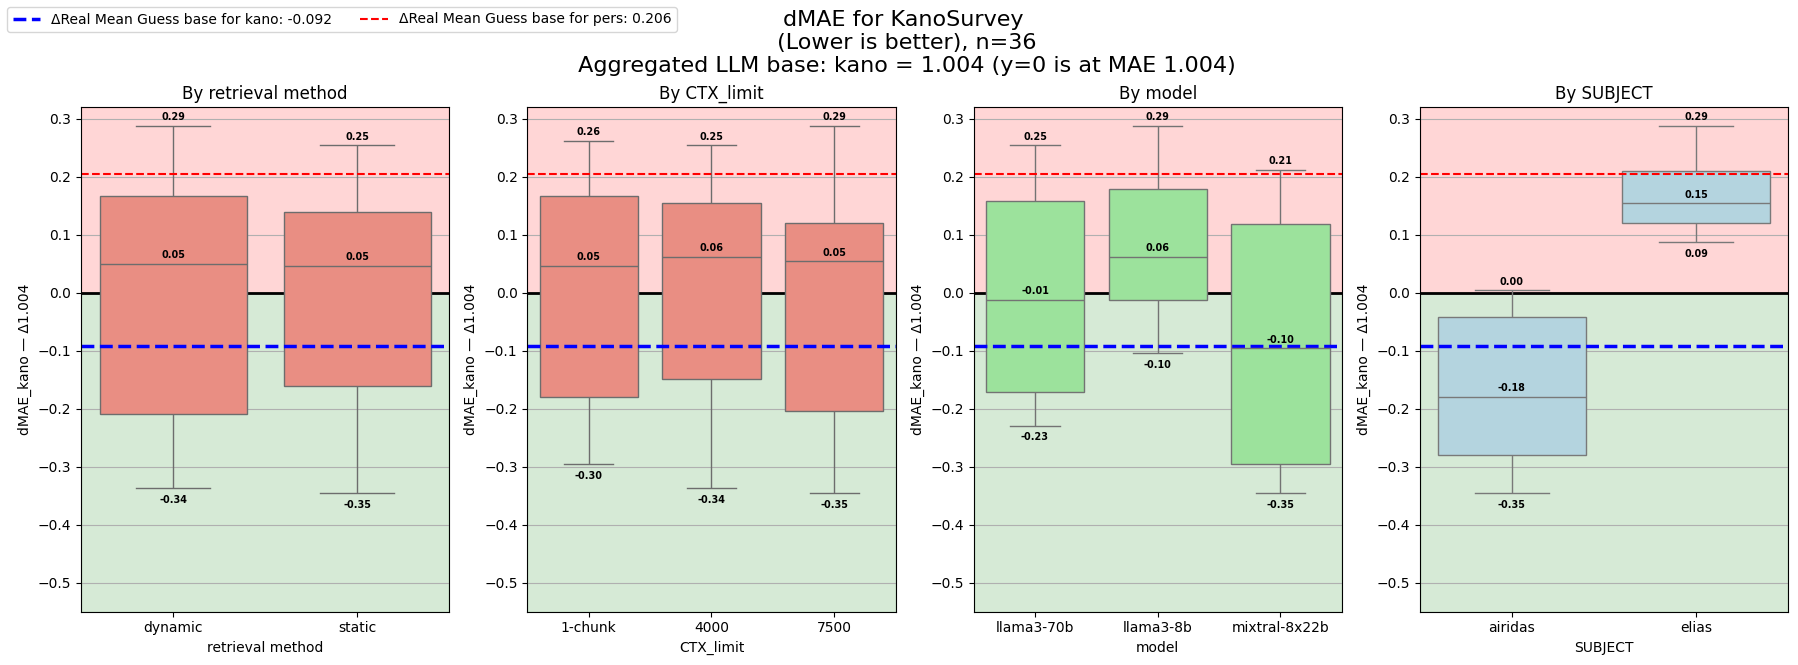

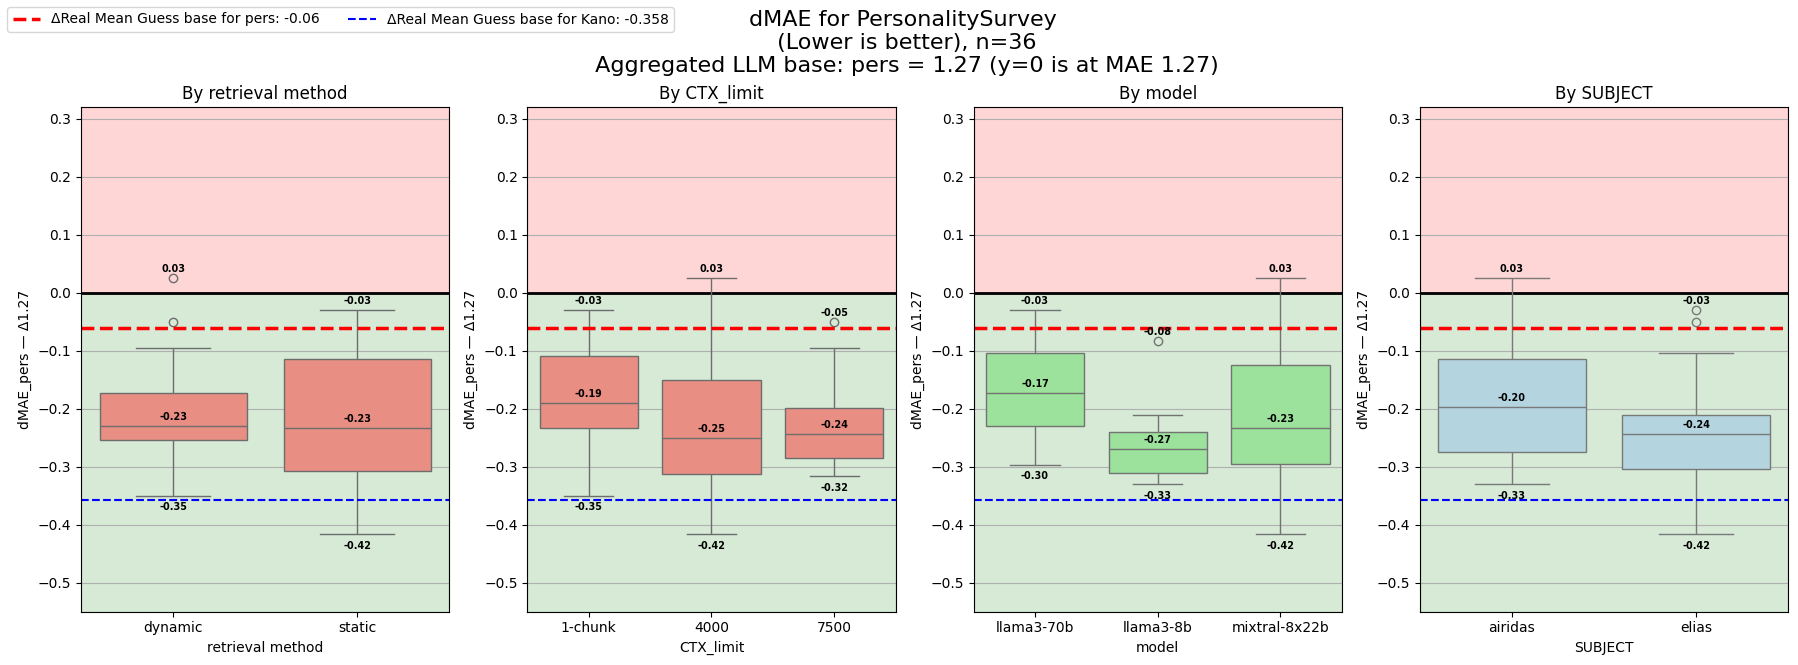

In [186]:
for srv in ['KanoSurvey', "PersonalitySurvey"]:
    base_val = global_base_scores["by_survey"][srv]
    base_name = srv[:4].lower()
    for index, sim_row in dfg.iterrows():
        for key, value in compare_to_custom_base(sim_row, dfg, base_val=base_val, base_name=base_name).items():
            dfg.at[index, key] = value

    filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == srv)]
    parameters = ['retrieval method', 'CTX_limit',  'model','SUBJECT',]
    plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts
    lines, labels = [], [] # To keep track of legend handles
    for i, param in enumerate(parameters):
        ax = plt.subplot(1, 4, i + 1)  # Horizontal layout of plots
        ax.grid(True)
        ax.axhline(0, color='black', linewidth=2) 
        ax.axhspan(-0.55, 0, color='green', alpha=0.16)  # Stylish green background below zero
        ax.axhspan(0, 0.32, color='red', alpha=0.16)   # Stylish red background above zero    # Background color above zero
        color = getGlobalColorByParam(param)
        #### Extract median values and their positions ######
        grouped_data = filtered_df.groupby(param)[f'dMAE_{base_name}']
        mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
        pos = range(len(mins))  # Positions of the boxplots
        vertical_offset = 0.01  # offset each text to avoid clutter
        for tick in pos:
            ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
            ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
            ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
        #####################################################
        sns.boxplot(x=param, y=f'dMAE_{base_name}', color=color, data=filtered_df)
        plt.title(f'By {param}')
        plt.ylabel(f'dMAE_{base_name} — Δ{round(base_val,3)}')
        plt.xticks(rotation=0) 
        plt.ylim(bottom=-0.55, top=0.32)  # Adjust y-limits
        
        if srv == 'KanoSurvey':
            lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--', linewidth=2.5), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
            labels_new = [f'ΔReal Mean Guess base for kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']

        elif srv == 'PersonalitySurvey':
            lines_new = [plt.axhline(y=1.210 - base_val, color='red', linestyle='--', linewidth=2.5), plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--')]
            labels_new = [f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}',f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}']
        else:
            lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--'), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
            labels_new = [f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']

        if i == 1:  # Only need these once for creating the legend
            lines.extend(lines_new)
            labels.extend(labels_new)
    
    plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=10)
    plt.tight_layout()
    plt.suptitle(f'dMAE for {srv}\n (Lower is better), n={len(filtered_df)}\n Aggregated LLM base: {base_name} = {round(base_val,3)} (y=0 is at MAE {round(base_val,3)})', y=1.10, fontsize=16) 
    plt.show()

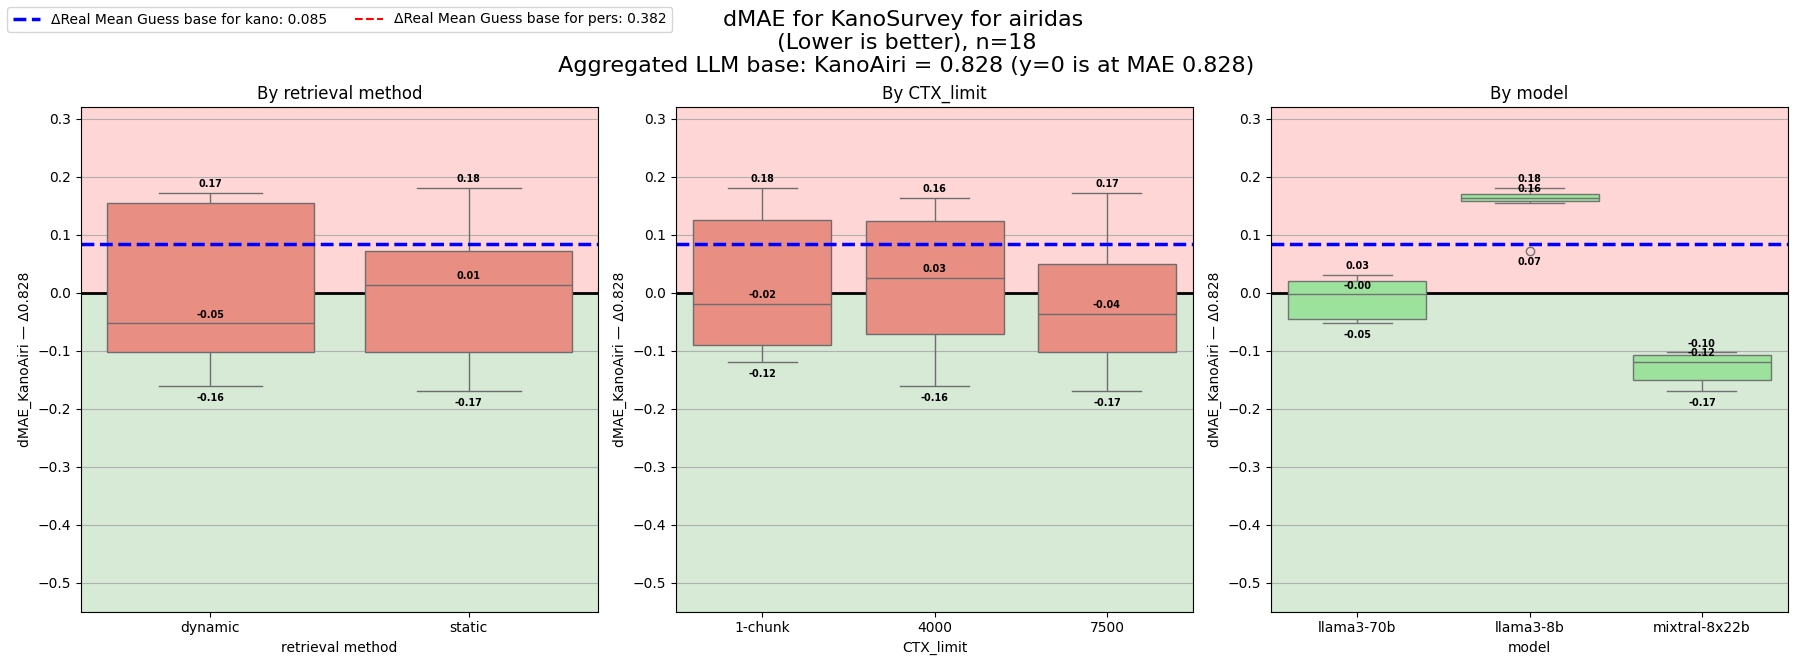

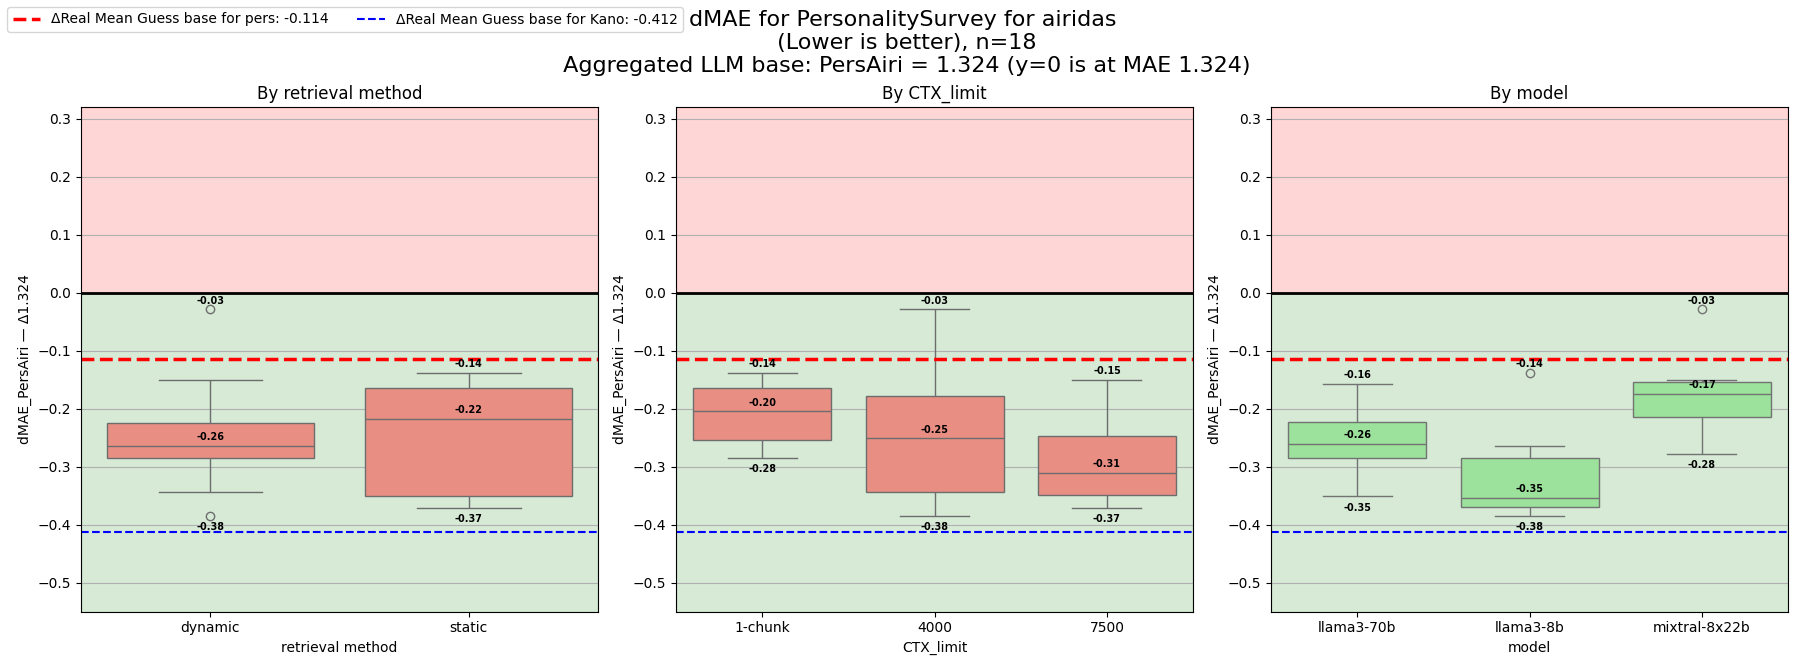

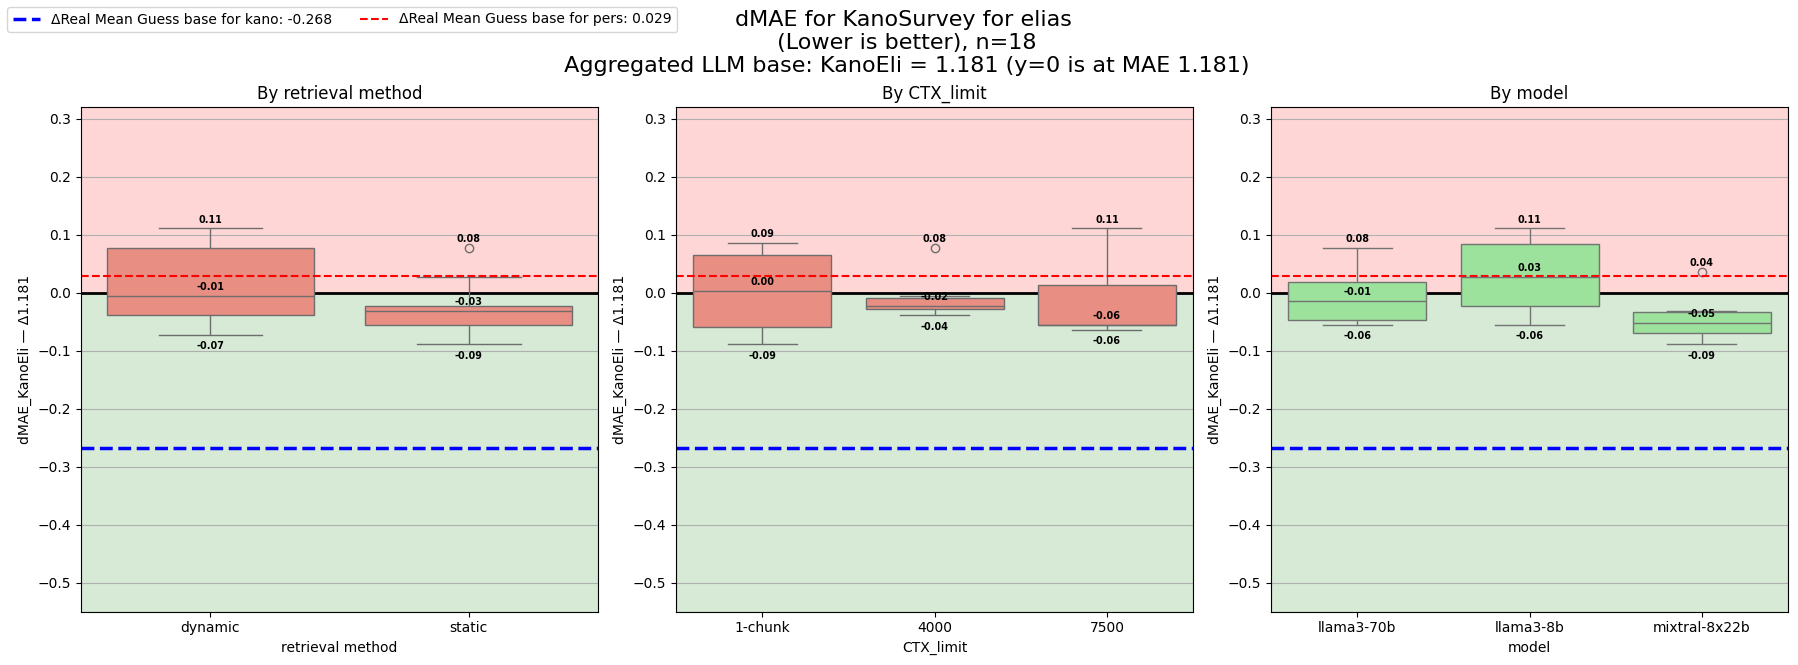

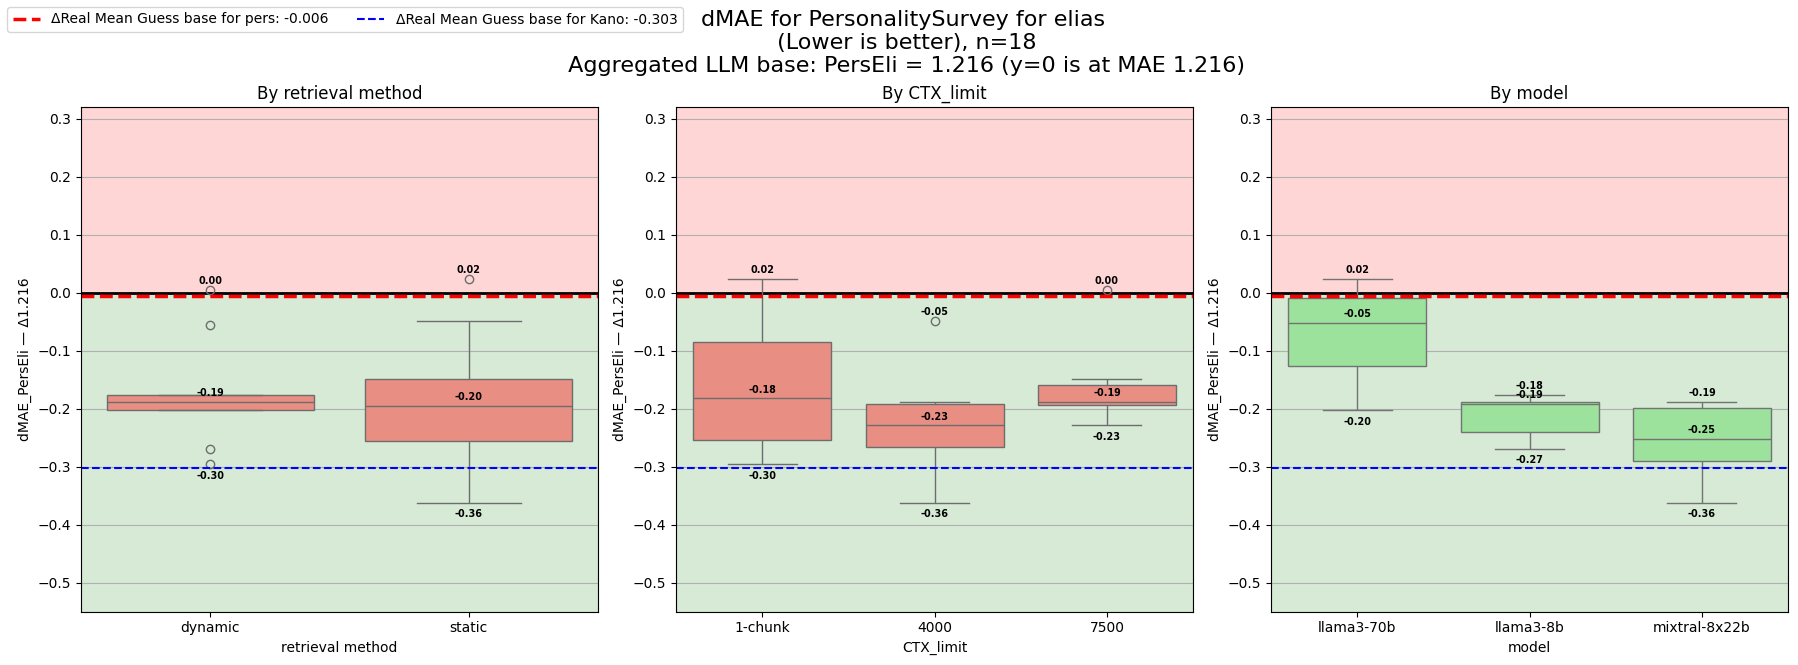

In [190]:
for subj in ['airidas', 'elias']:
    for srv in ['KanoSurvey', "PersonalitySurvey"]:
        base_name = srv[:4]
        if subj == 'airidas': base_name += 'Airi'
        else: base_name += 'Eli'
        base_val = global_base_scores["by_survey_subject"][base_name]
        for index, sim_row in dfg.iterrows():
            for key, value in compare_to_custom_base(sim_row, dfg, base_val=base_val, base_name=base_name).items():
                dfg.at[index, key] = value

        filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == srv) & (dfg['SUBJECT'] == subj)]
        parameters = ['retrieval method', 'CTX_limit', 'model']
        plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts
        lines, labels = [], [] # To keep track of legend handles
        for i, param in enumerate(parameters):
            ax = plt.subplot(1, 3, i + 1)  # Horizontal layout of plots
            ax.grid(True)
            ax.axhline(0, color='black', linewidth=2) 
            ax.axhspan(-0.55, 0, color='green', alpha=0.16)  # Stylish green background below zero
            ax.axhspan(0, 0.32, color='red', alpha=0.16)   # Stylish red background above zero    # Background color above zero
            color = getGlobalColorByParam(param)
            #### Extract median values and their positions ######
            grouped_data = filtered_df.groupby(param)[f'dMAE_{base_name}']
            mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
            pos = range(len(mins))  # Positions of the boxplots
            vertical_offset = 0.01  # offset each text to avoid clutter
            for tick in pos:
                ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
            #####################################################
            sns.boxplot(x=param, y=f'dMAE_{base_name}', color=color, data=filtered_df)
            plt.title(f'By {param}')
            plt.ylabel(f'dMAE_{base_name} — Δ{round(base_val,3)}')
            plt.xticks(rotation=0) 
            plt.ylim(bottom=-0.55, top=0.32)  # Adjust y-limits
            
            if srv == 'KanoSurvey':
                lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--', linewidth=2.5), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
                labels_new = [f'ΔReal Mean Guess base for kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']

            elif srv == 'PersonalitySurvey':
                lines_new = [plt.axhline(y=1.210 - base_val, color='red', linestyle='--', linewidth=2.5), plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--')]
                labels_new = [f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}',f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}']
            else:
                lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--'), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
                labels_new = [f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']

            if i == 1:  # Only need these once for creating the legend
                lines.extend(lines_new)
                labels.extend(labels_new)
        
        plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=10)
        plt.tight_layout()
        plt.suptitle(f'dMAE for {srv} for {subj}\n (Lower is better), n={len(filtered_df)}\n Aggregated LLM base: {base_name} = {round(base_val,3)} (y=0 is at MAE {round(base_val,3)})', y=1.10, fontsize=16) 
        plt.show()

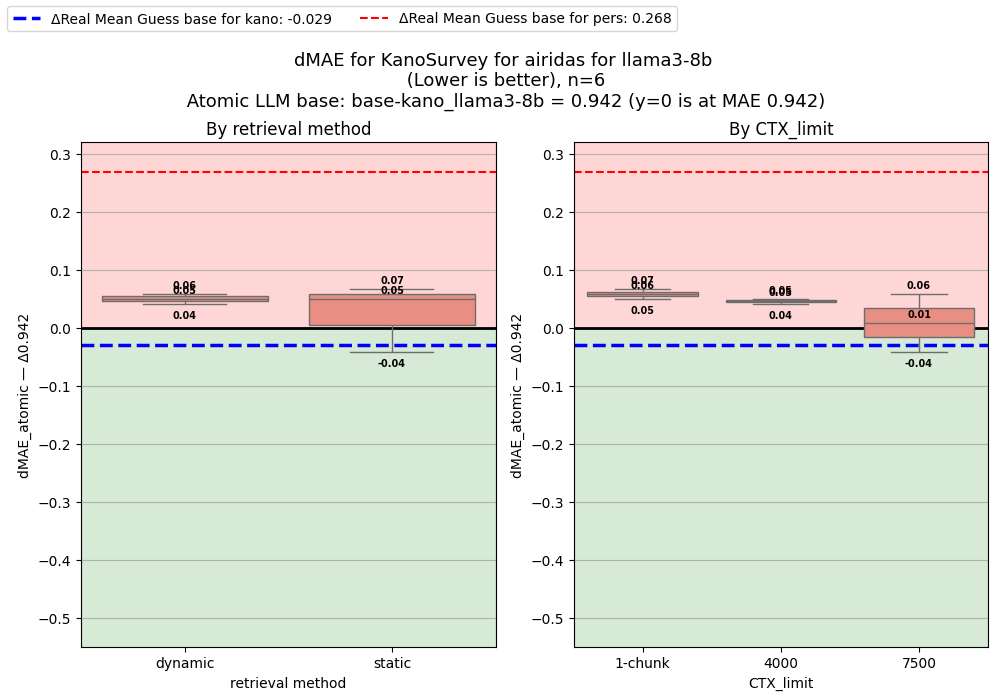

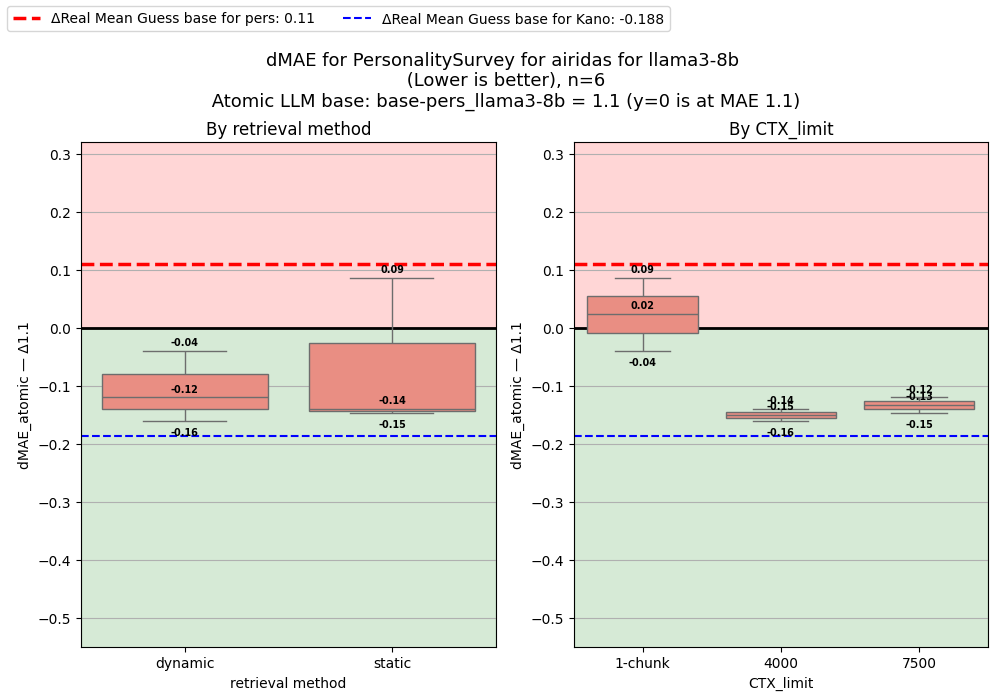

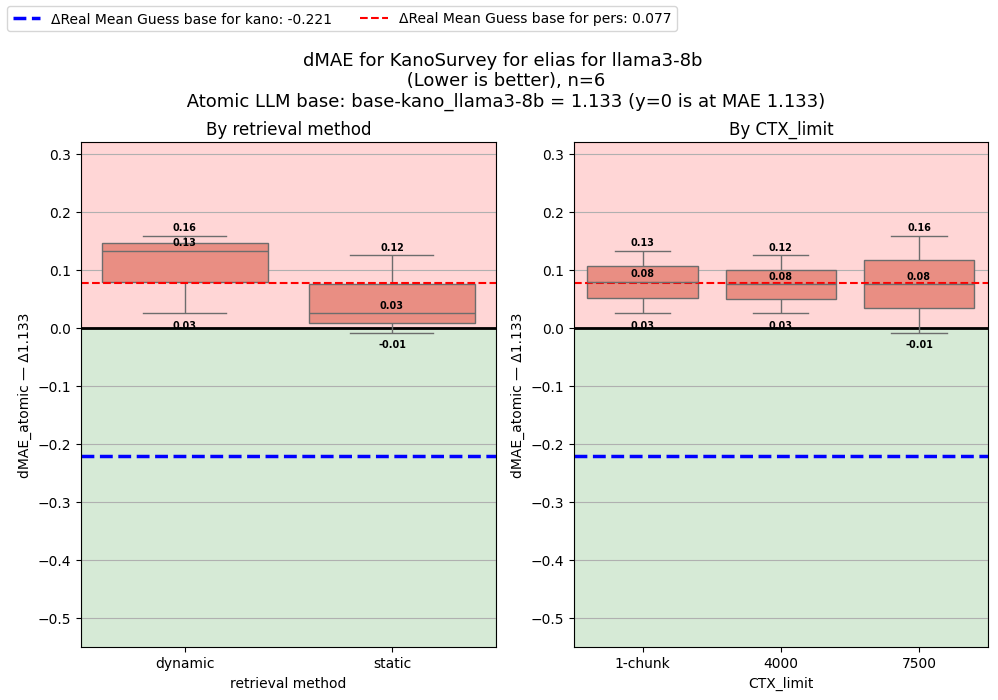

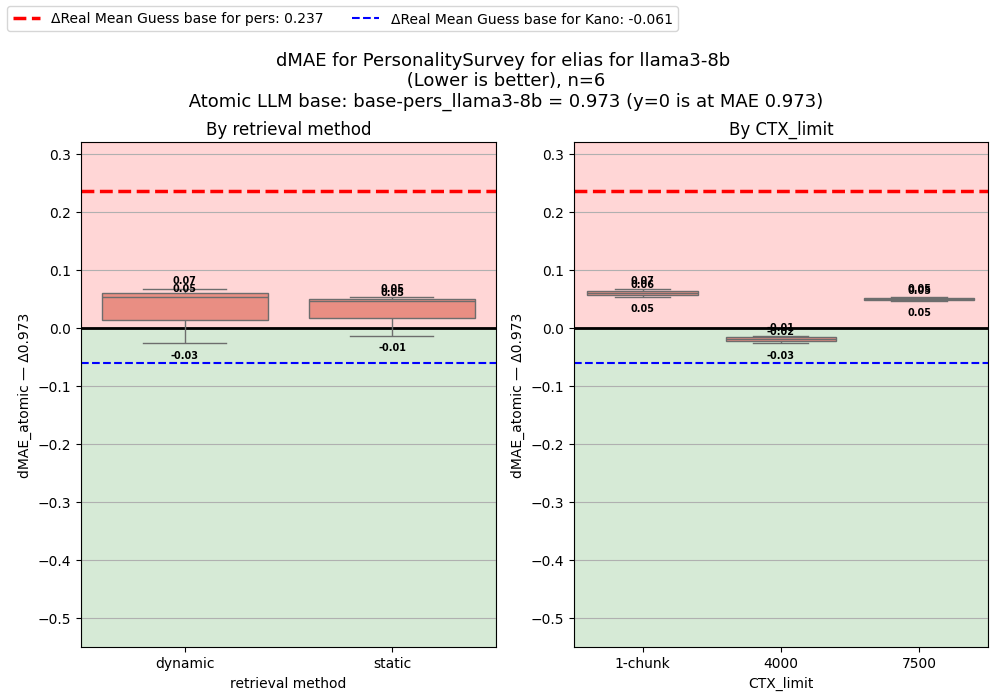

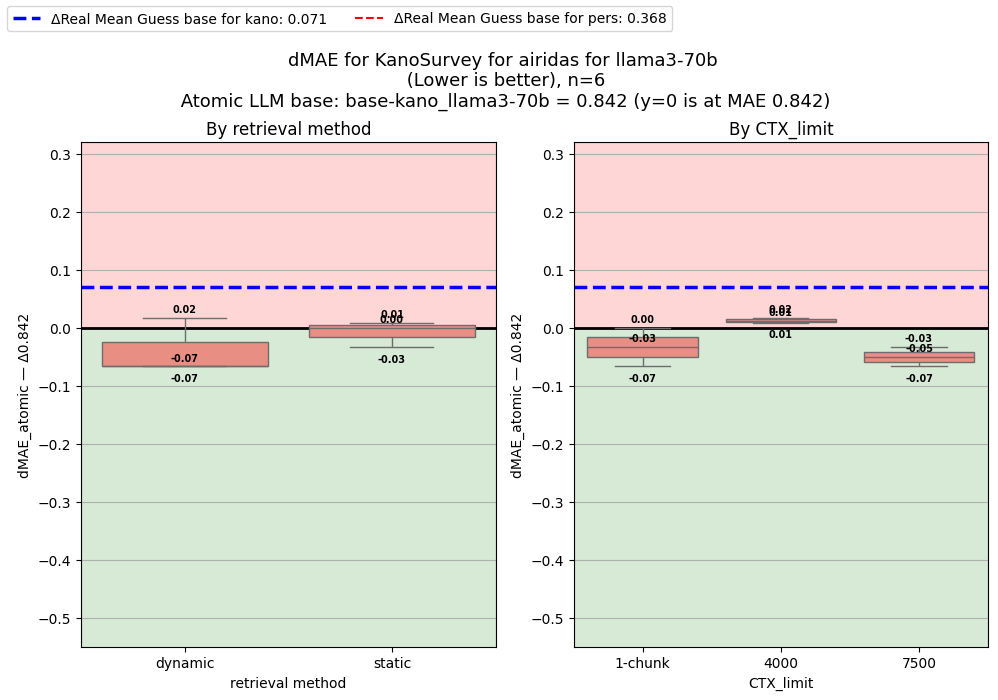

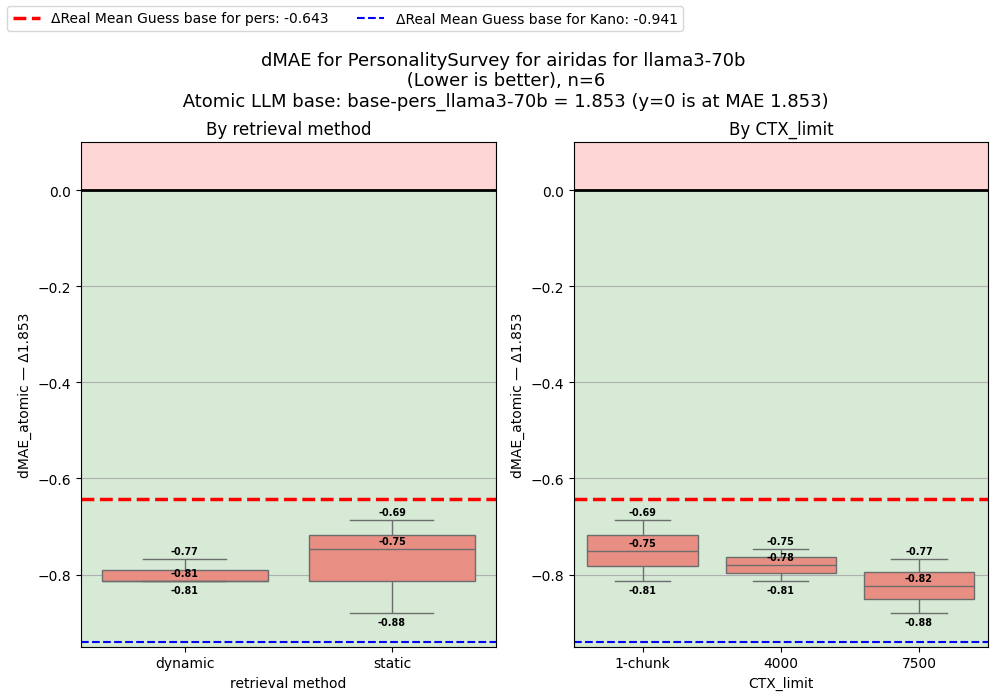

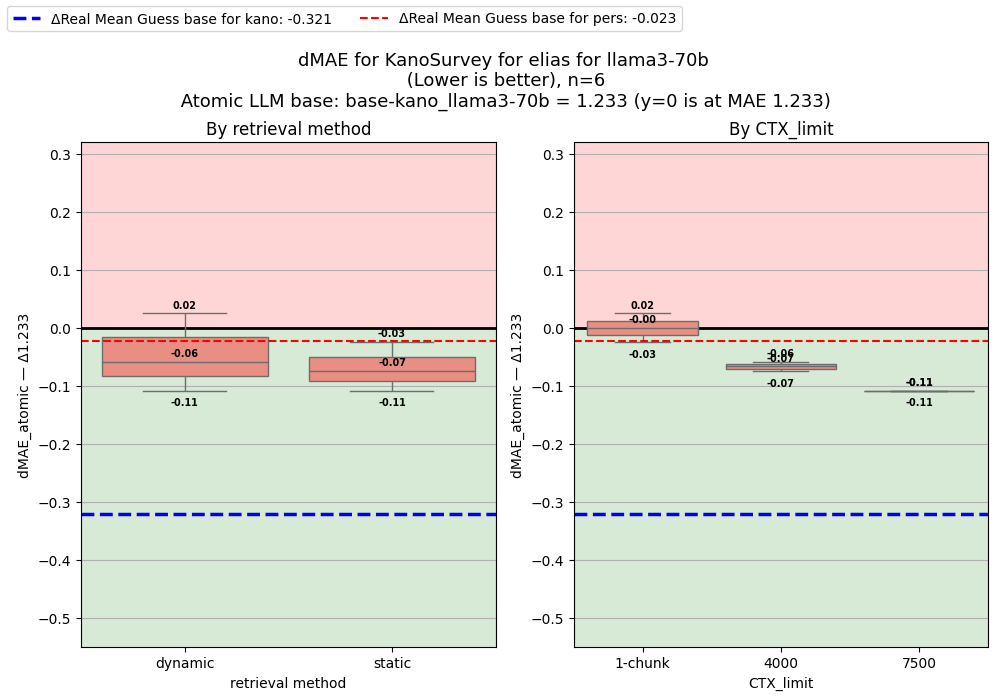

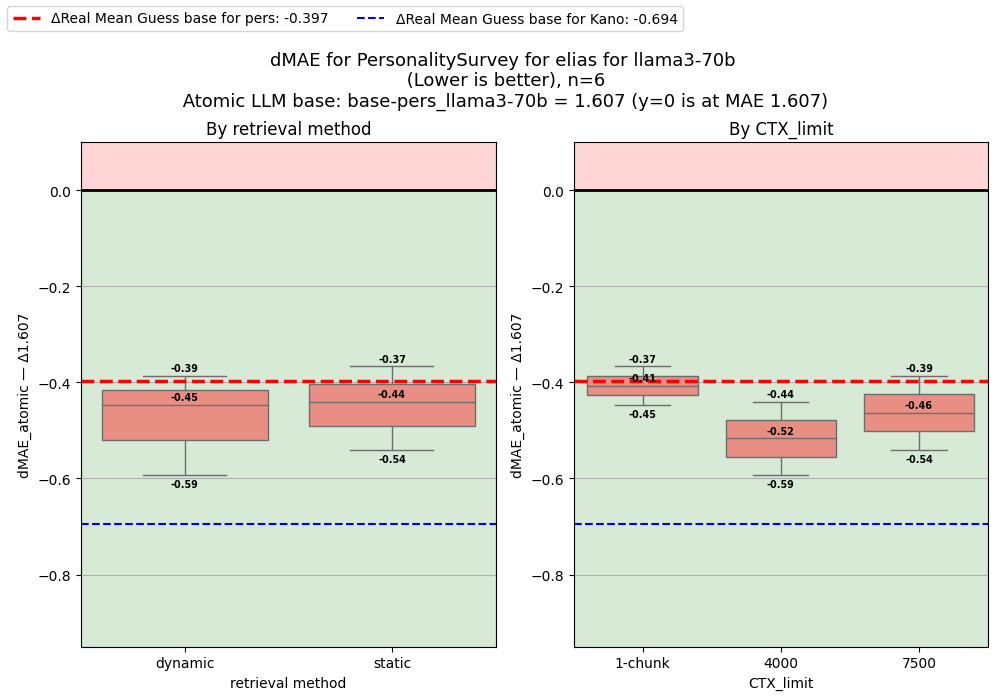

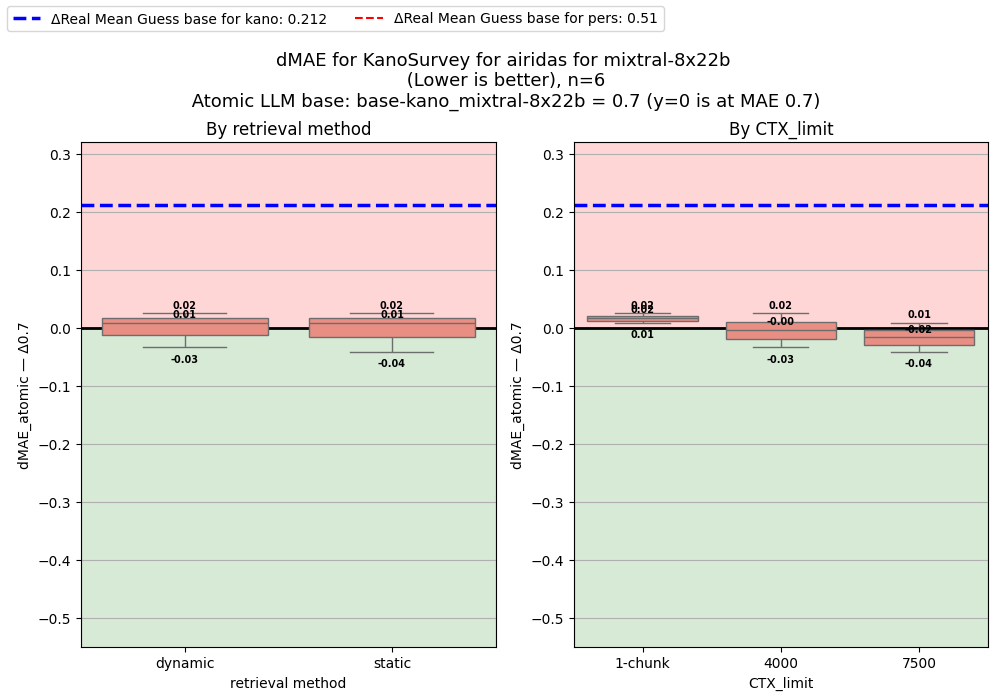

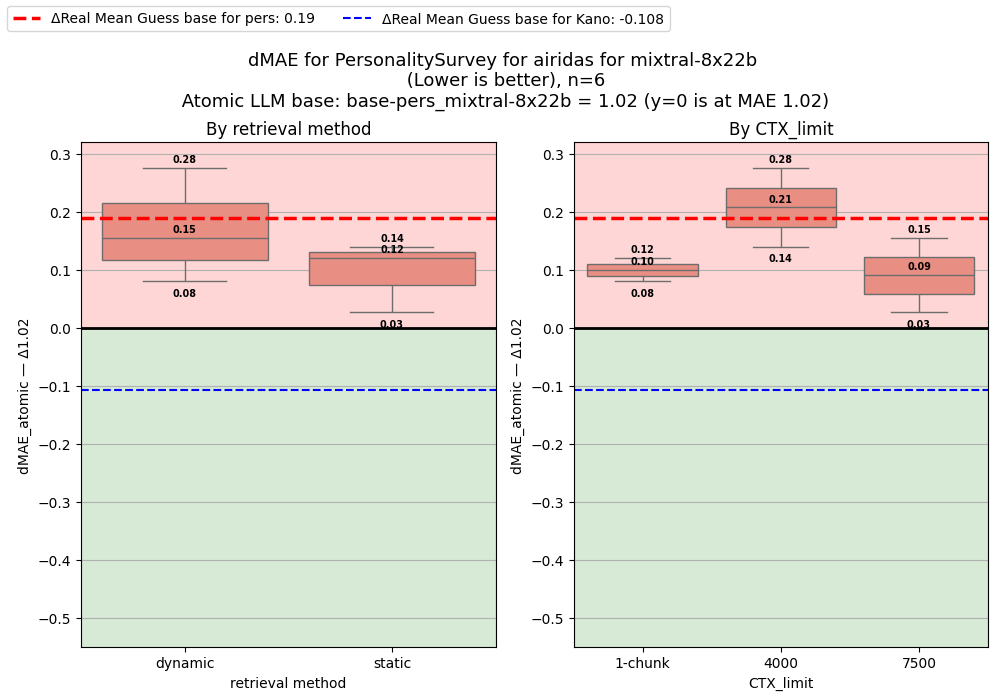

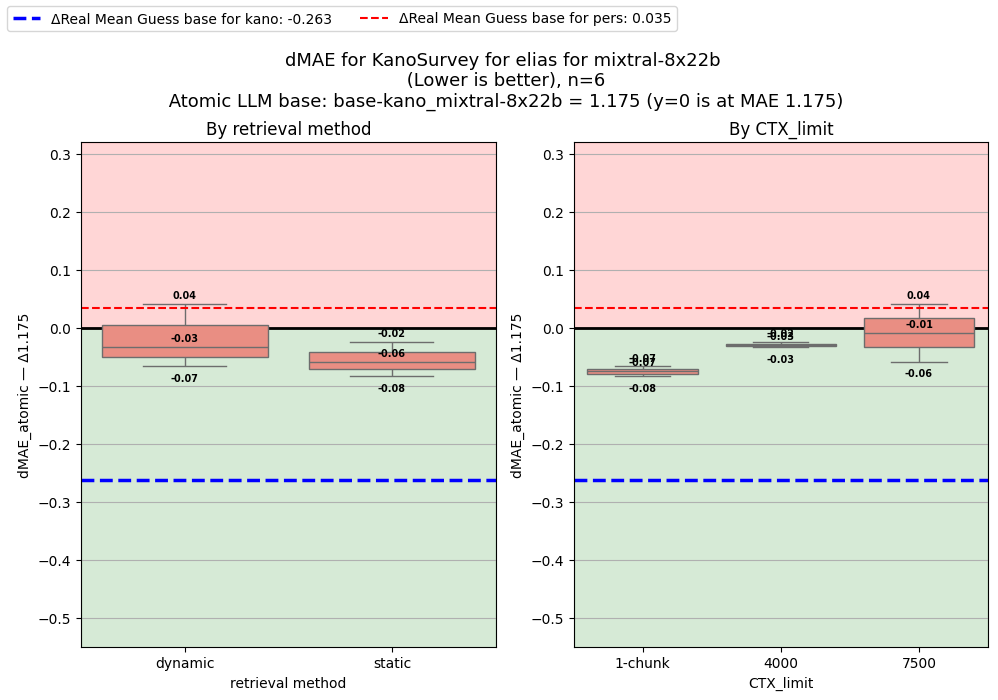

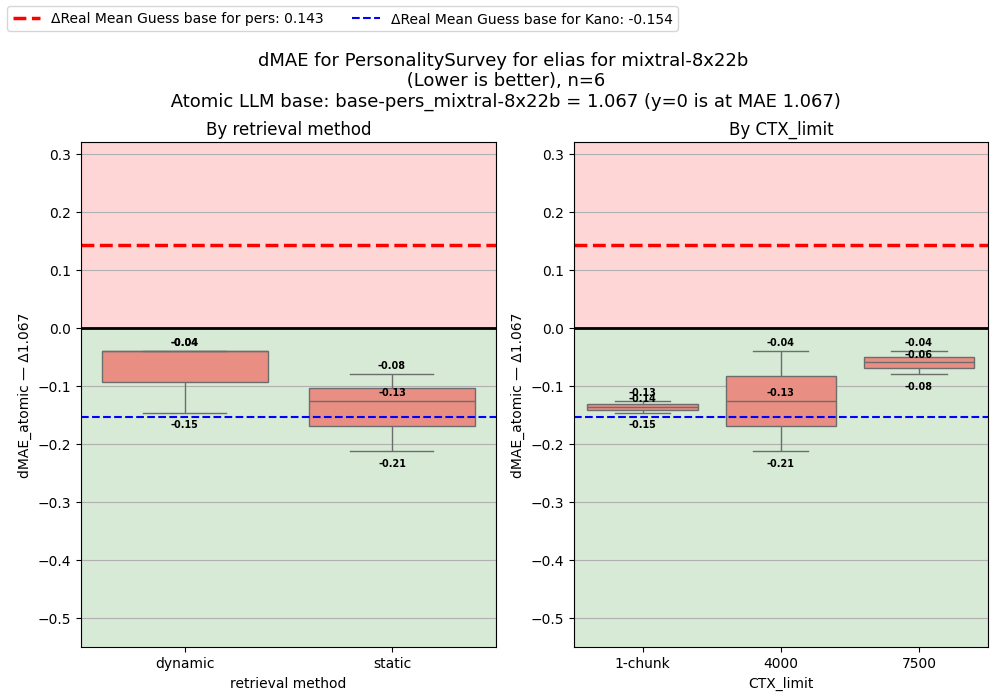

In [218]:
for llm in ['llama3-8b', 'llama3-70b', 'mixtral-8x22b']:
    for subj in ['airidas', 'elias']:
        for srv in ['KanoSurvey', "PersonalitySurvey"]:
            filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == srv) & (dfg['SUBJECT'] == subj) & (dfg['model'] == llm)]
            base_sign = filtered_df.iloc[0]["base_sim_signature"]
            base_name = utils.unclutterSignature(base_sign)
            if subj == 'airidas': base_val = dfg[(dfg['sim_signature'] == base_sign)]['MAE_airi'].mean()
            else: base_val = dfg[(dfg['sim_signature'] == base_sign)]['MAE_eli'].mean()
            parameters = ['retrieval method', 'CTX_limit']
            plt.figure(figsize=(10, 6))  # Adjust the figure size for horizontal layouts
            lines, labels = [], [] # To keep track of legend handles
            for i, param in enumerate(parameters):
                ax = plt.subplot(1, 2, i + 1)  # Horizontal layout of plots
                ax.grid(True)
                ax.axhline(0, color='black', linewidth=2) 
                ax.axhspan(-0.95, 0, color='green', alpha=0.16)  # Stylish green background below zero
                ax.axhspan(0, 0.32, color='red', alpha=0.16)   # Stylish red background above zero    # Background color above zero
                color = getGlobalColorByParam(param)
                #### Extract median values and their positions ######
                grouped_data = filtered_df.groupby(param)[f'dMAE']
                mins, medians, maxs = grouped_data.min().values, grouped_data.median().values, grouped_data.max().values
                pos = range(len(mins))  # Positions of the boxplots
                vertical_offset = 0.01  # offset each text to avoid clutter
                for tick in pos:
                    ax.text(tick, mins[tick] - vertical_offset - 0.015, f'{mins[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                    ax.text(tick, medians[tick] + vertical_offset, f'{medians[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                    ax.text(tick, maxs[tick] + vertical_offset , f'{maxs[tick]:.2f}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
                #####################################################
                sns.boxplot(x=param, y=f'dMAE', color=color, data=filtered_df)
                plt.title(f'By {param}')
                plt.ylabel(f'dMAE_atomic — Δ{round(base_val,3)}')
                plt.xticks(rotation=0) 
                if base_val > 1.6: plt.ylim(bottom=-0.95, top=0.1) 
                else: plt.ylim(bottom=-0.55, top=0.32)  # Adjust y-limits
                
                if srv == 'KanoSurvey':
                    lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--', linewidth=2.5), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
                    labels_new = [f'ΔReal Mean Guess base for kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']
                elif srv == 'PersonalitySurvey':
                    lines_new = [plt.axhline(y=1.210 - base_val, color='red', linestyle='--', linewidth=2.5), plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--')]
                    labels_new = [f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}',f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}']
                else:
                    lines_new = [plt.axhline(y=0.9125 - base_val, color='blue', linestyle='--'), plt.axhline(y=1.210 - base_val, color='red', linestyle='--')]
                    labels_new = [f'ΔReal Mean Guess base for Kano: {round(0.9125 - base_val,3)}', f'ΔReal Mean Guess base for pers: {round(1.210 - base_val,3)}']

                if i == 1:  # Only need these once for creating the legend
                    lines.extend(lines_new)
                    labels.extend(labels_new)
            
            plt.figlegend(lines, labels, loc='upper left', ncol=2, fontsize=10)
            plt.tight_layout()
            plt.suptitle(f'\n\ndMAE for {srv} for {subj} for {llm}\n (Lower is better), n={len(filtered_df)}\n Atomic LLM base: {base_name} = {round(base_val,3)} (y=0 is at MAE {round(base_val,3)})', y=1.16, fontsize=13) 
            plt.show()

In [193]:
ddf = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == "KanoSurvey") & (dfg['SUBJECT'] == "airidas") & (dfg['model'] == "llama3-8b")]

In [ ]:
base_dfg[(base_dfg['sim_signature'] == 'base-pers-29_mixtral-8x22b_V7')]['MAE_eli'].mean()

In [204]:
importlib.reload(utils)

<module 'shared_utils' from 'g:\\My Drive\\CBS\\Thesis\\Thesis\\shared_utils.py'>

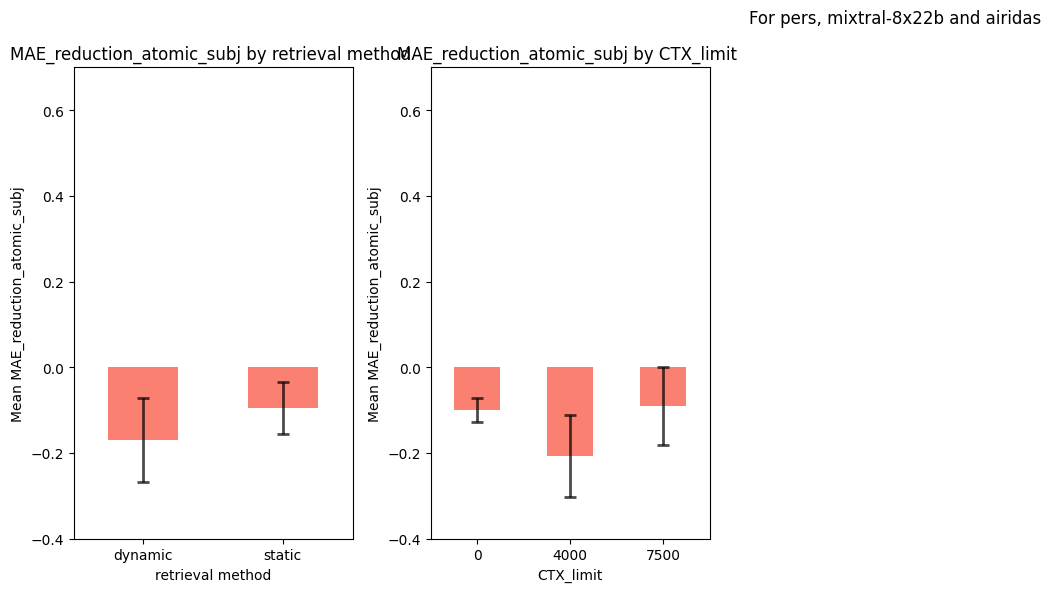

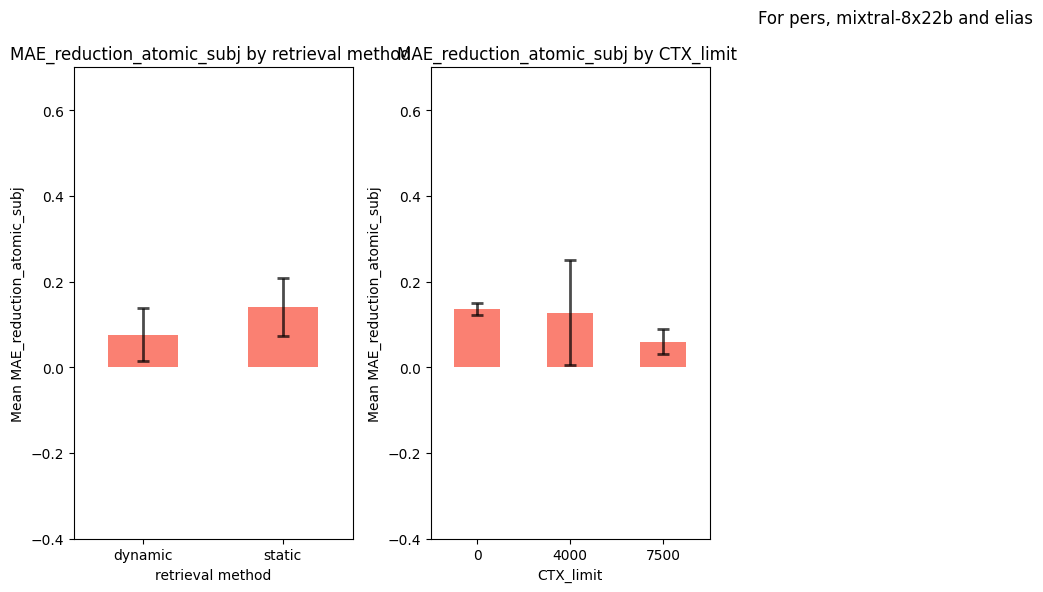

In [24]:
# for index, sim_row in dfg.iterrows():
#     for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["atomic"]["base-kano-29_mixtral-8x22b_V7_airi"], base_name="").items():
#         dfg.at[index, key] = value


for subj in ['airidas', 'elias']:
    filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == 'PersonalitySurvey') & (dfg['SUBJECT'] == subj) & (dfg['model'] == 'mixtral-8x22b')]

    # Define parameters of interest
    parameters = ['retrieval method','CTX_limit']

    # Create a figure to hold the plots
    plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

    # Loop through each parameter and create a bar chart
    for i, param in enumerate(parameters, 1):
        plt.subplot(1, 5, i)  # Horizontal layout of plots
        # Group by the parameter
        group = filtered_df.groupby(param)['MAE_reduction_subj']
        means = group.mean()
        errors = group.std()  # Calculate standard deviation for error bars

        # Assign specific colors for "SUBJECT" and "survey_type"
        if param == 'SUBJECT':
            colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
        elif param == 'survey_type':
            colors = ['lightblue', 'lightblue']
        elif param == 'model':
            colors = ['lightgreen', 'lightgreen', 'lightgreen']
        else:
            colors = 'salmon'  # General color for other parameters

        means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})
        plt.title(f'MAE_reduction_atomic_subj by {param} ')
        plt.suptitle(f'For pers, mixtral-8x22b and {subj}') 
        plt.ylabel('Mean MAE_reduction_atomic_subj')
        plt.xticks(rotation=0)
        plt.ylim(bottom=-0.4, top=0.7)  # Expecting negative values so setting lower y limit to -1

    plt.tight_layout()
    plt.show()

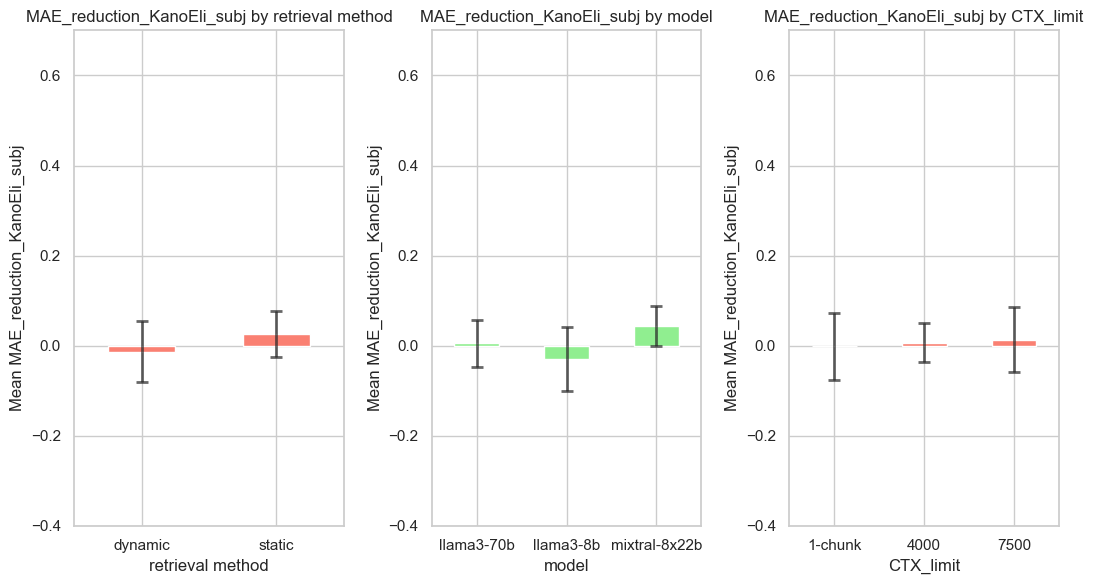

In [280]:
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["by_survey_subject"]["KanoEli"], base_name="KanoEli").items():
        dfg.at[index, key] = value

filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == 'KanoSurvey') & (dfg['SUBJECT'] == 'elias')]

# Define parameters of interest
parameters = ['retrieval method', 'model', 'CTX_limit']

# Create a figure to hold the plots
plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

# Loop through each parameter and create a bar chart
for i, param in enumerate(parameters, 1):
    plt.subplot(1, 5, i)  # Horizontal layout of plots
    # Group by the parameter
    group = filtered_df.groupby(param)['MAE_reduction_KanoEli_subj']
    means = group.mean()
    errors = group.std()  # Calculate standard deviation for error bars

    # Assign specific colors for "SUBJECT" and "survey_type"
    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters

    means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})
    plt.title(f'MAE_reduction_KanoEli_subj by {param}')
    plt.ylabel('Mean MAE_reduction_KanoEli_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=-0.4, top=0.7)  # Expecting negative values so setting lower y limit to -1

plt.tight_layout()
plt.show()

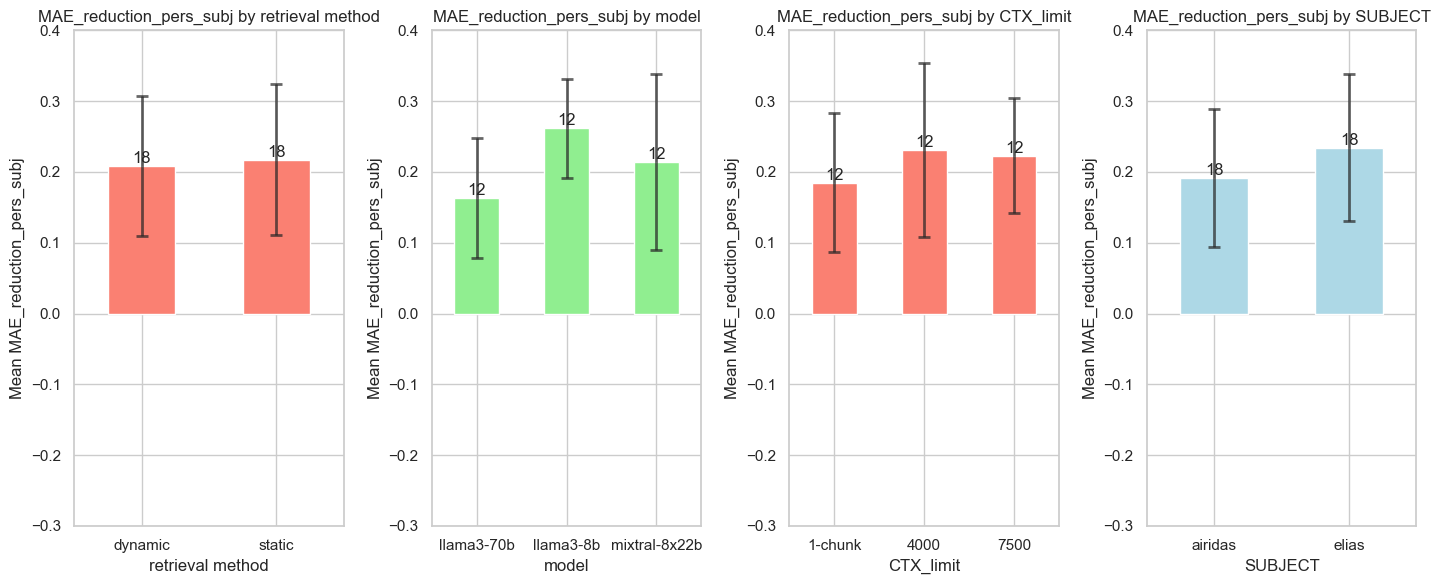

In [271]:
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["by_survey"]["PersonalitySurvey"], base_name="pers").items():
        dfg.at[index, key] = value

filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == 'PersonalitySurvey')]

# Define parameters of interest
parameters = ['retrieval method', 'model', 'CTX_limit','SUBJECT',]

# Create a figure to hold the plots
plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

# Loop through each parameter and create a bar chart
for i, param in enumerate(parameters, 1):
    plt.subplot(1, 5, i)  # Horizontal layout of plots
    # Group by the parameter
    group = filtered_df.groupby(param)['MAE_reduction_pers_subj']
    means = group.mean()
    errors = group.std()  # Calculate standard deviation for error bars
    counts = group.size()

    # Assign specific colors for "SUBJECT" and "survey_type"
    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters

    bars = means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})

    # Add counts above bars
    for bar, count in zip(bars.patches, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count}', ha='center', va='bottom')
        
    plt.title(f'MAE_reduction_pers_subj by {param}')
    plt.ylabel('Mean MAE_reduction_pers_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=-0.3, top=0.4)  # Expecting negative values so setting lower y limit to -1

plt.tight_layout()
plt.show()

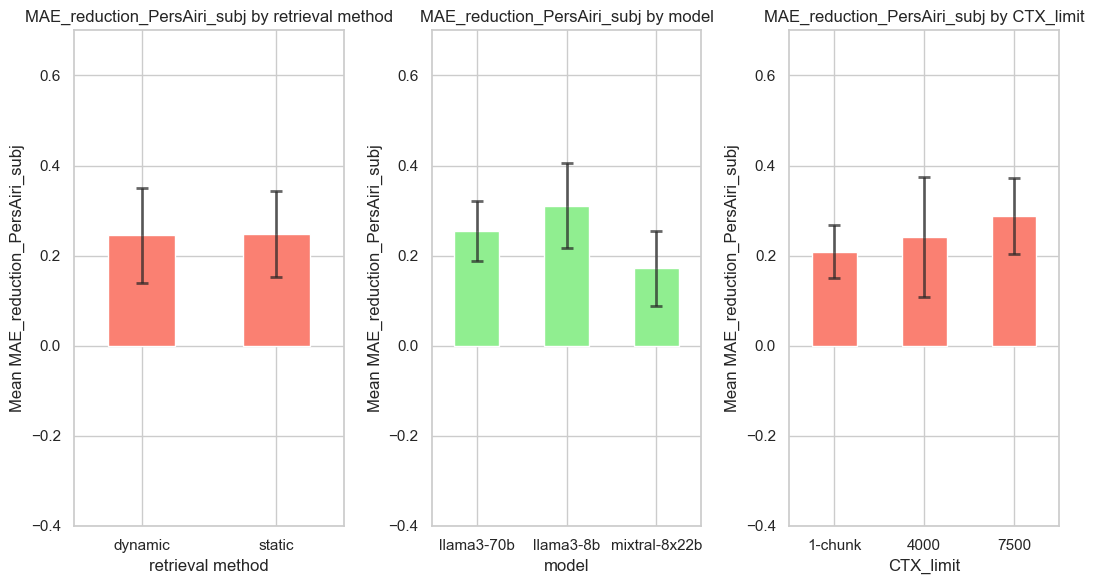

In [276]:
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["by_survey_subject"]["PersAiri"], base_name="PersAiri").items():
        dfg.at[index, key] = value

filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == 'PersonalitySurvey') & (dfg['SUBJECT'] == 'airidas')]

# Define parameters of interest
parameters = ['retrieval method', 'model', 'CTX_limit']

# Create a figure to hold the plots
plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

# Loop through each parameter and create a bar chart
for i, param in enumerate(parameters, 1):
    plt.subplot(1, 5, i)  # Horizontal layout of plots
    # Group by the parameter
    group = filtered_df.groupby(param)['MAE_reduction_PersAiri_subj']
    means = group.mean()
    errors = group.std()  # Calculate standard deviation for error bars

    # Assign specific colors for "SUBJECT" and "survey_type"
    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters

    means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})
    plt.title(f'MAE_reduction_PersAiri_subj by {param}')
    plt.ylabel('Mean MAE_reduction_PersAiri_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=-0.4, top=0.7)  # Expecting negative values so setting lower y limit to -1

plt.tight_layout()
plt.show()

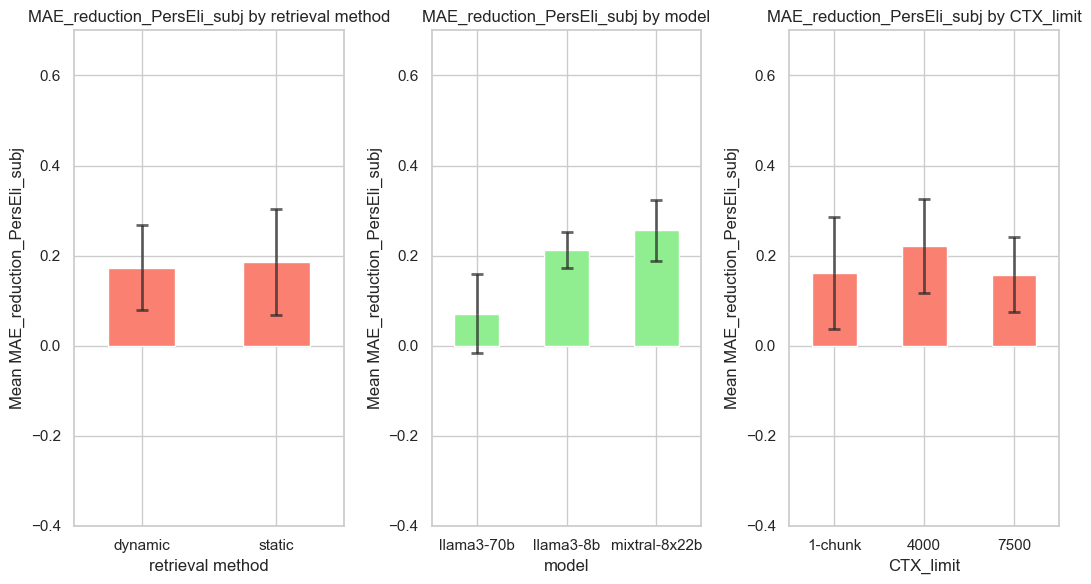

In [277]:
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["by_survey_subject"]["PersEli"], base_name="PersEli").items():
        dfg.at[index, key] = value

filtered_df = dfg[(dfg['is_base'] == False) & (dfg['survey_type'] == 'PersonalitySurvey') & (dfg['SUBJECT'] == 'elias')]

# Define parameters of interest
parameters = ['retrieval method', 'model', 'CTX_limit']

# Create a figure to hold the plots
plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

# Loop through each parameter and create a bar chart
for i, param in enumerate(parameters, 1):
    plt.subplot(1, 5, i)  # Horizontal layout of plots
    # Group by the parameter
    group = filtered_df.groupby(param)['MAE_reduction_PersEli_subj']
    means = group.mean()
    errors = group.std()  # Calculate standard deviation for error bars

    # Assign specific colors for "SUBJECT" and "survey_type"
    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters

    means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})
    plt.title(f'MAE_reduction_PersEli_subj by {param}')
    plt.ylabel('Mean MAE_reduction_PersEli_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=-0.4, top=0.7)  # Expecting negative values so setting lower y limit to -1

plt.tight_layout()
plt.show()

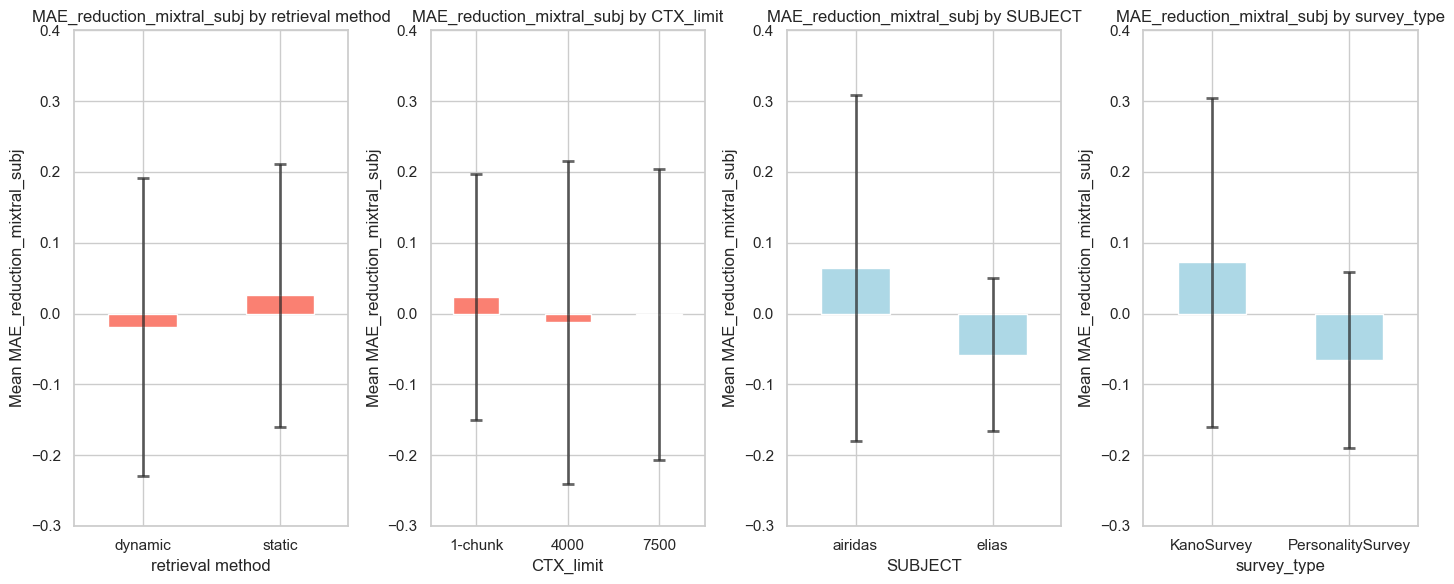

In [259]:
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["by_model"]["mixtral-8x22b"], base_name="mixtral").items():
        dfg.at[index, key] = value

filtered_df = dfg[(dfg['is_base'] == False) & (dfg['model'] == 'mixtral-8x22b')]

# Define parameters of interest
parameters = ['retrieval method', 'CTX_limit','SUBJECT', 'survey_type',]

# Create a figure to hold the plots
plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

# Loop through each parameter and create a bar chart
for i, param in enumerate(parameters, 1):
    plt.subplot(1, 5, i)  # Horizontal layout of plots
    # Group by the parameter
    group = filtered_df.groupby(param)['MAE_reduction_mixtral_subj']
    means = group.mean()
    errors = group.std()  # Calculate standard deviation for error bars

    # Assign specific colors for "SUBJECT" and "survey_type"
    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters

    means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})
    plt.title(f'MAE_reduction_mixtral_subj by {param}')
    plt.ylabel('Mean MAE_reduction_mixtral_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=-0.3, top=0.4)  # Expecting negative values so setting lower y limit to -1

plt.tight_layout()
plt.show()

In [ ]:
for index, sim_row in dfg.iterrows():
    for key, value in compare_to_custom_base(sim_row, dfg, base_val=global_base_scores["by_model"]["mixtral-8x22b"], base_name="mixtral").items():
        dfg.at[index, key] = value

filtered_df = dfg[(dfg['is_base'] == False) & (dfg['model'] == 'mixtral-8x22b')]

# Define parameters of interest
parameters = ['retrieval method', 'CTX_limit','SUBJECT', 'survey_type',]

# Create a figure to hold the plots
plt.figure(figsize=(18, 6))  # Adjust the figure size for horizontal layouts

# Loop through each parameter and create a bar chart
for i, param in enumerate(parameters, 1):
    plt.subplot(1, 5, i)  # Horizontal layout of plots
    # Group by the parameter
    group = filtered_df.groupby(param)['MAE_reduction_mixtral_subj']
    means = group.mean()
    errors = group.std()  # Calculate standard deviation for error bars

    # Assign specific colors for "SUBJECT" and "survey_type"
    if param == 'SUBJECT':
        colors = ['lightblue', 'lightblue', 'lightblue']  # Adjust colors as needed
    elif param == 'survey_type':
        colors = ['lightblue', 'lightblue']
    elif param == 'model':
        colors = ['lightgreen', 'lightgreen', 'lightgreen']
    else:
        colors = 'salmon'  # General color for other parameters

    means.plot(kind='bar', yerr=errors, capsize=4, color=colors, error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.7})
    plt.title(f'MAE_reduction_master_subj by {param}')
    plt.ylabel('Mean MAE_reduction_master_subj')
    plt.xticks(rotation=0)
    plt.ylim(bottom=-0.3, top=0.4)  # Expecting negative values so setting lower y limit to -1

plt.tight_layout()
plt.show()

#### Old Viz

C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_13932\2354292823.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, y=ylabel, x='MAE_airi_mean' if 'Airidas' in title else 'MAE_eli_mean', ax=ax, palette=colors, orient='h')
C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_13932\2354292823.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, y=ylabel, x='MAE_airi_mean' if 'Airidas' in title else 'MAE_eli_mean', ax=ax, palette=colors, orient='h')
C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_13932\2354292823.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=Fa

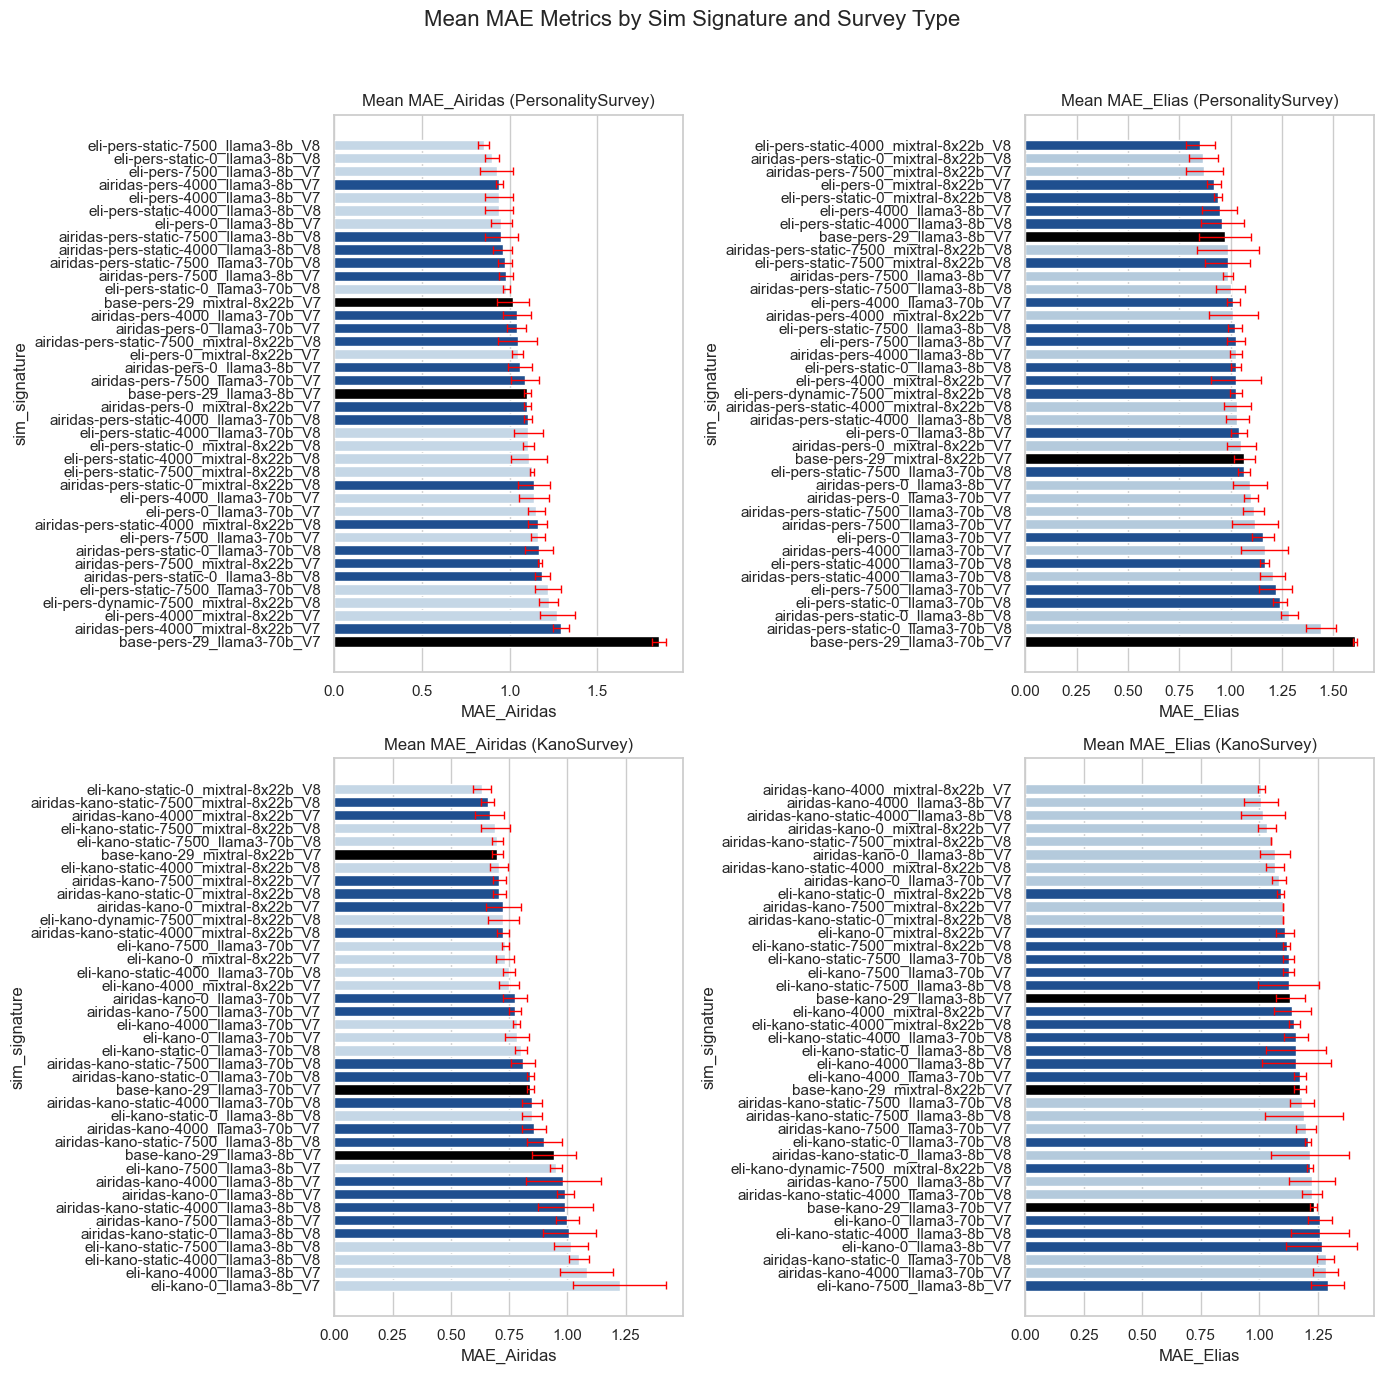

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style
sns.set(style="whitegrid")

# Sorting and filtering the dataframe for each plot
sorted_airidas_personality = dfg[(dfg['survey_type'] == 'PersonalitySurvey')].sort_values('MAE_airi_mean', ascending=True)
sorted_airidas_kano = dfg[(dfg['survey_type'] == 'KanoSurvey')].sort_values('MAE_airi_mean', ascending=True)
sorted_elias_personality = dfg[(dfg['survey_type'] == 'PersonalitySurvey')].sort_values('MAE_eli_mean', ascending=True)
sorted_elias_kano = dfg[(dfg['survey_type'] == 'KanoSurvey')].sort_values('MAE_eli_mean', ascending=True)

# Custom color functions
def get_colors_airidas(df):
    colors = []
    for _, row in df.iterrows():
        if row['SUBJECT'] != 'airidas' and not row['is_base']:
            colors.append('#bfd7ec')
        elif row['is_base']:
            colors.append('black')
        else:
            colors.append('#0c4da2')
    return colors

def get_colors_elias(df):
    colors = []
    for _, row in df.iterrows():
        if row['SUBJECT'] != 'elias' and not row['is_base']:
            colors.append('#adcbe3')
        elif row['is_base']:
            colors.append('black')
        else:
            colors.append('#0c4da2')
    return colors

colors_airidas_p = get_colors_airidas(sorted_airidas_personality)
colors_airidas_k = get_colors_airidas(sorted_airidas_kano)
colors_elias_p = get_colors_elias(sorted_elias_personality)
colors_elias_k = get_colors_elias(sorted_elias_kano)

fig, axs = plt.subplots(2, 2, figsize=(14, 14))
fig.suptitle('Mean MAE Metrics by Sim Signature and Survey Type', fontsize=16)

# Adding horizontal bars and error bars
for (data, ax, colors, ylabel, title) in [
    (sorted_airidas_personality, axs[0, 0], colors_airidas_p, 'sim_signature', 'Mean MAE_Airidas (PersonalitySurvey)'),
    (sorted_airidas_kano, axs[1, 0], colors_airidas_k, 'sim_signature', 'Mean MAE_Airidas (KanoSurvey)'),
    (sorted_elias_personality, axs[0, 1], colors_elias_p, 'sim_signature', 'Mean MAE_Elias (PersonalitySurvey)'),
    (sorted_elias_kano, axs[1, 1], colors_elias_k, 'sim_signature', 'Mean MAE_Elias (KanoSurvey)')
]:
    sns.barplot(data=data, y=ylabel, x='MAE_airi_mean' if 'Airidas' in title else 'MAE_eli_mean', ax=ax, palette=colors, orient='h')
    if 'Airidas' in title:
        ax.errorbar(data['MAE_airi_mean'], data[ylabel], xerr=data['MAE_airi_std'], fmt='none', ecolor='red', capsize=3, elinewidth=1, alpha=1 )
    else:
        ax.errorbar(data['MAE_eli_mean'], data[ylabel], xerr=data['MAE_eli_std'], fmt='none', ecolor='red', capsize=3, elinewidth=1, alpha=1)
    ax.set_title(title)
    ax.set_xlabel(title.split(' ')[1])
    ax.set_ylabel(ylabel)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

###########################
# Average the crossed results
###########################

In [67]:
# expoert dfg to csv
dfg.to_csv("analysis/spreadsheets/dfg-1.csv", index=False)

In [40]:
len(dfg)

61

### Hyperparameter tuning analysis (NEW)

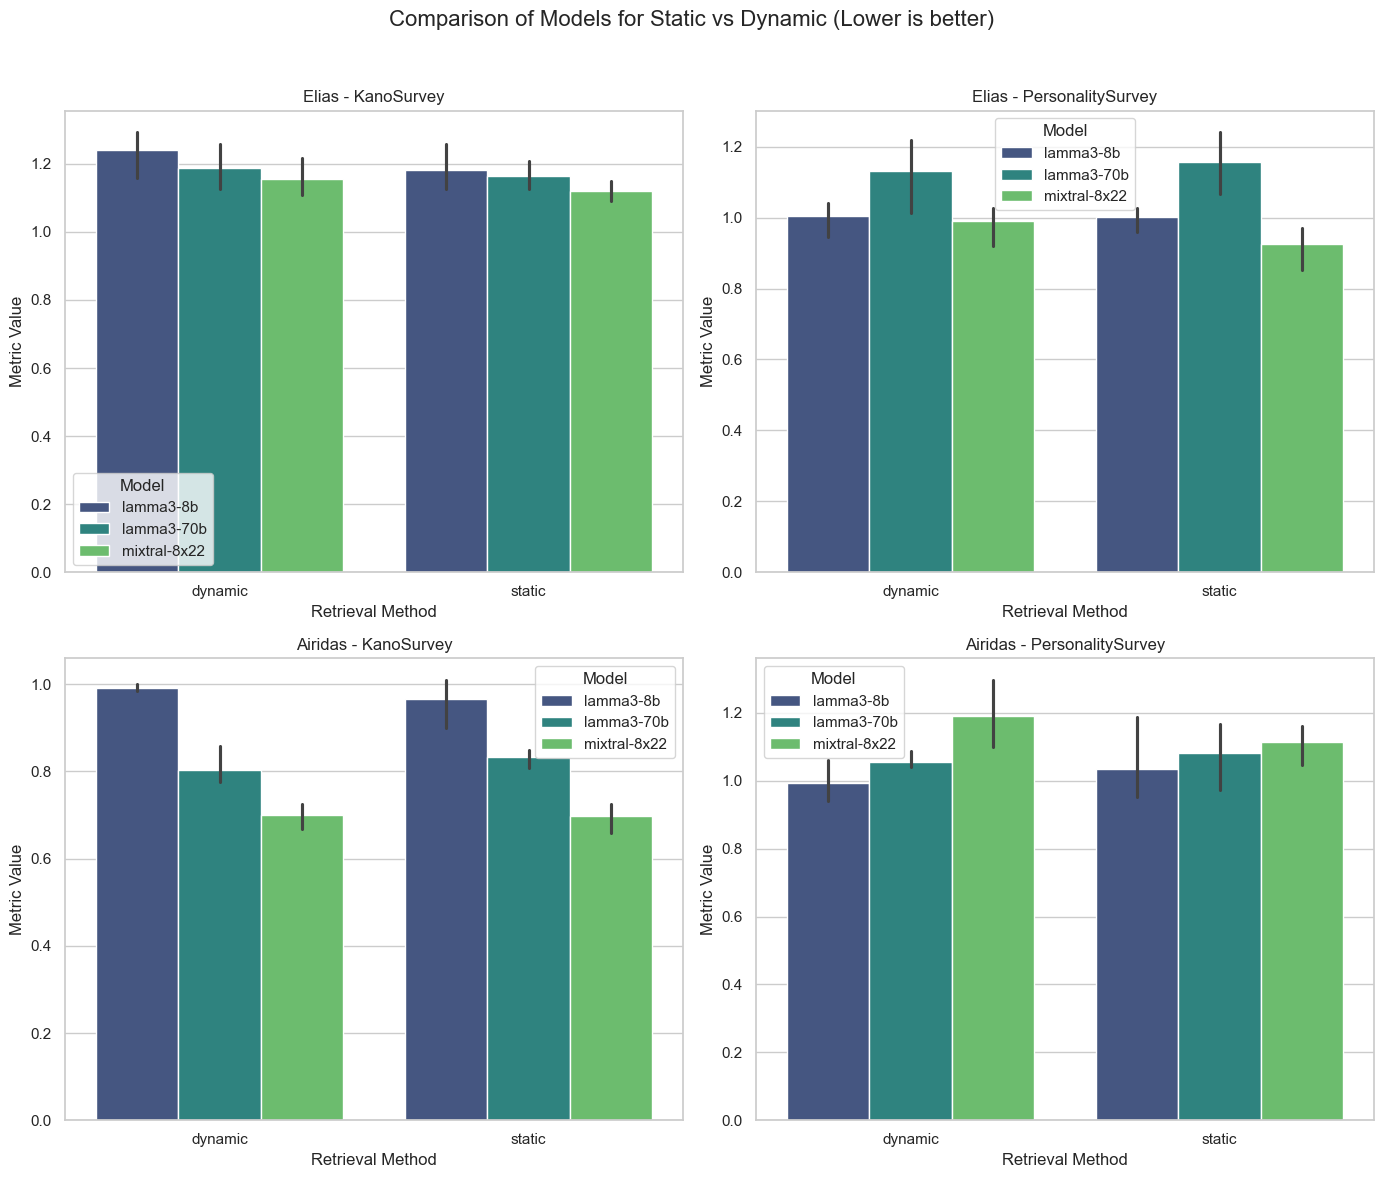

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'dfg' is your DataFrame
# Filter out rows where 'is_base' is True
df_filtered = dfg[dfg['is_base'] == False]

# Create a figure for the plots
fig, axs = plt.subplots(2, 2, figsize=(14, 12))  # 2 rows, 2 columns
fig.suptitle('Comparison of Models for Static vs Dynamic (Lower is better)', fontsize=16)

# Each subplot for different combinations
for i, (subject, survey_type) in enumerate([
        ('elias', 'KanoSurvey'), ('elias', 'PersonalitySurvey'),
        ('airidas', 'KanoSurvey'), ('airidas', 'PersonalitySurvey')]):

    ax = axs[i//2, i%2]
    
    # Filter data for the specific group
    df_group = df_filtered[(df_filtered['SUBJECT'] == subject) & (df_filtered['survey_type'] == survey_type)]
    
    # Separate further by model
    df_group_8b = df_group[df_group['model'] == 'llama3-8b']
    df_group_70b = df_group[df_group['model'] == 'llama3-70b']
    df_group_8x22b = df_group[df_group['model'] == 'mixtral-8x22b']
    
    # Combine the data for a comparison by retrieval method and model
    df_group_8b = df_group_8b.assign(Model='lamma3-8b')
    df_group_70b = df_group_70b.assign(Model='lamma3-70b')
    df_group_8x22b = df_group_8x22b.assign(Model='mixtral-8x22')
    df_plot = pd.concat([df_group_8b, df_group_70b, df_group_8x22b])

    # Select the correct metric based on the subject
    if subject == 'elias':
        metric_column = f'MAE_eli_mean'
    if subject == 'airidas':
        metric_column = f'MAE_airi_mean'
    df_plot['Metric Value'] = df_plot[metric_column]
    
    # Create a bar chart
    sns.barplot(data=df_plot, x='retrieval method', y='Metric Value', hue='Model', ax=ax, palette='viridis')
    
    # Setting the title and labels
    ax.set_title(f'{subject.capitalize()} - {survey_type}')
    ax.set_xlabel('Retrieval Method')
    ax.set_ylabel('Metric Value')

# Adjust layout for better readability
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plot
plt.show()


##########################
# Add base
#########################

C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_9212\3737665853.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['Metric Value'] = df_group[metric_column]
C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_9212\3737665853.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['Metric Value'] = df_group[metric_column]
C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_9212\3737665853.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

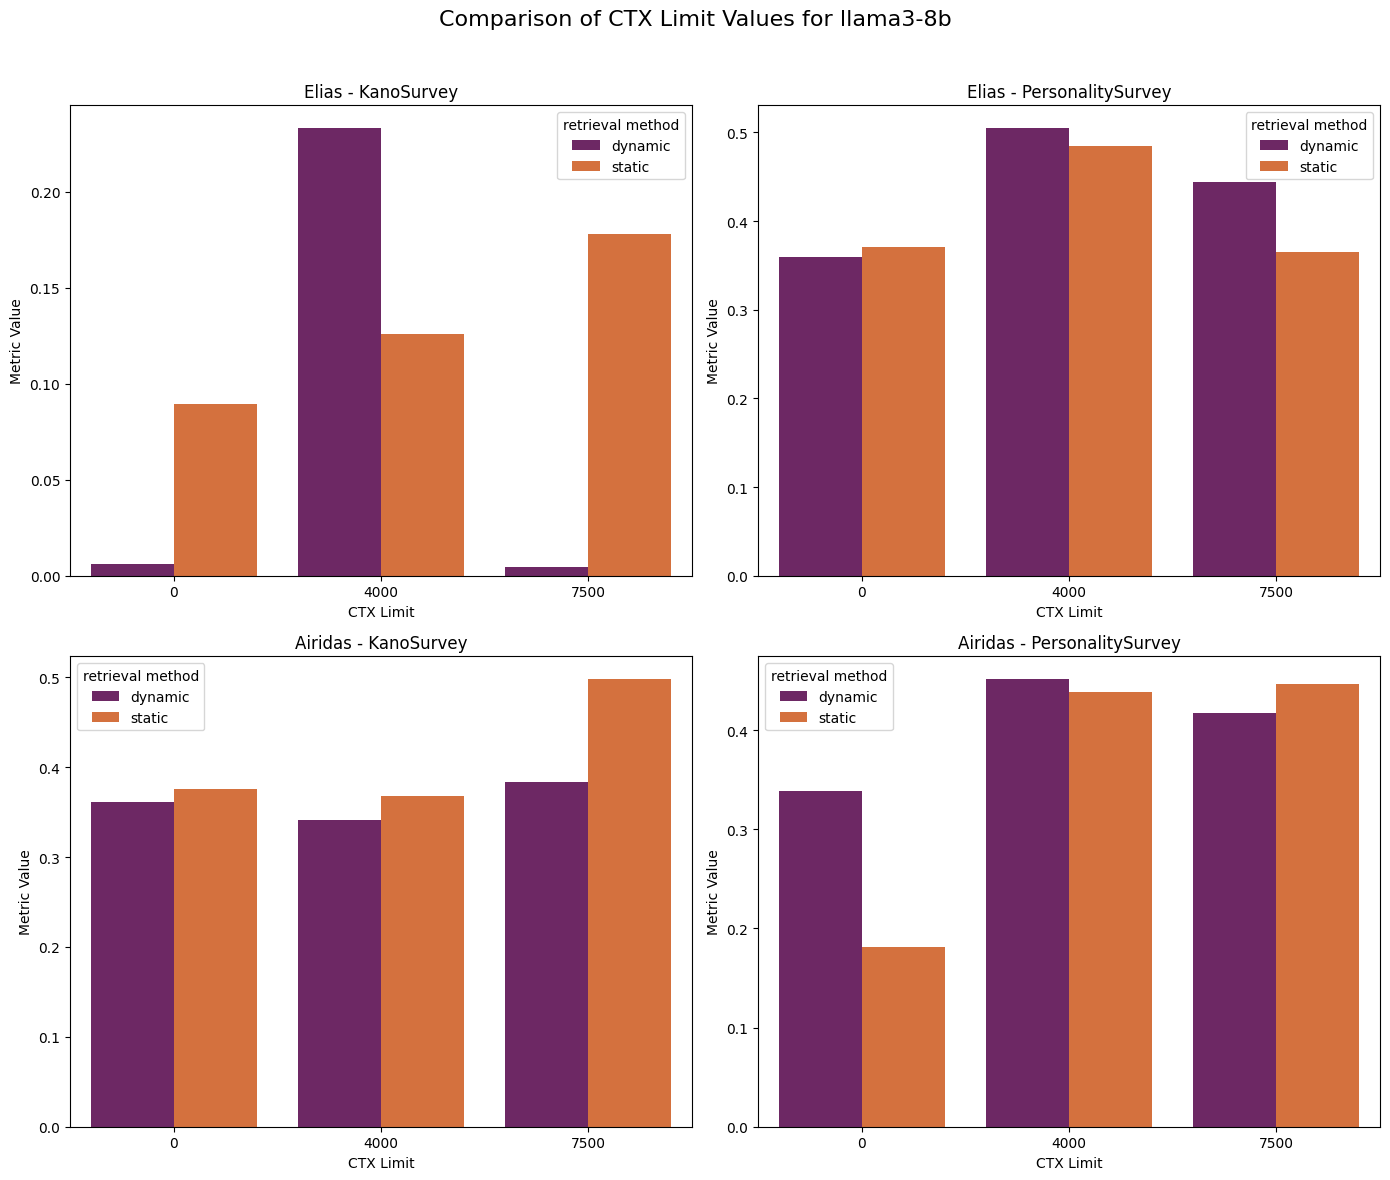

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'dfg' is your DataFrame
# Filter out rows where 'is_base' is True and 'lamma3-70b'

df_filtered = dfg[(dfg['is_base'] == False) & (dfg['model'] == 'llama3-8b')]

# Create a figure for the plots
fig, axs = plt.subplots(2, 2, figsize=(14, 12))  # 2 rows, 2 columns
fig.suptitle('Comparison of CTX Limit Values for llama3-8b', fontsize=16)

# Each subplot for different combinations
for i, (subject, survey_type) in enumerate([
        ('elias', 'KanoSurvey'), ('elias', 'PersonalitySurvey'),
        ('airidas', 'KanoSurvey'), ('airidas', 'PersonalitySurvey')]):

    ax = axs[i//2, i%2]
    
    # Filter data for the specific group
    df_group = df_filtered[(df_filtered['SUBJECT'] == subject) & (df_filtered['survey_type'] == survey_type)]
    
    # Select the correct metric based on the subject
    metric_column = f'p-corr_{subject.capitalize()}_mean'
    df_group['Metric Value'] = df_group[metric_column]
    
    # Create a bar chart
    sns.barplot(data=df_group, x='CTX_limit', y='Metric Value', hue='retrieval method', ax=ax, palette= "inferno")
    
    # Setting the title and labels
    ax.set_title(f'{subject.capitalize()} - {survey_type}')
    ax.set_xlabel('CTX Limit')
    ax.set_ylabel('Metric Value')

# Adjust layout for better readability
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plot
plt.show()

### Hyperparameter tuning analysis

In [16]:
import pandas as pd
# Drop rows where SUBJECT == "airidas"
# dfg = dfg[dfg['SUBJECT'] != "airidas"]
# Compute summary statistics for each retrieval method
summary_stats = dfg.groupby('retrieval method')[['p-corr_Elias_mean', 'mean_residual_Elias_std']].agg(['mean', 'var', 'std'])
# Reset the multi-index to make the column labels more readable
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
summary_stats = summary_stats.reset_index()
# Store the summary statistics in a DataFrame
pd.DataFrame(summary_stats)

retrieval method  p-corr_Elias_mean_mean  p-corr_Elias_mean_var  \
0             base                0.306750               0.011282   
1          dynamic                0.312194               0.028308   
2           static                0.289597               0.019954   

   p-corr_Elias_mean_std  mean_residual_Elias_std_mean  \
0               0.106217                      0.053978   
1               0.168249                      0.065168   
2               0.141257                      0.068373   

   mean_residual_Elias_std_var  mean_residual_Elias_std_std  
0                     0.002926                     0.054095  
1                     0.001424                     0.037734  
2                     0.002071                     0.045509

In [ ]:
systemMsg( "You are participating in a survey. You will be presented with a series of questions about your video game preferrences.", f"You must choose answer to the question below with one of the five options: {', '.join(surv.POSSIBLE_ANSWERS)}. The answer must only contain the chosen option. " ), 
# Understanding affirmation 
assistantMsg('Understood. I will answer the question below with one of the given options.'), 
# Survey question. With Simulation 
userMsg( question, "Your choice: " ),

systemMsg("\\n".join([
            f"You are an expert actor, specializing in impersonation of non-famouns people. You will be presented to the subject through explicit datapoints of their digital footprint. In addition, you will deduct their implicit {SURVEY} by shadowing chats between the subject and friends. You will be asked to fully immerse yourself in the role, and answer questions from the point of view of the persona. \\n#Context \\n##Chat conversations between the subject and their friends:\\n**From most to least related**\\n",
            "\\n\\nNEW CONVERSATION:\\n".join(chunks_most_similar)
        ])),      
        assistantMsg("Understood. I will answer from the point of view of the persona, based on what I could the deduct from the text provided."),
        userMsg("\\n".join([
            f"Persona is questioned about their {SURVEY} in an {METHOD}. The persona must choose an appropriate answer to the question below with one of these five given options: {', '.join(surv.POSSIBLE_ANSWERS)}. Persona's answer must only contain the chosen option, without any elaboration, nor introduction.\\n\\n**Your question is:**\\n",
            question,
            "\\nThe persona chooses:"
        ]))]

## Airi vs Eli

In [90]:
surv_kano = survey.KanoSurvey()
surv_pers = survey.PersonalitySurvey()

surv_kano.df = remap_answers_to_integers(surv_kano.df, surv_kano, remap_answer=False)
surv_pers.df = remap_answers_to_integers(surv_pers.df, surv_pers, remap_answer=False)

print(f"Kano {utils.calc_MAE(surv_kano.df["airidas"], surv_kano.df["elias"])}")
print(f"Pers {utils.calc_MAE(surv_pers.df["airidas"], surv_pers.df["elias"])}")
# now calc pearson correlation
import numpy as np
from scipy.stats import pearsonr
# get correlation
corr, _ = pearsonr(surv_kano.df["airidas"], surv_kano.df["elias"])
print(f'Pearsons correlation Kano: {corr}')
corr, _ = pearsonr(surv_pers.df["airidas"], surv_pers.df["elias"])
print(f'Pearsons correlation Pers: {corr}')

Using default Kano Survey CSV file: surveys/survey_kano-model.csv
Using default Personality Survey CSV file: surveys/survey_personality-test.csv
Kano 1.025
Pers 1.22
Pearsons correlation Kano: 0.1741482908358844
Pearsons correlation Pers: 0.2722257020777103


In [91]:
global_base_scores

{'master': 1.1370833333333334,
 'mean_guess': {'kano': 0.9125, 'pers': 1.21},
 'by_subject': {'airidas': 1.0761111111111112, 'elias': 1.1980555555555557},
 'by_survey': {'KanoSurvey': 1.0041666666666667, 'PersonalitySurvey': 1.27},
 'by_model': {'llama3-70b': 1.38375,
  'llama3-8b': 1.0370833333333334,
  'mixtral-8x22b': 0.9904166666666667},
 'by_survey_subject': {'PersAiri': 1.3244444444444445,
  'PersEli': 1.2155555555555555,
  'KanoAiri': 0.8277777777777778,
  'KanoEli': 1.1805555555555556},
 'by_simulation': {'kano_llama3-70b': 1.0375,
  'pers_llama3-70b': 1.73,
  'kano_llama3-8b': 1.0375,
  'pers_llama3-8b': 1.0366666666666666,
  'kano_mixtral-8x22b': 0.9375,
  'pers_mixtral-8x22b': 1.0433333333333334},
 'atomic': {'base-kano-29_llama3-70b_V7_airi': 0.8416666666666667,
  'base-kano-29_llama3-70b_V7_eli': 1.2333333333333334,
  'base-pers-29_llama3-70b_V7_airi': 1.8533333333333335,
  'base-pers-29_llama3-70b_V7_eli': 1.6066666666666667,
  'base-kano-29_llama3-8b_V7_airi': 0.94166666

## ETC

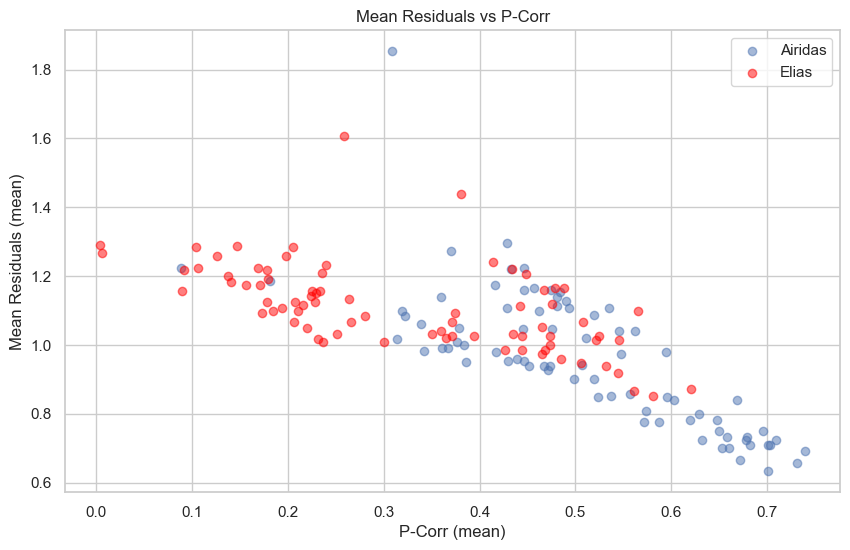

In [59]:
import matplotlib.pyplot as plt

# Assuming 'mean_residual_Airidas_mean' and 'p-corr_Airidas_mean' are already computed as mean values in your aggregated dataframe
# Plotting for Airidas
plt.figure(figsize=(10, 6))
plt.scatter(dfg['p-corr_Airidas_mean'], dfg['MAE_airi_mean'], label='Airidas', alpha=0.5)

# Assuming 'mean_residual_Elias_mean' and 'p-corr_Elias_mean' are also computed as mean values
# Plotting for Elias
plt.scatter(dfg['p-corr_Elias_mean'], dfg['MAE_eli_mean'], color='red', label='Elias', alpha=0.5)

plt.title('Mean Residuals vs P-Corr')
plt.xlabel('P-Corr (mean)')
plt.ylabel('Mean Residuals (mean)')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

# Parameters for the normal distribution
mu = 2  # example mean
sigma = 1  # example standard deviation

# Define the integrand function
def integrand(x):
    return np.abs(x - 2) * norm.pdf(x, mu, sigma)

# Compute the integral
result, _ = quad(integrand, -np.inf, np.inf)
print("Mean Absolute Error:", result)

Mean Absolute Error: 0.7978845608028617


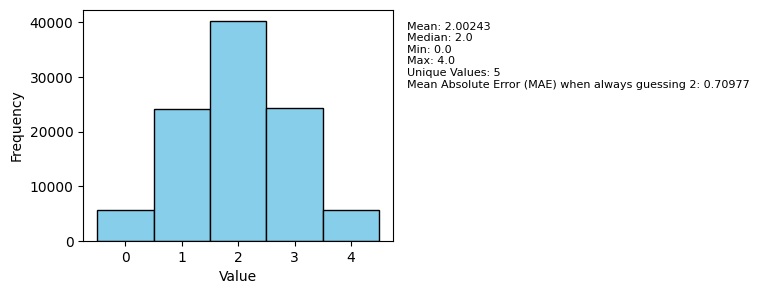

In [71]:
import numpy as np
import matplotlib.pyplot as plt
mu, n = 2, 100000
sigma = np.sqrt(0.9)
np.random.seed(0)
data = np.random.normal(mu, sigma, n)
data_rounded = np.round(data).clip(0, 4)
plt.figure(figsize=(4, 3))
plt.hist(data_rounded, bins=np.arange(6) - 0.5, edgecolor='black', color='skyblue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(range(5))
stats_text = f"Mean: {np.mean(data_rounded)}\nMedian: {np.median(data_rounded)}\nMin: {np.min(data_rounded)}\nMax: {np.max(data_rounded)}\nUnique Values: {len(np.unique(data_rounded))}"
guess = 2
mae = np.mean(np.abs(data_rounded - guess))
stats_text += f"\nMean Absolute Error (MAE) when always guessing {guess}: {mae}"
plt.text(5, plt.ylim()[1] * 0.95, stats_text, fontsize=8, verticalalignment='top')
plt.show()

In [82]:
dff = dfg[dfg["CTX_limit"] == "4000"]

In [83]:
# Calculate average
average_value = dff["avg_tokens_in_prompt"].mean()

# Calculate minimum
min_value = dff["avg_tokens_in_prompt"].min()

# Calculate maximum
max_value = dff["avg_tokens_in_prompt"].max()

# Printing the results
print("Average:", average_value)
print("Minimum:", min_value)
print("Maximum:", max_value)

Average: 3683.75
Minimum: 2849
Maximum: 4218


In [86]:
survey.KanoSurvey().df

Using default Kano Survey CSV file: surveys/survey_kano-model.csv


type                                           question  \
4      1  What would you say if there were options to de...   
5      2  What would you say if there were NO options to...   
6      1  What would you say if the game had the option ...   
7      2  What would you say if the game did NOT have th...   
8      1  What would you say if the game has good graphics?   
9      2  What would you say if the game had NO good gra...   
10     1  What would you say if the game had an exciting...   
11     2  What would you say if the game did NOT have an...   
12     1  What would you say if there were rewards such ...   
13     2  What would you say if there were NO rewards su...   
14     1  What would you say if the game had realistic g...   
15     2  What would you say if the game does NOT have r...   
16     1  What would you say if the game had a relaxed f...   
17     2  What would you say if the game DON'T have a re...   
18     1  What would you say if the game had a multiplay...   
19     2  What would you say if the game does NOT have m...   
20     1  What would you say if you can loot defeated en...   
21     2  What would you say if you CANNOT loot defeated...   
22     1      What would you say if the game had cutscenes?   
23     2  What would you say if the game DIDN'T have cut...   
24     1  What would you say if the game had more and in...   
25     2  What would you say if the game had NO levels, ...   
26     1  What would you say if the game had a high scor...   
27     2  What would you say if the game does NOT have a...   
28     1  What would you say if the game contains role-p...   
29     2  What would you say if the game contained NO ro...   
30     1  What would you say if the game had realistic g...   
31     2  What would you say if the game DON'T have real...   
32     1  What would you say if the game offered the opp...   
33     2  What would you say if the game does NOT provid...   
34     1  What would you say if the game contained viole...   
35     2  What would you say if the game contained NO vi...   
36     1  What would you say if the game gave you creati...   
37     2  What would you say if the game DIDN'T give you...   
38     1  What would you say if the game had a compellin...   
39     2  What would you say if the game DIDN'T have a c...   
40     1         What would you say if the game had quests?   
41     2  What would you say if the game did NOT have qu...   
42     1  What would you say if the game had a clear end...   
43     2  What would you say if the game does NOT have a...   

                                               format            airidas  \
4   I like it; I expect it; I am neutral; I can to...       I am neutral   
5   I like it; I expect it; I am neutral; I can to...  I can tolerate it   
6   I like it; I expect it; I am neutral; I can to...        I expect it   
7   I like it; I expect it; I am neutral; I can to...       I dislike it   
8   I like it; I expect it; I am neutral; I can to...          I like it   
9   I like it; I expect it; I am neutral; I can to...       I am neutral   
10  I like it; I expect it; I am neutral; I can to...          I like it   
11  I like it; I expect it; I am neutral; I can to...  I can tolerate it   
12  I like it; I expect it; I am neutral; I can to...          I like it   
13  I like it; I expect it; I am neutral; I can to...       I dislike it   
14  I like it; I expect it; I am neutral; I can to...          I like it   
15  I like it; I expect it; I am neutral; I can to...  I can tolerate it   
16  I like it; I expect it; I am neutral; I can to...       I am neutral   
17  I like it; I expect it; I am neutral; I can to...       I am neutral   
18  I like it; I expect it; I am neutral; I can to...          I like it   
19  I like it; I expect it; I am neutral; I can to...  I can tolerate it   
20  I like it; I expect it; I am neutral; I can to...        I expect it   
21  I like it; I expect it; I am neutral; I can to..